In [129]:
sessionInfo()

R version 4.3.2 (2023-10-31)
Platform: aarch64-apple-darwin20 (64-bit)
Running under: macOS Sonoma 14.4

Matrix products: default
BLAS:   /Library/Frameworks/R.framework/Versions/4.3-arm64/Resources/lib/libRblas.0.dylib 
LAPACK: /Library/Frameworks/R.framework/Versions/4.3-arm64/Resources/lib/libRlapack.dylib;  LAPACK version 3.11.0

locale:
[1] en_US.UTF-8/en_US.UTF-8/en_US.UTF-8/C/en_US.UTF-8/en_US.UTF-8

time zone: America/New_York
tzcode source: internal

attached base packages:
[1] stats4    stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] scales_1.3.0            presto_1.0.0            patchwork_1.1.3        
 [4] magrittr_2.0.3          harmony_1.2.0           Rcpp_1.0.12            
 [7] ggrepel_0.9.4           ggridges_0.5.5          ggpubr_0.6.0           
[10] Biostrings_2.70.1       GenomeInfoDb_1.38.2     XVector_0.42.0         
[13] IRanges_2.36.0          S4Vectors_0.40.2        BiocGenerics_0.48.1    
[16] lubridat

# Load Libraries

In [42]:
suppressPackageStartupMessages({
    library(MASS)
    library(gdata)
    library(singlecellmethods) # github install
    library(matrixStats)
    library(data.table)
    library(viridis)
    library(RColorBrewer)
   library(pheatmap)
    library(Matrix)
    library(uwot)
    library(irlba)
    library(Seurat)
    library(factoextra)
    library(dendsort)
    library(tidyverse)
    library(Biostrings)
    library(ggpubr)
    library(ggridges)
    library(ggrepel)
    library(harmony) #github install immunogenomics
    library(presto) #github install immunogenomics
    source("utils.R") #extra functions 
    source("misc_funcs.R") #extra functions #2
})


# Load FlowIndex Data, Load RNA counts, Load ADT counts, Load DNA allele matrices

In [114]:
FlowMatrix <- read_csv("Github_Data/PTEN_FlowMatrix.csv")

Rows: 768 Columns: 21
── Column specification ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr (12): Well_ID, DNA_Barcode, RNA_cell, Experiment_Index, Plate, Edited_In...
dbl  (9): PB_CD45, BV605_CD45, SSC, FSC, FITC_DQB1, PE_CD40, PECY7_CD45, APC...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


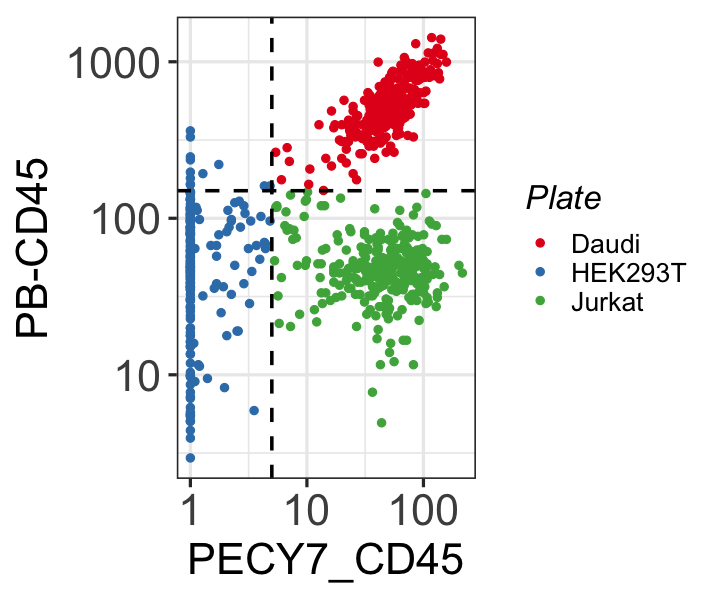

In [115]:
#Indexing Flow with Cell Type and Plate
fig.size(5, 6)
ggplot(FlowMatrix %>% na.omit) +
    geom_point(aes(x=PECY7_CD45, y=PB_CD45, color = CellType_Index), alpha = 1, size = 2) +
    theme_gy(20) + 
    scale_color_brewer(palette = "Set1")  + 
    theme(legend.position = "right") + scale_y_log10() + scale_x_log10() + 
    geom_vline(xintercept = 5, linetype =2, size = 1 )+
    geom_hline(yintercept = 150, linetype =2, size = 1 ) + 
    ylab("PB-CD45") + xlab("PECY7_CD45") + 
labs(color = "Plate", shape = "Cell Type")

In [6]:
#Read in RNA counts merged from different plates. Colnames == cells, rownames == genes
exprs <- readMM("Github_Data/PTEN_RNA_counts.txt")
colnames(exprs) <- read.csv("Github_Data/PTEN_RNA_counts_colnames.txt")[,2]
rownames(exprs) <- read.csv("Github_Data/PTEN_RNA_counts_rownames.txt")[,2]

In [7]:
#Read in adt counts merged from different plates. Colnames == cells, rownames == genes
counts_ADT <- readMM("Github_Data/PTEN_adt_counts.txt")
colnames(counts_ADT) <- read.csv("Github_Data/PTEN_adt_counts_colnames.txt")[,2]
rownames(counts_ADT) <- read.csv("Github_Data/PTEN_adt_counts_rownames.txt")[,2]

In [8]:
# Load DNA alleles calculated from top two CRISPResso alleles
alleles_DNA <- read_csv("Github_Data/PTEN_alleles_dna.csv")

Rows: 1526 Columns: 11
── Column specification ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr (6): Barcode_DNA, Well_ID, Aligned_Sequence, PlateLabel, MainCondition, ...
dbl (5): n_deleted, n_inserted, n_mutated, #Reads, %Reads

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [9]:
#Read in meta file RNA
meta <- read_csv("Github_Data/PTEN_meta.csv")
rownames(meta) <- meta$cell

Rows: 768 Columns: 5
── Column specification ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr (5): plate, cell, MainCondition, ADT, cell_ADT

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Warning message:
“Setting row names on a tibble is deprecated.”


In [10]:
#Read in meta file ADT
meta_ADT <-  read_csv("Github_Data/PTEN_meta_adt.csv")
rownames(meta_ADT) <- meta_ADT$cell

Rows: 768 Columns: 5
── Column specification ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr (5): plate, cell_adt, MainCondition, RNA, cell

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Warning message:
“Setting row names on a tibble is deprecated.”


In [11]:
meta_DNA <- read_csv("Github_Data/PTEN_meta_dna.csv")

Rows: 2 Columns: 4
── Column specification ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr (4): PlateLabel, MainCondition, Barcode_DNA, Reference

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


# Genomic DNA Analysis

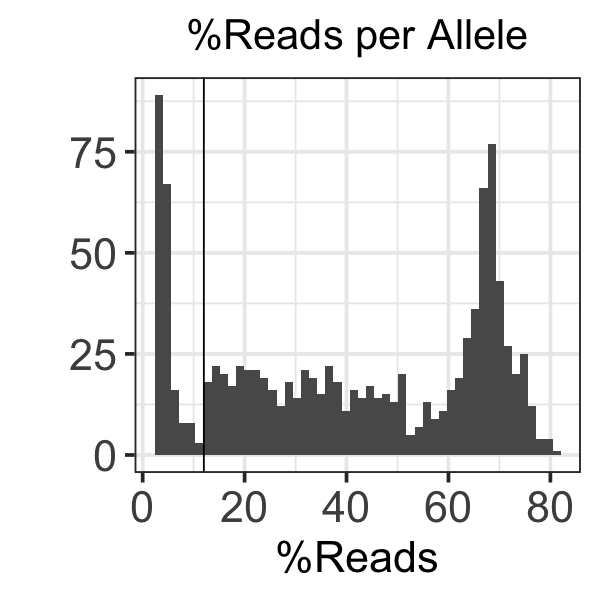

In [12]:
fig.size(5,5) 
#PLotting allele Freq with cells > 40 reads
alleles_DNA %>% filter(`#Reads` > 40) %>%
    ggplot(aes((`%Reads`))) + 
    geom_histogram(bins = 50) + theme_gy() + geom_vline(xintercept = 12) + 
    xlab("%Reads") + ylab("") + ggtitle("%Reads per Allele")

In [13]:
### Define an all encompasing reference sequence with indels present. 
PTENindelseq <- "GTGGTCTGCCAGCTAAAGGTGAAGATATATTCCTCCAATTCAGGACCCACACGGGCCCATGGGGGAAGACAAGTTCATGTACTTTGAGTTCCCTCAGCCCTGAAGTTCATGTACTTTGAGTTCCCTCAGCCCTGGGTTGTTACCTGTGTGTGGTGATATCAAAGTAGAGTTCTTCCACAAACAGAACAAGATGCTAAAAAAGGTTTGTACTTTACTTTCATTGGGA"

In [14]:
alleles_DNA_align <- mutate(alleles_DNA, "Reference" = PTENindelseq)
#Replace all special characters
alleles_DNA_align <- mutate(alleles_DNA_align, "Aligned_Sequence" = 
                                 str_replace_all(Aligned_Sequence, pattern = "-", replace = ""))
#Perform biostrings alignment
alleles_DNA_align <- mutate(alleles_DNA_align, "Aligned_Sequence" = as.character(alignedPattern
                                                               (pairwiseAlignment(Aligned_Sequence, Reference))))

In [15]:
## Fix the location of two insertion nucleotides AC, for visualization purposes. 
alleles_DNA_align<- mutate(alleles_DNA_align, 
                                "Aligned_Sequence" = 
                                str_replace(Aligned_Sequence, pattern = "AC-------GGG", replace = "-------ACGGG"))

In [16]:
#Filter Alleles based on #Reads and AlleleFreq
alleles_DNA_align_filt <- alleles_DNA_align %>% mutate("Plate_Well" = paste0(Barcode_DNA, "_", Well_ID)) %>% 
    FilterAlleles(12,40) 
#Join Meta Data
alleles_DNA_align_filt<- separate(alleles_DNA_align_filt, Plate_Well, into = c("Barcode_DNA", "Well_ID")) %>% 
    inner_join(select(meta_DNA, -Reference))
alleles_DNA_align_filt <- mutate(alleles_DNA_align_filt, 
                                      Reference = alleles_DNA_align$Reference[1])

#Trim length from P7 for visualization
alleles_DNA_align_filt<- 
    mutate(alleles_DNA_align_filt, 
           "Allele1" = str_trunc(Allele1, 180, "left", ellipsis = "")) %>% 
    mutate("Allele2" = str_trunc(Allele2, 180, "left", ellipsis = "")) %>% 
    mutate("Reference"= str_trunc(Reference, 180, "left", ellipsis = ""))%>% 
    mutate("Allele1" = str_trunc(Allele1, 100, "right", ellipsis = "")) %>% 
    mutate("Allele2" = str_trunc(Allele2, 100, "right", ellipsis = "")) %>% 
    mutate("Reference"= str_trunc(Reference, 100, "right", ellipsis = ""))

#Call genotypes
alleles_DNA_align_filt_gen <- GenotypesFunction(alleles_DNA_align_filt)

Joining with `by = join_by(Plate_Well, Reference)`
Joining with `by = join_by(Barcode_DNA)`
Warning message:
“The `x` argument of `as_tibble.matrix()` must have unique column names if `.name_repair` is omitted as of tibble 2.0.0.
ℹ Using compatibility `.name_repair`.”
Joining with `by = join_by(Alleles)`


Warning message:
“`as_data_frame()` was deprecated in tibble 2.0.0.
ℹ Please use `as_tibble()` (with slightly different semantics) to convert to a tibble, or `as.data.frame()` to convert to a data frame.”


.
  1  10   2   3   4   5   6   7   8   9 
396   1  67  11 124  15   1  32   1   1 

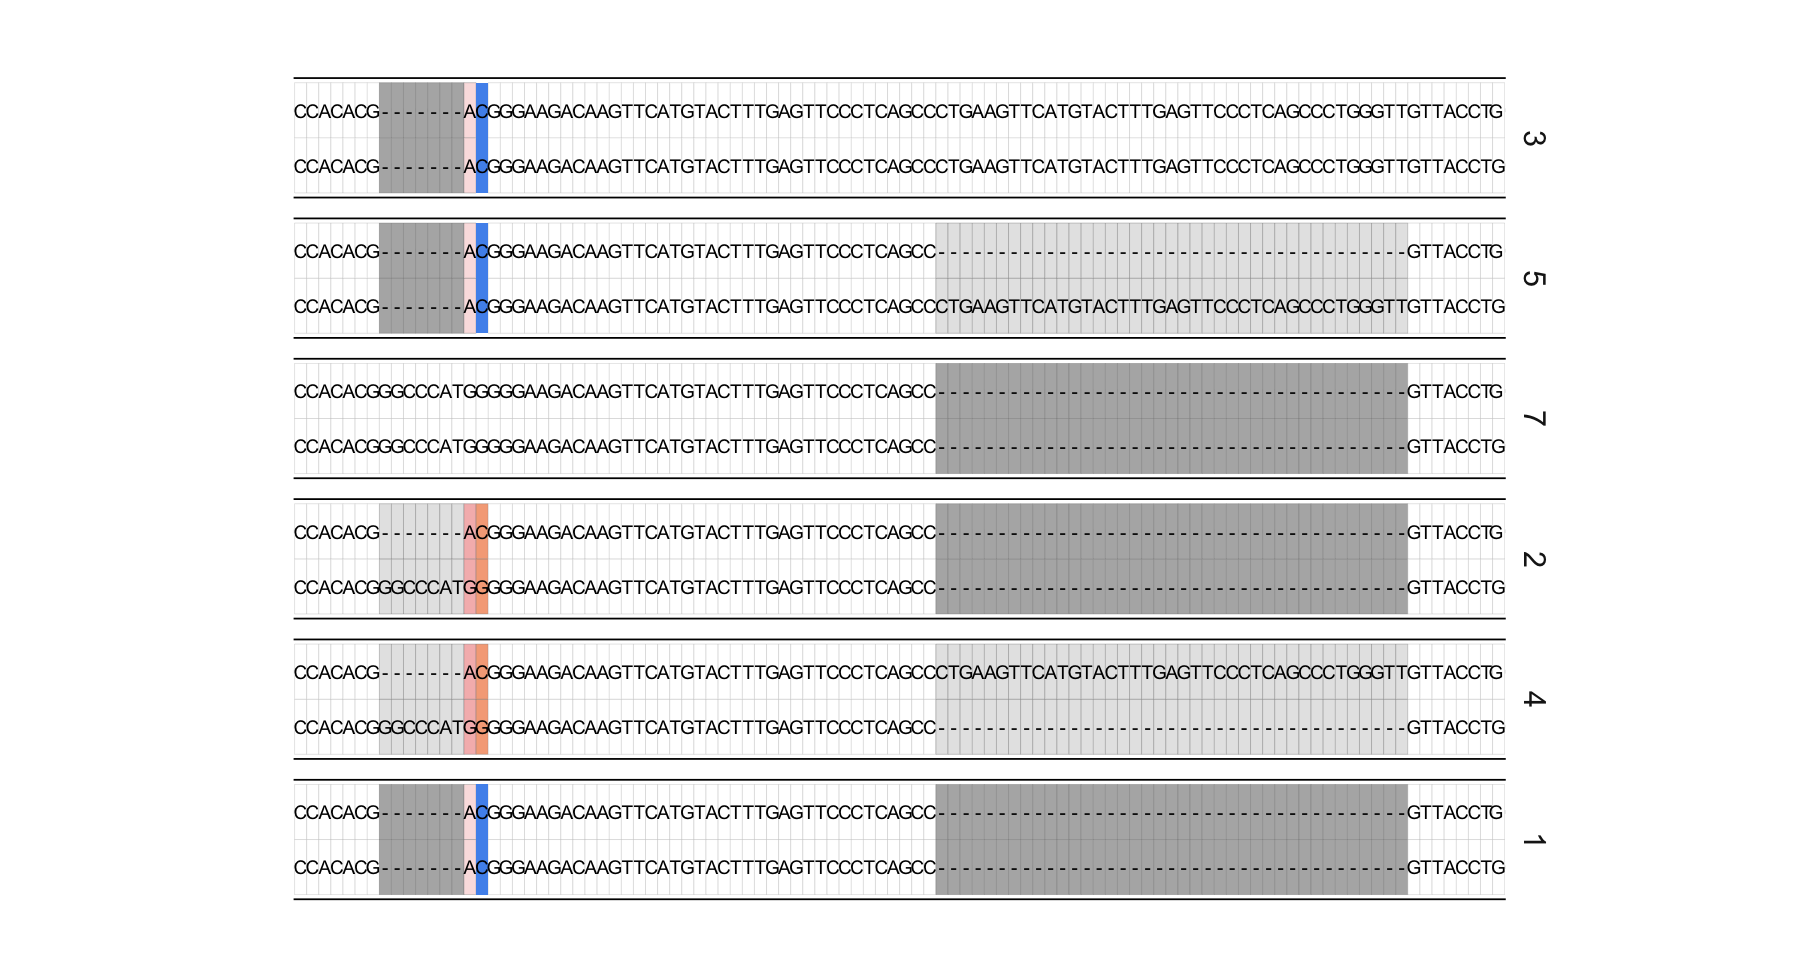

In [17]:
#Defineplotting Order
order <- alleles_DNA_align_filt_gen$genotype %>% table %>% as_data_frame %>% arrange(`n`)
order <- as.character(order$`.`)

#Plot genotypes with more than 1 cell
fig.size(8,15)
df<- GenotypeHeatmap2(alleles_DNA_align_filt_gen, 1)
df$Genotype <- factor(df$Genotype, levels = c(paste0("G", 100:1)))

g <-     

g<- df %>% #the number is the filter on genotype 
ggplot(aes(x = reorder(position, as.integer(position)), 
           y = allele, fill = `value`)) + 
    geom_tile(aes(color = value), width=1, height=1) +
        geom_text(data = dplyr::filter(df),
                  aes(label = `allele_value`), angle = 0, size = (4)) + 
        scale_fill_manual(values = 
                    c(R = 'white',
                      CC = "#5194ed", 
                      TT = "#fdb462", 
                      AA = "#fae1e1",
                      GG = "#a6cee3",
                      CT = "#7fc97f",
                      TC = "#7fc97f",
                      GT = "#ef3b2c",
                      TG = "#ef3b2c",
                      CG = "#f5aa87", 
                      GC = "#f5aa87",
                      AG = "#f5bbba",
                      GA = "#f5bbba",
                     `-A`= "grey90", 
                     `-T` = "grey90", 
                     `-C` = "grey90", 
                     `-G` = "grey90", 
                     `--` ="grey70",
                      `A-`= "grey90", 
                     `T-` = "grey90", 
                     `C-` = "grey90", 
                     `G-` = "grey90", 
                     `--` ="grey70"
                     ))+ 
        scale_color_manual(values = 
                   c(R = 'grey',
                      CC = "NA", 
                      TT = "NA", 
                      CT = "NA", 
                      GT = "NA",
                      CG = "NA",
                      GG = "NA",  
                     AG = "NA"))+ 
     #c("#386cb0","#fdb462","#7fc97f","#ef3b2c","#662506","#a6cee3","#fb9a99","#984ea3","#ffff33"))
        ggtitle("") + 
        theme_gy()+
    xlab("")+
    theme(aspect.ratio = 0.1)+ 
    ylab("") +
    theme(axis.text.y = element_text(size = 0, angle = 0, hjust = .5, vjust = .5),
          axis.text.x = element_text(size = 0),
        axis.title.x = element_text(size = 20, angle = 0, hjust = .5, vjust = .5),
        axis.title.y = element_text(size = 20, angle = 90, hjust = .5, vjust = .5),
          axis.ticks.y = element_blank(),
         legend.position = "none") + 
    scale_x_discrete(breaks=NULL) + 
    facet_grid(factor((genotypes), levels = order)~.)+ 
theme(
  strip.background = element_blank(),
  strip.text.x = element_blank(), 
    panel.border=element_blank()

) + 
    annotate(geom = 'segment', y = Inf, yend = Inf, color = 'black', x = -Inf, xend = Inf, linewidth = 1) + 

    annotate(geom = 'segment', y = -Inf, yend = -Inf, color = 'black', x = -Inf, xend = Inf, linewidth = 1)
plot(g)

alleles_DNA_align_filt_gen$genotype %>% table

In [18]:
## Add count of genotypes
alleles_DNA_align_filt_gen <- alleles_DNA_align_filt_gen %>% group_by(genotype) %>%
  mutate(genotype_count = n())
## Filter on at least 1 cells per genotype identified
alleles_DNA_align_filt_gen <- filter(alleles_DNA_align_filt_gen, genotype_count > 1)

In [ ]:
# Allele Freq - this is being caused by a sequencing error from too many T's 
FBXO11_alleles_DNA %>% 
    ggplot(aes((`%Reads`))) + 
    geom_histogram(bins = 50) + theme_gy() + geom_vline(xintercept = (10)) + 
    xlab("%Reads") + ylab("") + ggtitle("%Reads per Allele")

In [ ]:
#Filter alleles
FBXO11_alleles_DNA_filt <- FBXO11_alleles_DNA %>% mutate("Plate_Well" = paste0(Barcode_DNA, "_", Well_ID)) %>% 
    FilterAlleles(12, 40) 
#Merge with metaData
FBXO11_alleles_DNA_filt<- 
    FBXO11_alleles_DNA_filt %>% separate(Plate_Well, into = c("Barcode_DNA", "Well_ID")) %>% inner_join(meta_DNA)

#Fix length from P7
FBXO11_alleles_DNA_filt<- FBXO11_alleles_DNA_filt %>% 
    mutate("Allele1" = str_trunc(Allele1, 65, "left",ellipsis = "" )) %>% 
    mutate("Allele2" = str_trunc(Allele2, 65, "left", ellipsis = "")) %>% 
    mutate("Reference"= str_trunc(Reference, 65, "left", ellipsis = "")) %>% 
    mutate("Allele1" = str_trunc(Allele1, 50, "right",ellipsis = "" )) %>% 
    mutate("Allele2" = str_trunc(Allele2, 50, "right", ellipsis = "")) %>% 
    mutate("Reference"= str_trunc(Reference, 50, "right", ellipsis = ""))
#Call genotypes
FBXO11_alleles_DNA_filt_gen <- GenotypesFunction(FBXO11_alleles_DNA_filt)

In [ ]:
FBXO11_alleles_DNA_filt_gen$genotype %>% table %>% sort(decreasing = T)

In [ ]:
fig.size(5,10)
#Define order
order <- FBXO11_alleles_DNA_filt_gen$genotype %>% table %>% as_data_frame %>% arrange(`n`)
order <- as.character(order$`.`)
#Make DF for plotting
df<- GenotypeHeatmap2(FBXO11_alleles_DNA_filt_gen, 2)
#Fix order
df$genotypes <- factor(df$genotypes, levels = order)

g <-     

g<- df %>% #the number is the filter on genotype 
ggplot(aes(x = reorder(position, as.integer(position)), 
           y = allele, fill = `value`)) + 
    geom_tile(aes(color = value), width=1, height=1) +
        geom_text(data = dplyr::filter(df),
                  aes(label = `allele_value`), angle = 0, size = (4)) + 
        geom_text(data = dplyr::filter(df, value != "R"),
                  aes(label = allele_value), angle = 0, size = (4))+
        scale_fill_manual(values = 
                    c(R = 'white',
                    CC = "#5194ed", 
                      TT = "#fdb462", 
                      CT = "#7fc97f", 
                      GT = "#ef3b2c",
                      CG = "#f5aa87",
                      GG = "#a6cee3",  
                      AG = "#f5bbba",
                      AA = "#fae1e1",
                     `-A`= "grey90", 
                     `-T` = "grey90", 
                     `-C` = "grey90", 
                     `-G` = "grey90", 
                     `--` ="grey80"))+ 
        scale_color_manual(values = 
                   c(R = 'grey',
                      CC = "NA", 
                      TT = "NA", 
                      CT = "NA", 
                      GT = "NA",
                      CG = "NA",
                      GG = "NA",  
                     AG = "NA"))+ 
     #c("#386cb0","#fdb462","#7fc97f","#ef3b2c","#662506","#a6cee3","#fb9a99","#984ea3","#ffff33"))
        ggtitle("") + 
        theme_gy()+
    xlab("")+
    theme(aspect.ratio = 0.1)+ 
    ylab("") +
    theme(axis.text.y = element_text(size = 0, angle = 0, hjust = .5, vjust = .5),
          axis.text.x = element_text(size = 0),
        axis.title.x = element_text(size = 20, angle = 0, hjust = .5, vjust = .5),
        axis.title.y = element_text(size = 20, angle = 90, hjust = .5, vjust = .5),
          axis.ticks.y = element_blank(),
         legend.position = "none") + 
    scale_x_discrete(breaks=NULL) + 
    facet_grid(genotypes~.)+ 
theme(
  strip.background = element_blank(),
  strip.text.x = element_blank(), 
    panel.border=element_blank()

) + 
    annotate(geom = 'segment', y = Inf, yend = Inf, color = 'black', x = -Inf, xend = Inf, size = 1) + 

    annotate(geom = 'segment', y = -Inf, yend = -Inf, color = 'black', x = -Inf, xend = Inf, size = 1)
plot(g)

#suppressWarnings({ 
 #   ggsave(g, filename = "FBXO11Genotypes.png", device = "png", dpi = 300)
  #  })

In [ ]:
FBXO11_alleles_DNA_filt_gen$genotype %>% 
    table %>% as.data.frame() %>% filter(Freq > 2) %>% arrange(Freq)

# Quality Control - Filtering RNA / ADT

## RNA QC

In [19]:
nUMI = colSums(exprs)
nGenes = colSums(exprs > 0)
pctMito = colSums(exprs[rownames(exprs)[rownames(exprs) %>% startsWith('MT-')], ])/nUMI
qc_df = data.frame(nUMI = nUMI, nGenes = nGenes, pctMito = pctMito)

# meta = cbind(meta, qc_df[rownames(meta), ])

In [20]:
meta = cbind(meta, qc_df[rownames(meta), ])

In [21]:
##Add indexing flow data to meta. 
meta_Flow <- FlowMatrix %>% inner_join(meta)

Joining with `by = join_by(cell)`



Attaching package: ‘scales’


The following object is masked from ‘package:purrr’:

    discard


The following object is masked from ‘package:readr’:

    col_factor


The following object is masked from ‘package:viridis’:

    viridis_pal


Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


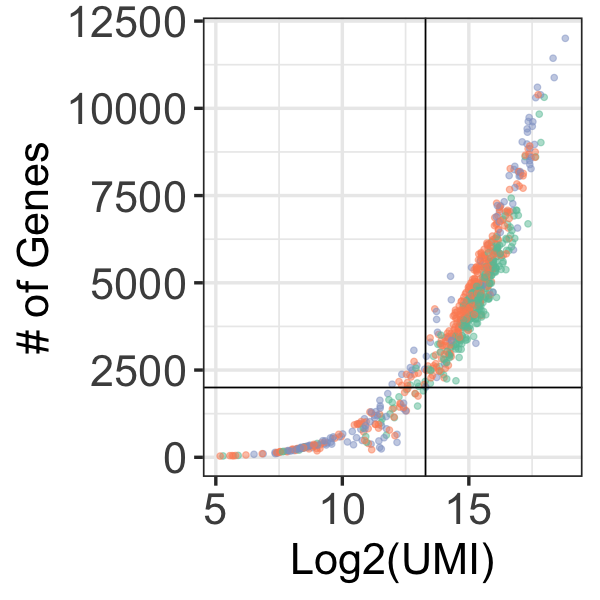

In [22]:
# QC figures
fig.size(5,5)
library(scales)
options(scipen = 999)

ggplot(meta_Flow %>% na.omit) +
       geom_point(aes(x=log2(nUMI), y=nGenes, color = CellType_Index), alpha = 0.5) +
    theme_gy(21) + ylab("# of Genes") + 
    xlab("Log2(UMI)") + scale_color_brewer(palette = "Set2")  + 
    theme(legend.position = "none") + 
    scale_x_continuous(labels = scales::comma) + 
    labs(color = "Celltype")+ 
    scale_color_manual(values = c("HEK293T"='#8DA0CB',
                                  "Daudi" = '#66C2A5',
                                  "Jurkat"='#FC8D62')) + 
    geom_vline(xintercept = log2(10000)) + 
    geom_hline(yintercept = 2000)
    

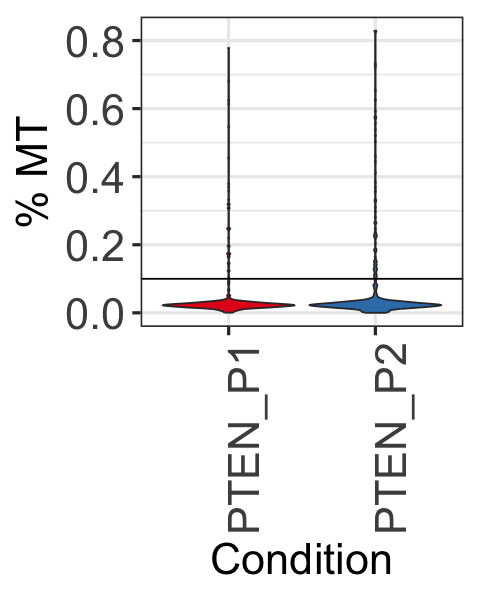

In [23]:
fig.size(5, 4)
meta_Flow %>% na.omit %>%
ggplot()+
    geom_violin(aes(x = Condition, y = pctMito, fill= Condition), scale = 'width')+
    theme_gy()+
    geom_hline(yintercept = 0.1) + 
    theme_gy(20) + ylab("% MT") + 
    scale_fill_brewer(palette = "Set1") + 
    theme(legend.position = "none")+
    theme(axis.text.x = element_text(angle = 90), legend.position = "none")

In [24]:
nCells = rowSums(exprs > 0)
gene_qc = data.frame(nCells = nCells %>% sort %>% rev, rank = seq(1, length(nCells)))

In [25]:
#Set thresholds based on above. 
nUMI_thresh =  10000 #5000 #40
nGene_thresh = 2000
pctMito_thresh = 0.1
ncell_thresh = floor(dim(exprs)[2]*0.1) #expressed in 10% of cells

filt_exprs = exprs[rownames(gene_qc %>% filter(nCells > ncell_thresh)), 
                   rownames(qc_df %>% filter(nUMI > nUMI_thresh, 
                                               nGenes > nGene_thresh, 
                                               pctMito < pctMito_thresh))]
#filtered expression
filt_meta = meta[colnames(filt_exprs),] #filtered meta

In [26]:
filt_cellcount = (table(meta$plate) %>% unclass %>% as.data.frame) - 
                (table(filt_meta$plate) %>% unclass %>% as.data.frame)
filt_cellcount$Condition = rownames(filt_cellcount)

colnames(filt_cellcount)[1] = 'Freq'

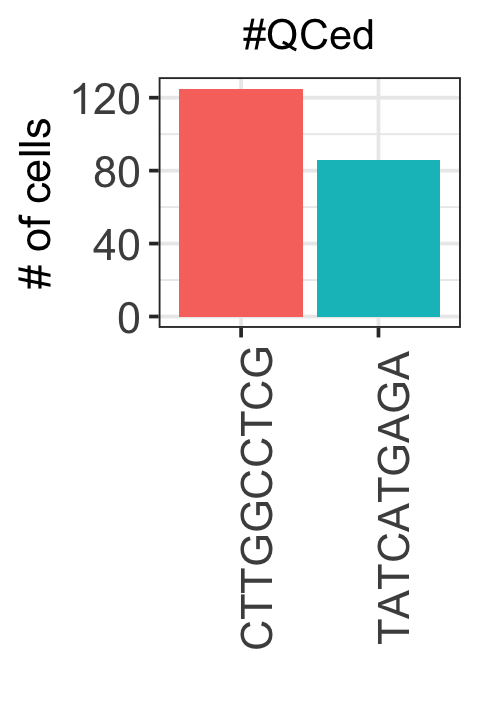

In [27]:
fig.size(6, 4)
ggplot(filt_cellcount)+
    geom_col(aes(y = Freq, x = Condition, fill = Condition))+
    theme_gy()+
    theme(axis.text.x = element_text(angle = 90), legend.position = 'none')+
    xlab('')+
    labs(fill = '')+
    ylab('# of cells')+
    ggtitle("#QCed")

## ADT QC

In [28]:
# Filter non-human ADTs and cells not called by STAR (RNA)
counts_ADT_filt <- counts_ADT[rownames(counts_ADT)[!grepl('^Mouse|^Rat|^Hamster', rownames(counts_ADT))], 
                             intersect(rownames(meta_ADT), rownames(meta))]

meta_ADT_filt <- meta_ADT[intersect(rownames(meta_ADT), rownames(meta)), ]

In [29]:
rownames(meta_ADT_filt) <- meta_ADT_filt$cell

Warning message:
“Setting row names on a tibble is deprecated.”


In [30]:
nUMI_ADT = colSums(counts_ADT_filt)
nGenes_ADT = colSums(counts_ADT_filt > 0)
qc_df_ADT = data.frame(nUMI = nUMI_ADT, nGenes = nGenes_ADT)

meta_ADT_filt = cbind(meta_ADT_filt, qc_df_ADT[rownames(meta_ADT_filt), ])

In [31]:
##Add indexing flow data to meta. First fix labels on FlowMatrix, then add cell barcode, then merge with meta
meta_ADT_Flow <- FlowMatrix %>% inner_join(meta_ADT_filt)

Joining with `by = join_by(cell)`


Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


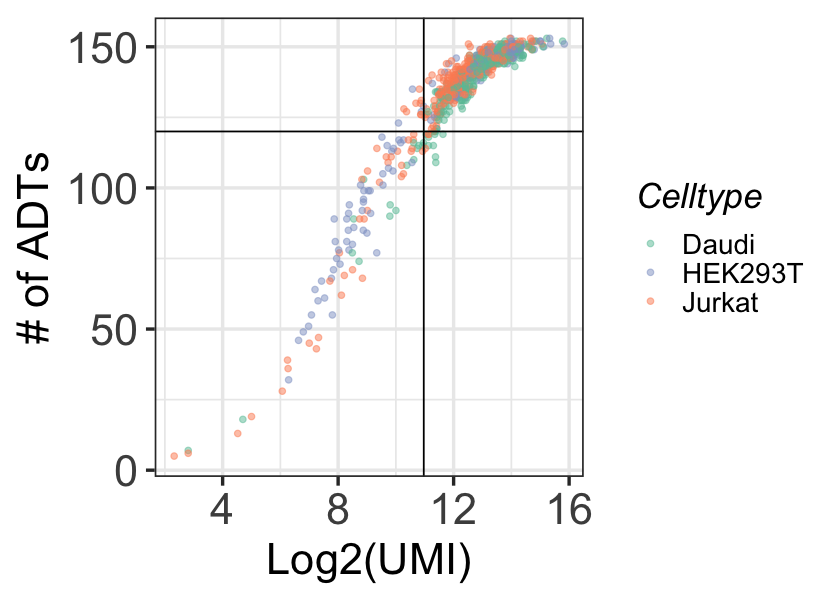

In [32]:
#plotting QC cutoffs
fig.size(5, 7)
ggplot(meta_ADT_Flow %>% na.omit) +
    geom_point(aes(x=log2(nUMI), y=nGenes, color = CellType_Index), alpha = 0.5) +
    theme_gy(21) + ylab("# of ADTs") + 
    xlab("Log2(UMI)") + scale_color_brewer(palette = "Set2") + 
    theme(legend.position = "right") + 
  labs(color = "Celltype")+ 
    scale_color_manual(values = c("HEK293T"='#8DA0CB',
                                  "Daudi" = '#66C2A5',
                                  "Jurkat"='#FC8D62')) +
  geom_vline(xintercept = log2(2000))+
    geom_hline(yintercept = 120)
    

In [33]:
# Filter to QC'd cells only
meta_ADT_filt = meta_ADT_filt %>% filter(nUMI > 2000, nGenes > 120)
counts_ADT_filt = counts_ADT_filt[, rownames(meta_ADT_filt)]

#Intersect with mRNA data to remove low quality cells
meta_ADT_filt <- filter(meta_ADT_filt, cell %in% filt_meta$cell)
counts_ADT_filt = counts_ADT_filt[, intersect(meta_ADT_filt$cell, filt_meta$cell)]


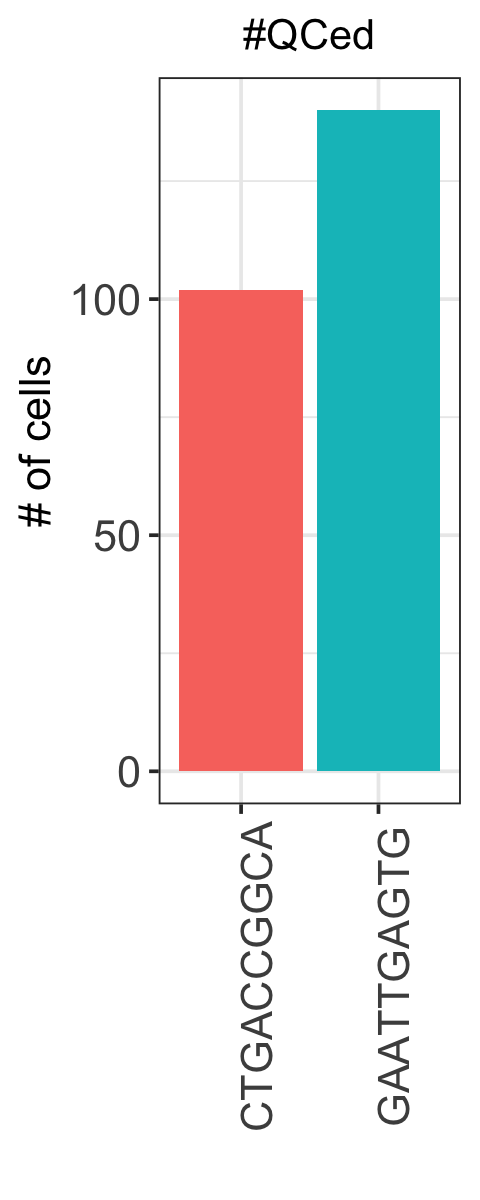

In [34]:
### Number of cells per condition/plate
filt_cellcount = (table(meta_ADT$plate) %>% unclass %>% as.data.frame) - 
                (table(meta_ADT_filt$plate) %>% unclass %>% as.data.frame)
filt_cellcount$Condition = rownames(filt_cellcount)

colnames(filt_cellcount)[1] = 'Freq'

### Number of cells per condition/plate

fig.size(10, 4)
ggplot(filt_cellcount)+
    geom_col(aes(y = Freq, x = Condition, fill = Condition))+
    theme_gy()+
    theme(axis.text.x = element_text(angle = 90), legend.position = 'none')+
    xlab('')+
    labs(fill = '')+
    ylab('# of cells')+
    ggtitle("#QCed")

# Processing RNA - ADT Data

In [113]:
### Pre-process based on metadata conditions

In [35]:
scale_exprs = process_rna(filt_exprs, filt_meta)

'as(<dgTMatrix>, "dgCMatrix")' is deprecated.
Use 'as(., "CsparseMatrix")' instead.
See help("Deprecated") and help("Matrix-deprecated").



In [36]:
scale_adt = process_adt(counts_ADT_filt, 
                        meta_ADT_filt)

In [37]:
# Process all genes (or a subset) without variable gene selection, useful for plotting
plot_exprs_rna = normalize_rna(filt_exprs, filt_meta, scale = TRUE)

# Dimensionality Reduction and Clustering

Harmony 1/10

Harmony 2/10

Harmony 3/10

Harmony 4/10

Harmony 5/10

Harmony 6/10

Harmony 7/10

Harmony 8/10

Harmony 9/10

Harmony 10/10



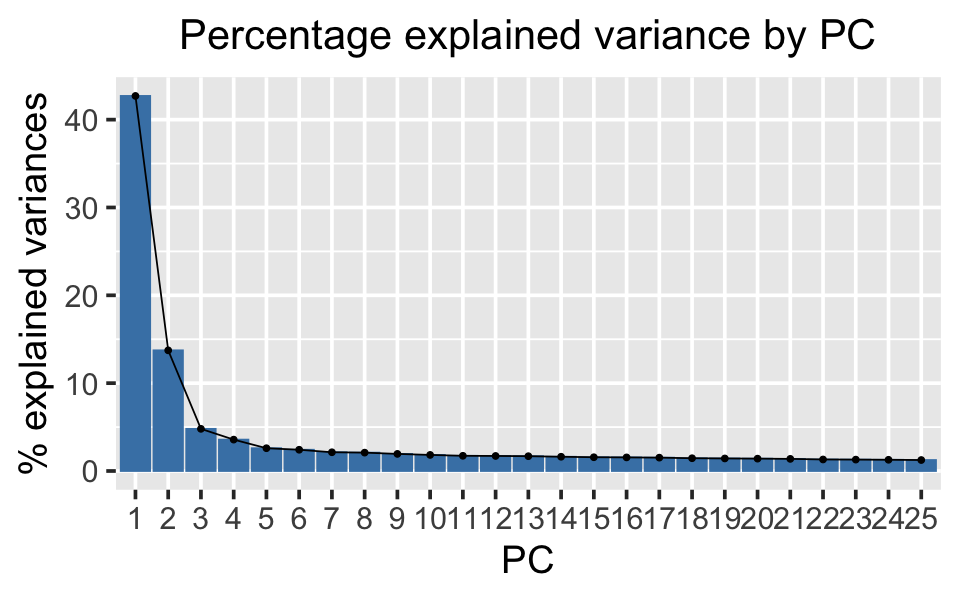

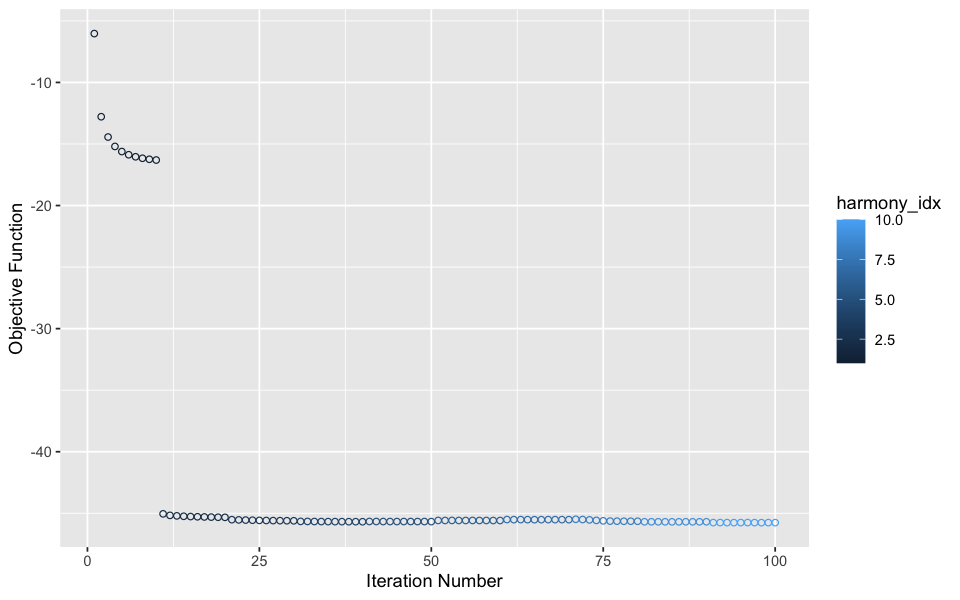

In [120]:
meta_umap_DQB1 = pca_umap(scale_exprs_DQB1, meta, c('MainCondition'), c('DQB1'), harmony_var = 'Condition')

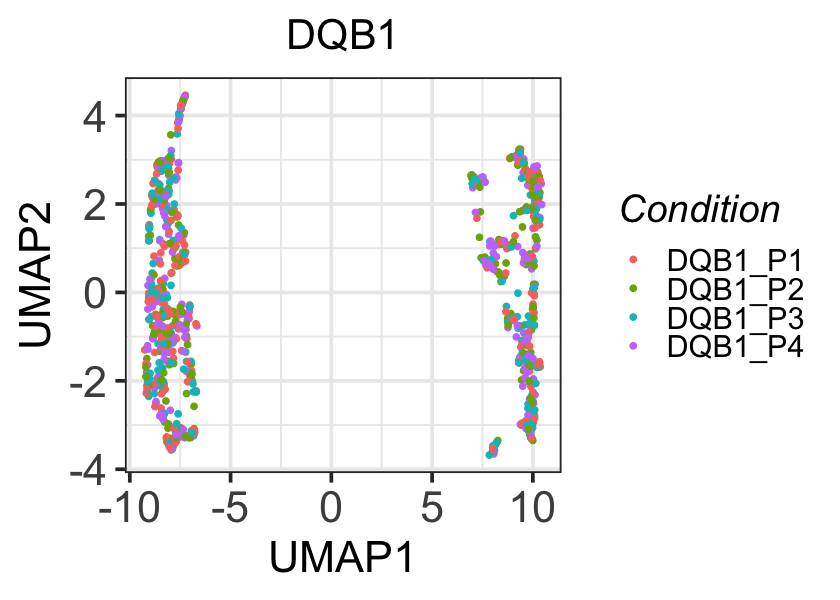

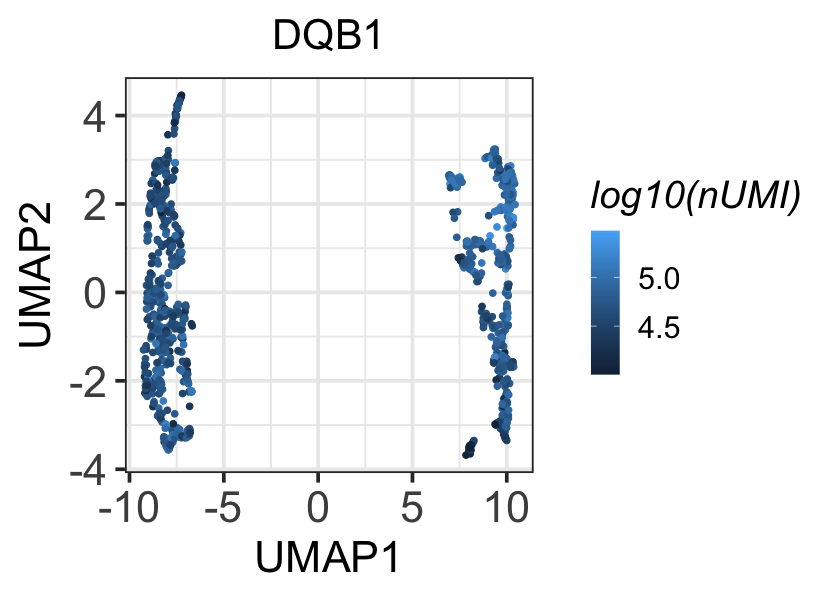

In [121]:
fig.size(5, 7)
ggplot(meta_umap_DQB1 %>% sample_n(nrow(meta_umap_DQB1)))+
    geom_point(aes(x = UMAP1, y = UMAP2, col = Condition))+
    theme_gy()+
    ggtitle('DQB1')
fig.size(5, 7)
ggplot(meta_umap_DQB1 %>% sample_n(nrow(meta_umap_DQB1)))+
    geom_point(aes(x = UMAP1, y = UMAP2, col = log10(nUMI)))+
    theme_gy()+
    ggtitle('DQB1')

Harmony 1/10

Harmony 2/10

Harmony 3/10

Harmony 4/10

Harmony 5/10

Harmony 6/10

Harmony 7/10

Harmony 8/10

Harmony 9/10

Harmony 10/10



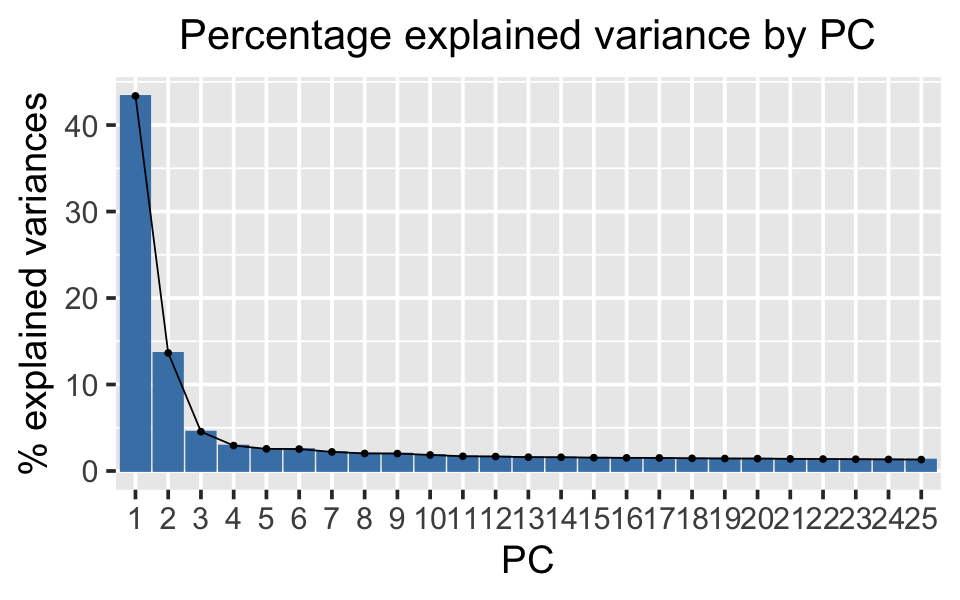

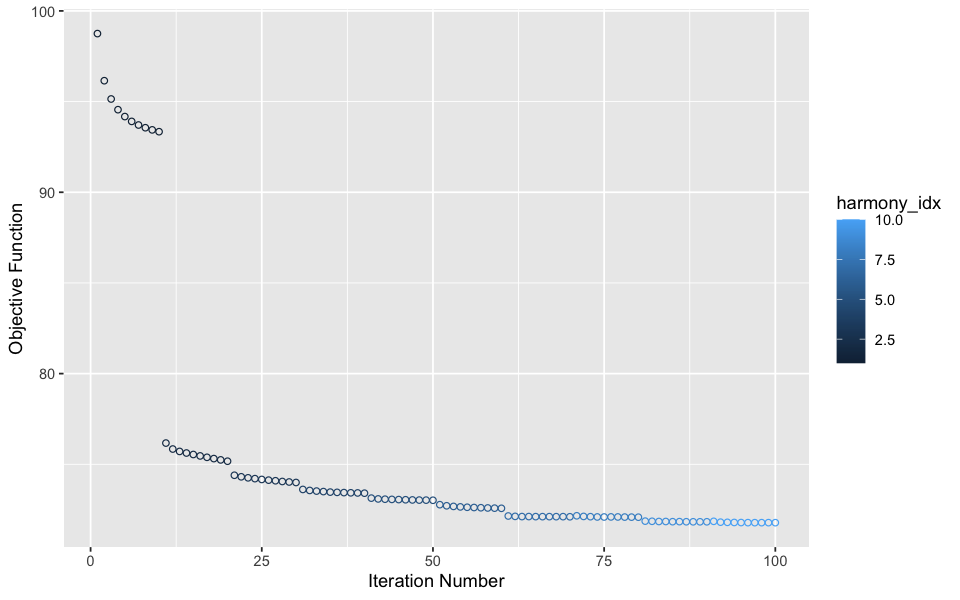

In [122]:
meta_umap_adt_DQB1 = pca_umap(scale_adt_DQB1, meta_ADT_filt, c('MainCondition'), c('DQB1'), 
                            harmony_var = 'Condition')

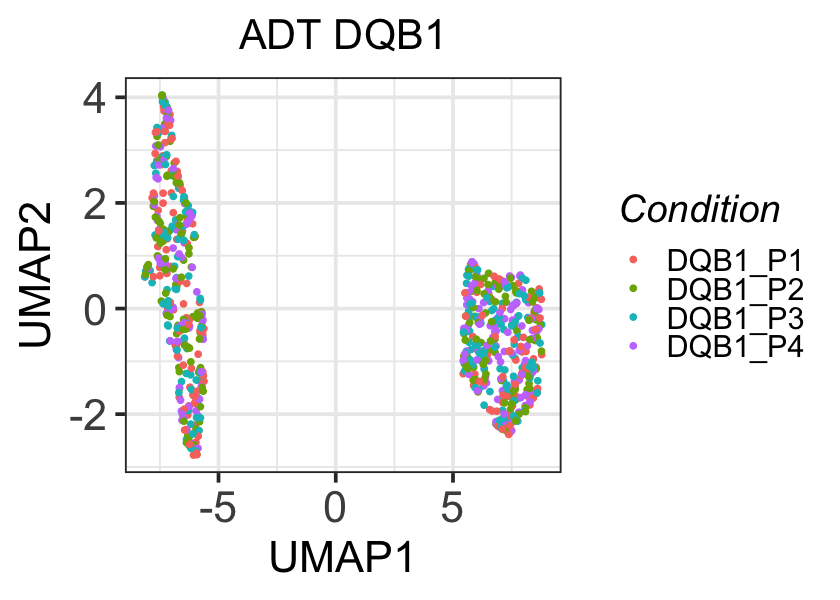

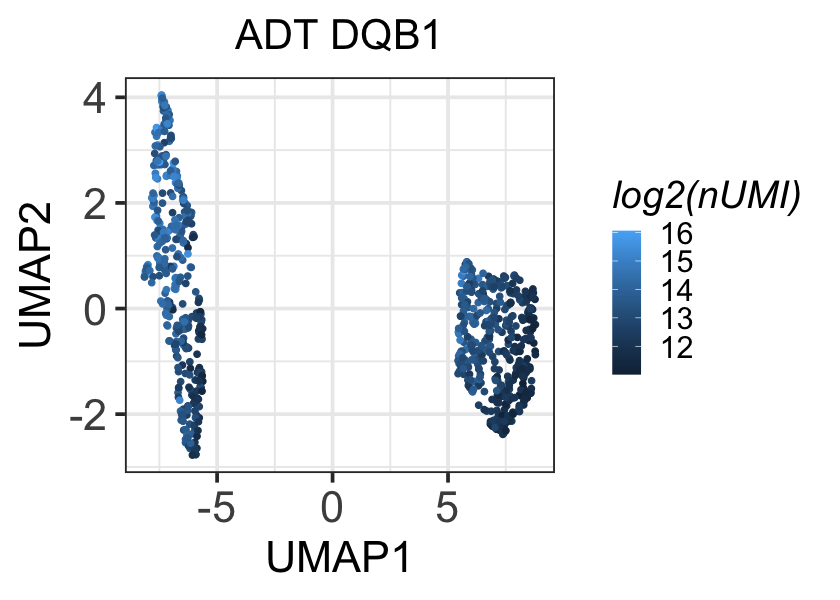

In [123]:
fig.size(5, 7)
ggplot(meta_umap_adt_DQB1 %>% sample_n(nrow(meta_umap_adt_DQB1)))+
    geom_point(aes(x = UMAP1, y = UMAP2, col = Condition))+
    theme_gy()+
    ggtitle('ADT DQB1')

fig.size(5, 7)
ggplot(meta_umap_adt_DQB1 %>% sample_n(nrow(meta_umap_adt_DQB1)))+
    geom_point(aes(x = UMAP1, y = UMAP2, col = log2(nUMI)))+
    theme_gy()+
    ggtitle('ADT DQB1')

Harmony 1/10

Harmony 2/10

Harmony 3/10

Harmony 4/10

Harmony 5/10

Harmony 6/10

Harmony 7/10

Harmony 8/10

Harmony 9/10

Harmony 10/10



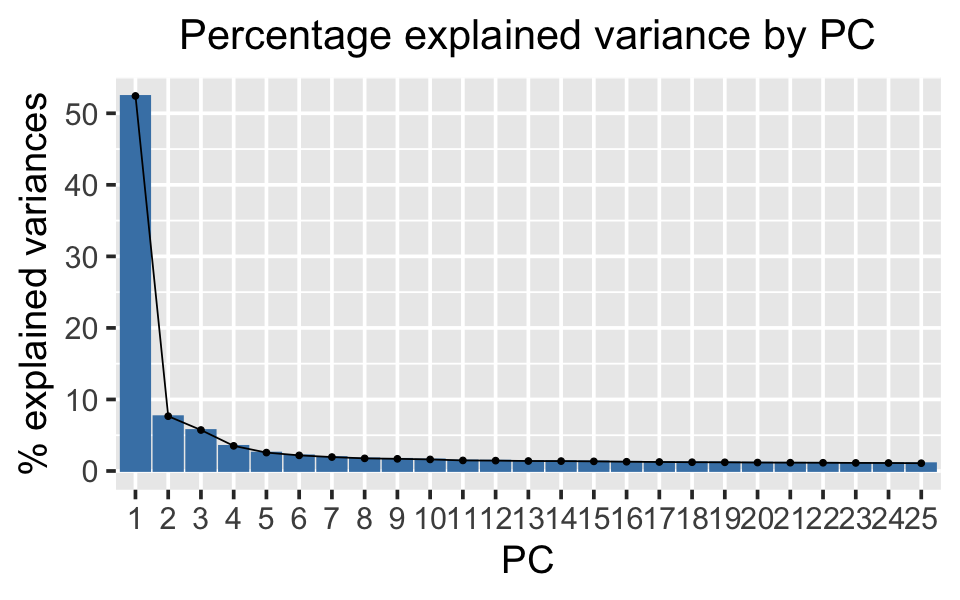

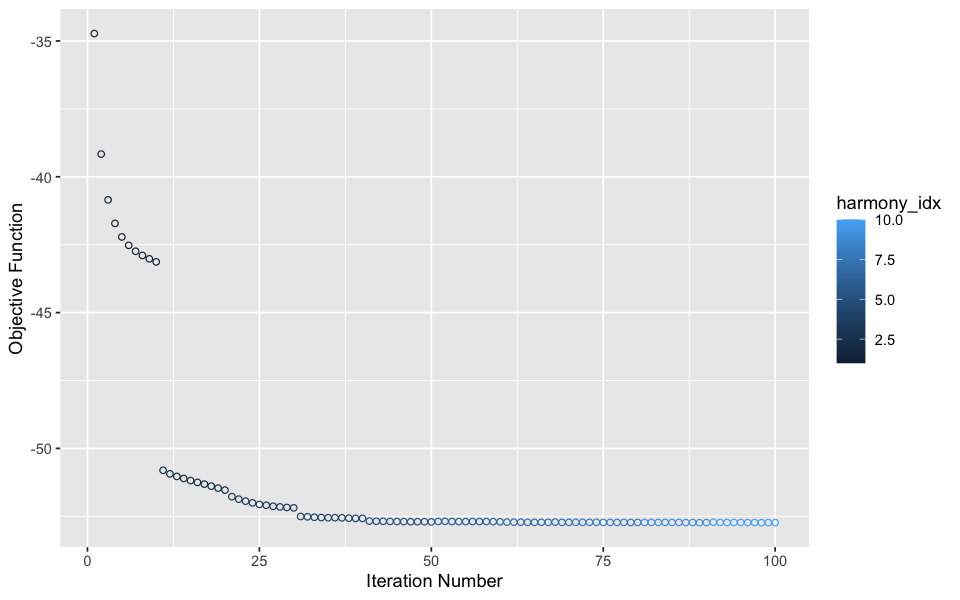

In [124]:
meta_umap_FBXO11 = pca_umap(scale_exprs_FBXO11, meta, c('MainCondition'), c('FBXO11'), harmony_var = 'Condition')

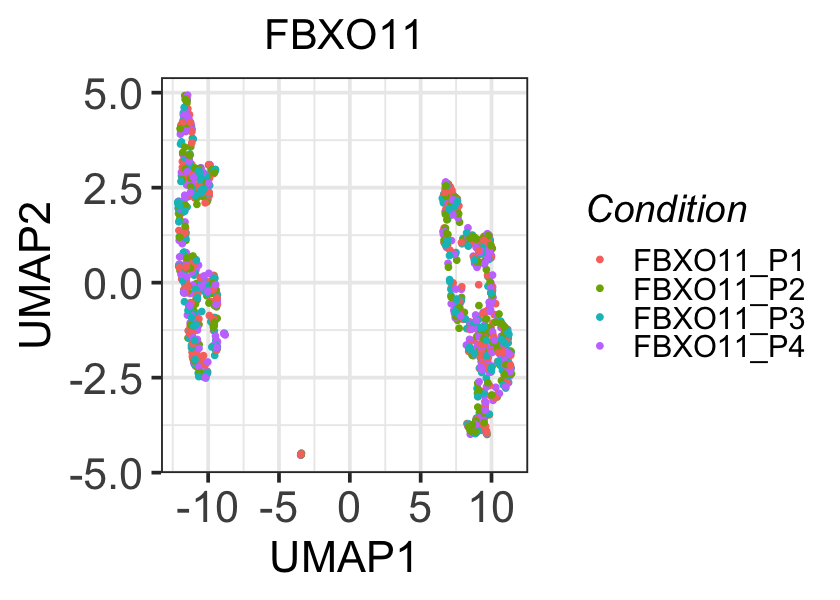

In [125]:
fig.size(5, 7)
ggplot(meta_umap_FBXO11 %>% sample_n(nrow(meta_umap_FBXO11)))+
    geom_point(aes(x = UMAP1, y = UMAP2, col = Condition))+
    theme_gy()+
    ggtitle('FBXO11')

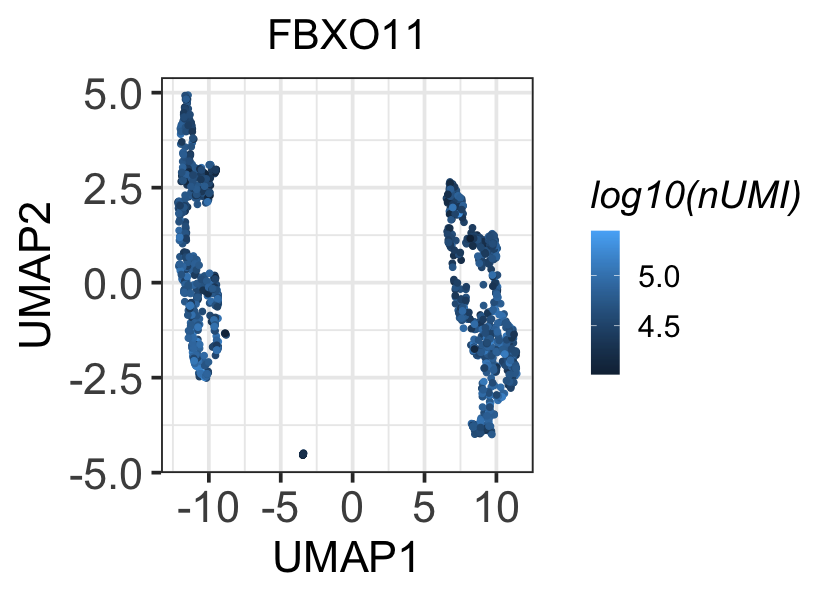

In [126]:
fig.size(5, 7)
ggplot(meta_umap_FBXO11 %>% sample_n(nrow(meta_umap_FBXO11)))+
    geom_point(aes(x = UMAP1, y = UMAP2, col = log10(nUMI)))+
    theme_gy()+
    ggtitle('FBXO11')

Harmony 1/10

Harmony 2/10

Harmony 3/10

Harmony 4/10

Harmony 5/10

Harmony 6/10

Harmony 7/10

Harmony 8/10

Harmony 9/10

Harmony 10/10



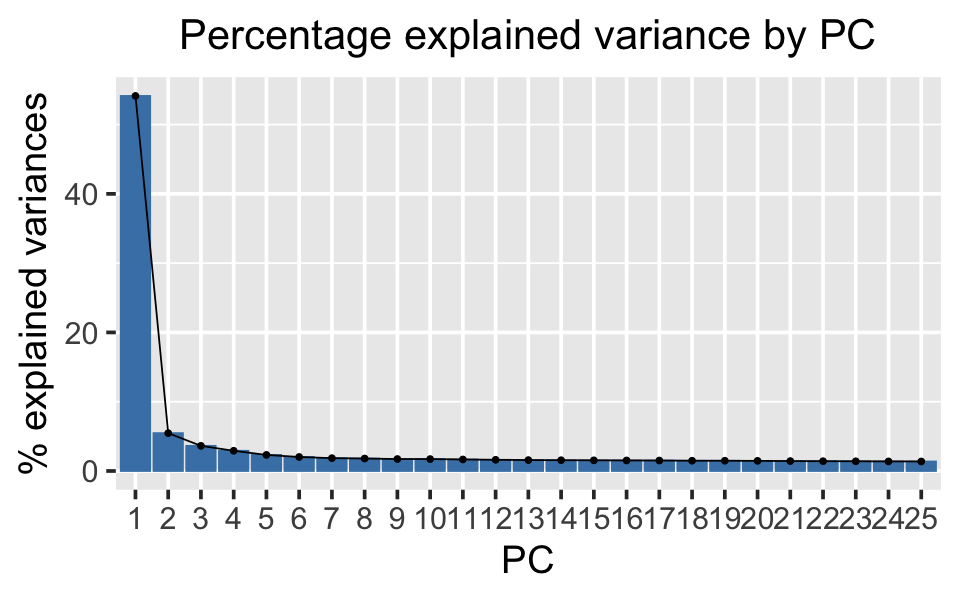

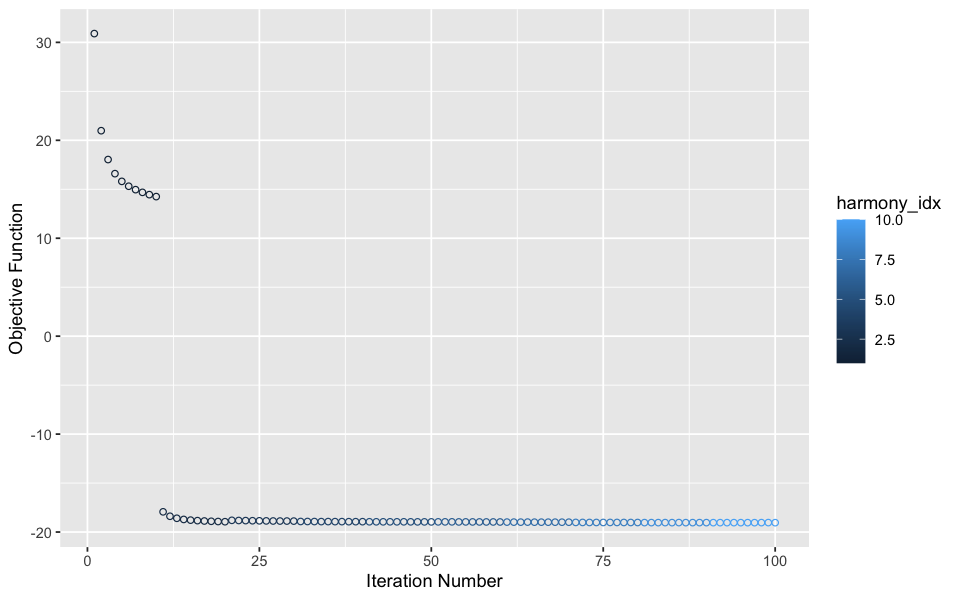

In [127]:
meta_umap_adt_FBXO11 = pca_umap(scale_adt_FBXO11, meta_ADT_filt, c('MainCondition'), c('FBXO11'), 
                            harmony_var = 'Condition')

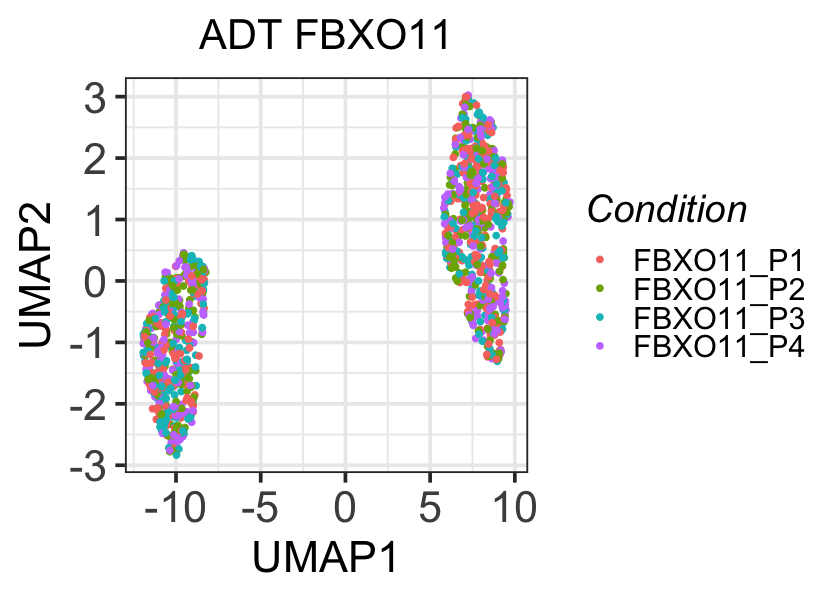

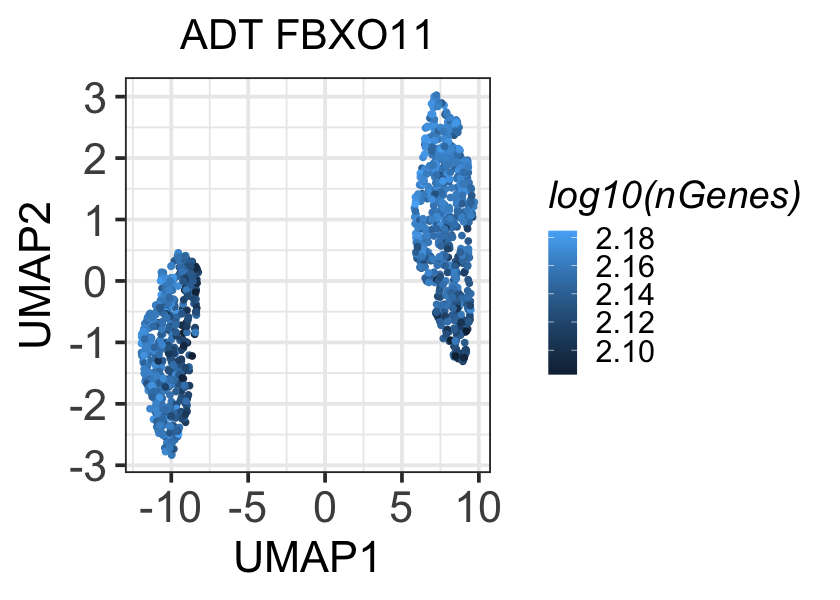

In [129]:
fig.size(5, 7)
ggplot(meta_umap_adt_FBXO11 %>% sample_n(nrow(meta_umap_adt_FBXO11)))+
    geom_point(aes(x = UMAP1, y = UMAP2, col = Condition))+
    theme_gy()+
    ggtitle('ADT FBXO11')

fig.size(5, 7)
ggplot(meta_umap_adt_FBXO11 %>% sample_n(nrow(meta_umap_adt_FBXO11)))+
    geom_point(aes(x = UMAP1, y = UMAP2, col = log10(nGenes)))+
    theme_gy()+
    ggtitle('ADT FBXO11')

## RNA

Transposing data matrix

Initializing state using k-means centroids initialization

Harmony 1/10

Harmony 2/10

Harmony 3/10

Harmony converged after 3 iterations

Found more than one class "dist" in cache; using the first, from namespace 'spam'

Also defined by ‘BiocGenerics’

Found more than one class "dist" in cache; using the first, from namespace 'spam'

Also defined by ‘BiocGenerics’



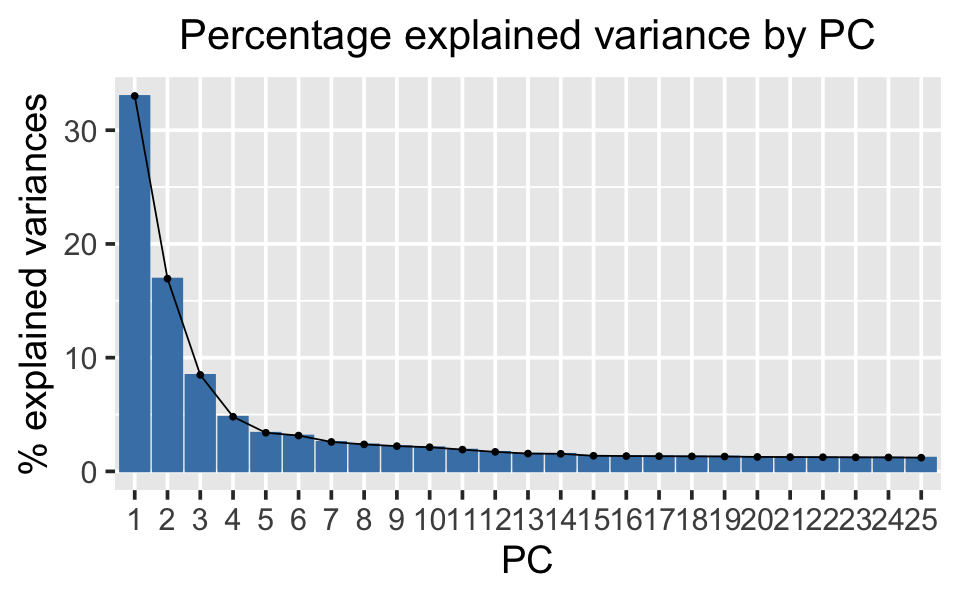

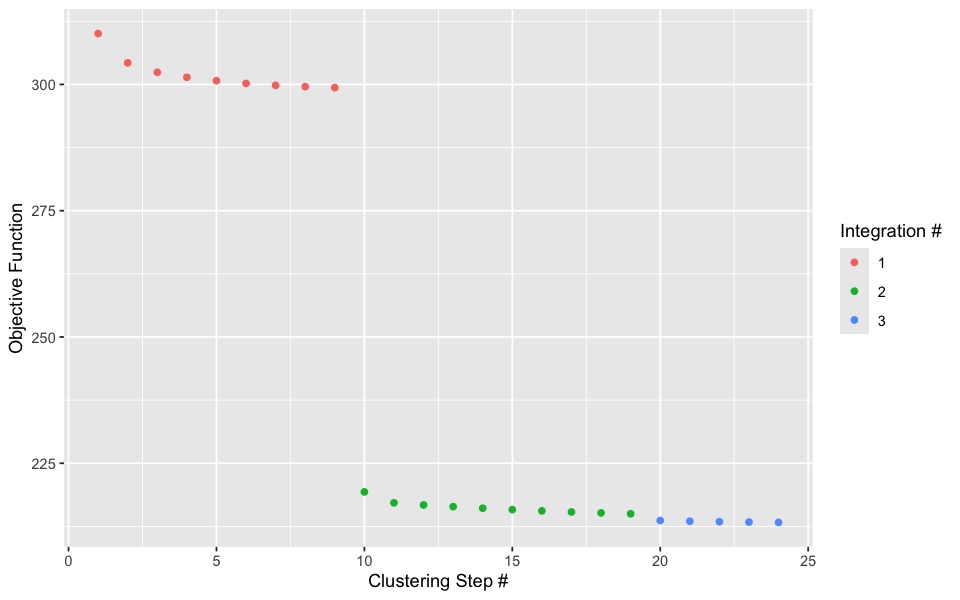

In [45]:
meta_umap = pca_umap(scale_exprs, filt_meta, harmony_var = 'plate')

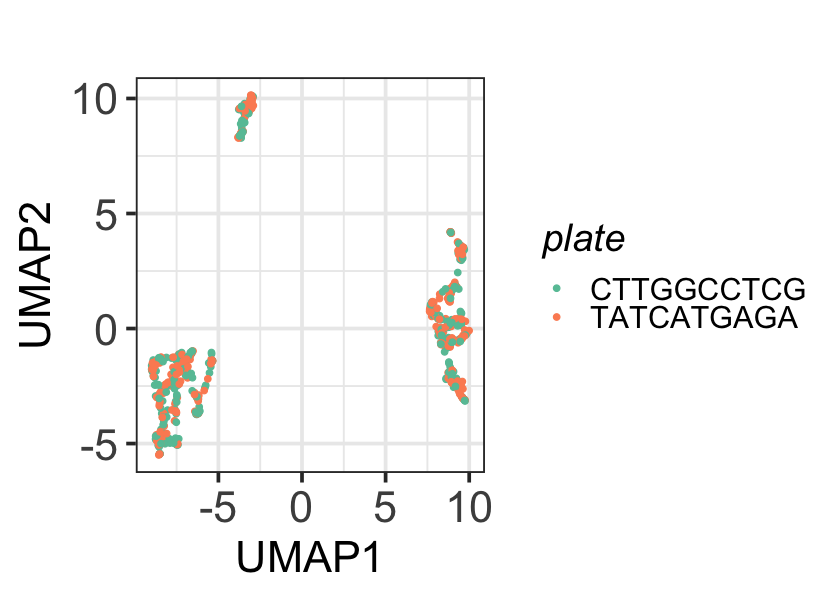

In [48]:
fig.size(5, 7)
ggplot(meta_umap %>% sample_n(nrow(meta_umap)))+
    geom_point(aes(x = UMAP1, y = UMAP2, col = plate))+
    theme_gy()+
    ggtitle('') + scale_color_brewer(palette = "Set2")

## ADT

Transposing data matrix

Initializing state using k-means centroids initialization

Harmony 1/10

Harmony 2/10

Harmony 3/10

Harmony converged after 3 iterations

Found more than one class "dist" in cache; using the first, from namespace 'spam'

Also defined by ‘BiocGenerics’

Found more than one class "dist" in cache; using the first, from namespace 'spam'

Also defined by ‘BiocGenerics’

Found more than one class "dist" in cache; using the first, from namespace 'spam'

Also defined by ‘BiocGenerics’



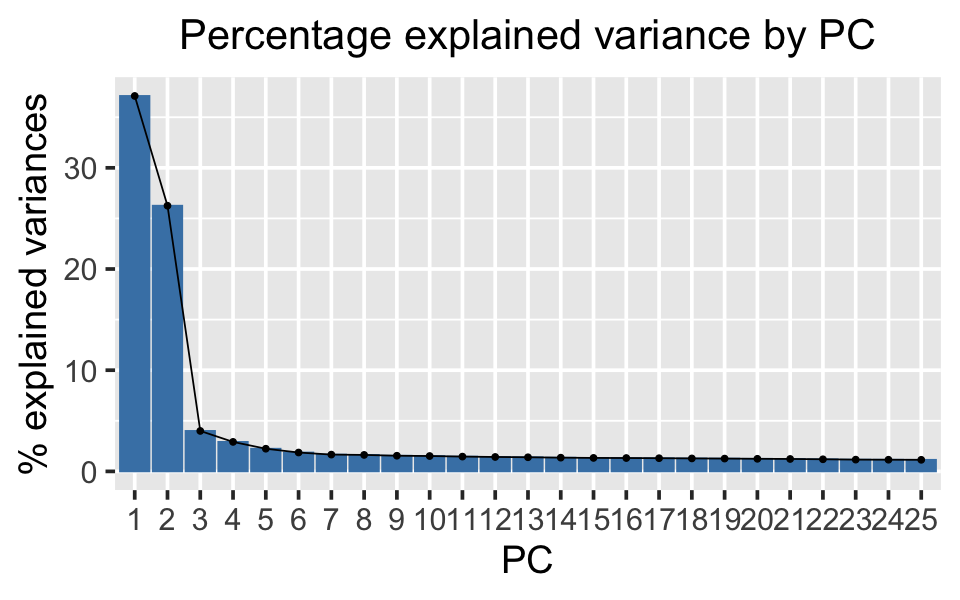

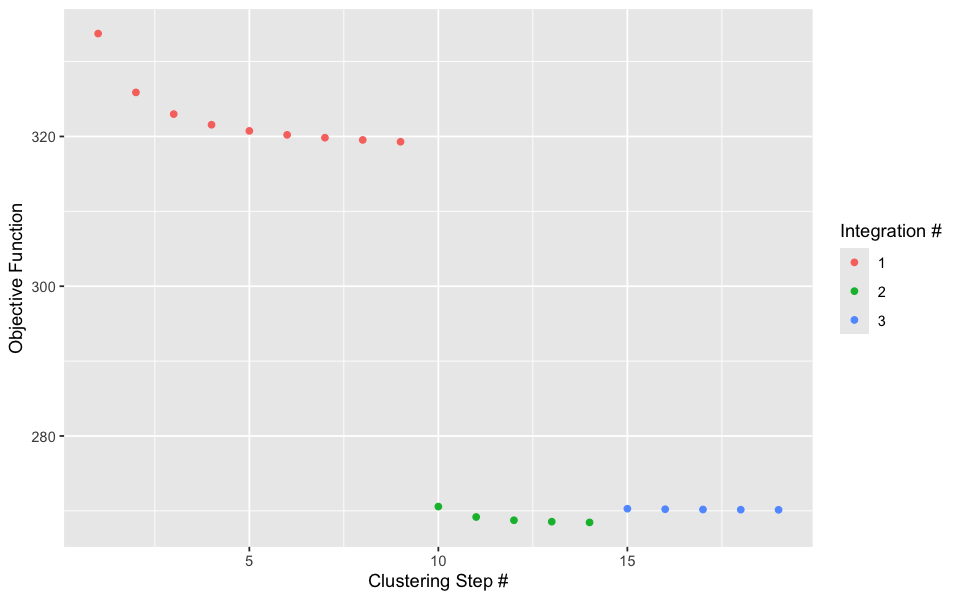

In [51]:
meta_umap_adt = pca_umap(scale_adt, meta_ADT_filt, harmony_var = 'plate')

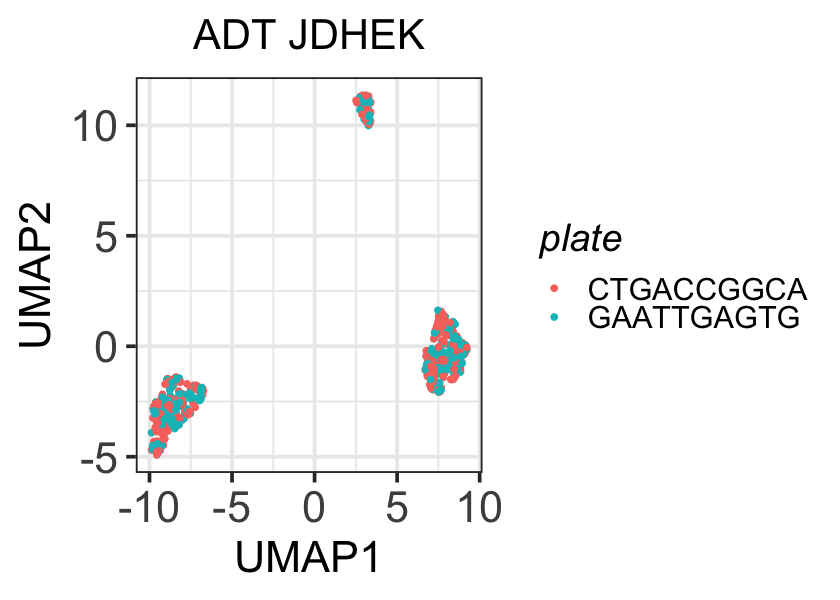

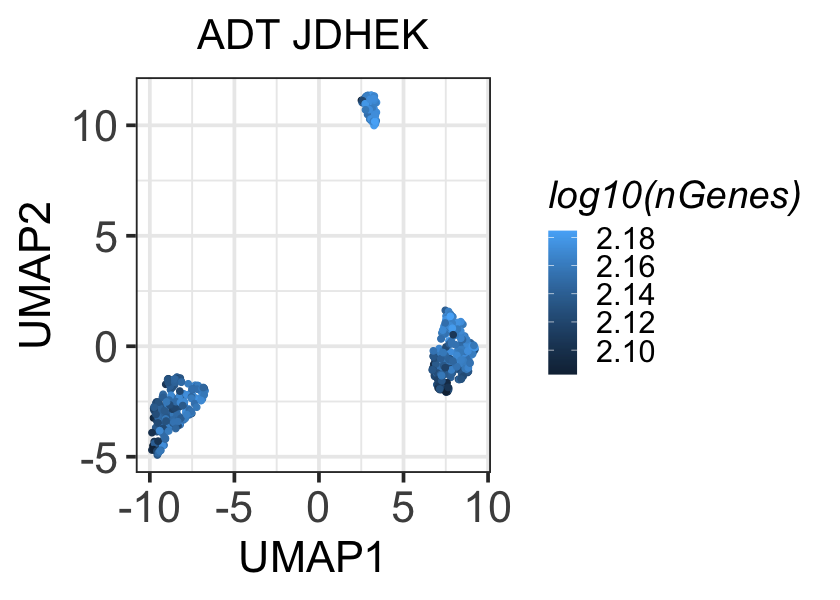

In [55]:
fig.size(5, 7)
ggplot(meta_umap_adt %>% sample_n(nrow(meta_umap_adt)))+
    geom_point(aes(x = UMAP1, y = UMAP2, col = plate))+
    theme_gy()+
    ggtitle('ADT JDHEK')

fig.size(5, 7)
ggplot(meta_umap_adt %>% sample_n(nrow(meta_umap_adt)))+
    geom_point(aes(x = UMAP1, y = UMAP2, col = log10(nGenes)))+
    theme_gy()+
    ggtitle('ADT JDHEK')

# Clustering + DGE

In [56]:
meta_umap.clust = do_cluster(meta_umap, resolution_list = seq(0.05, 0.5, 0.05))
table(meta_umap.clust$`res.0.1`)

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 557
Number of edges: 15671

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9804
Number of communities: 3
Elapsed time: 0 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 557
Number of edges: 15671

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9611
Number of communities: 3
Elapsed time: 0 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 557
Number of edges: 15671

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9419
Number of communities: 3
Elapsed time: 0 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 557
Number of edges: 15671

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9228
Number of communities: 4
Elapsed time: 0 seconds
Modularity Optimizer version


  0   1   2 
249 239  69 

In [57]:
meta_umap.clust$cluster = meta_umap.clust$`res.0.1`

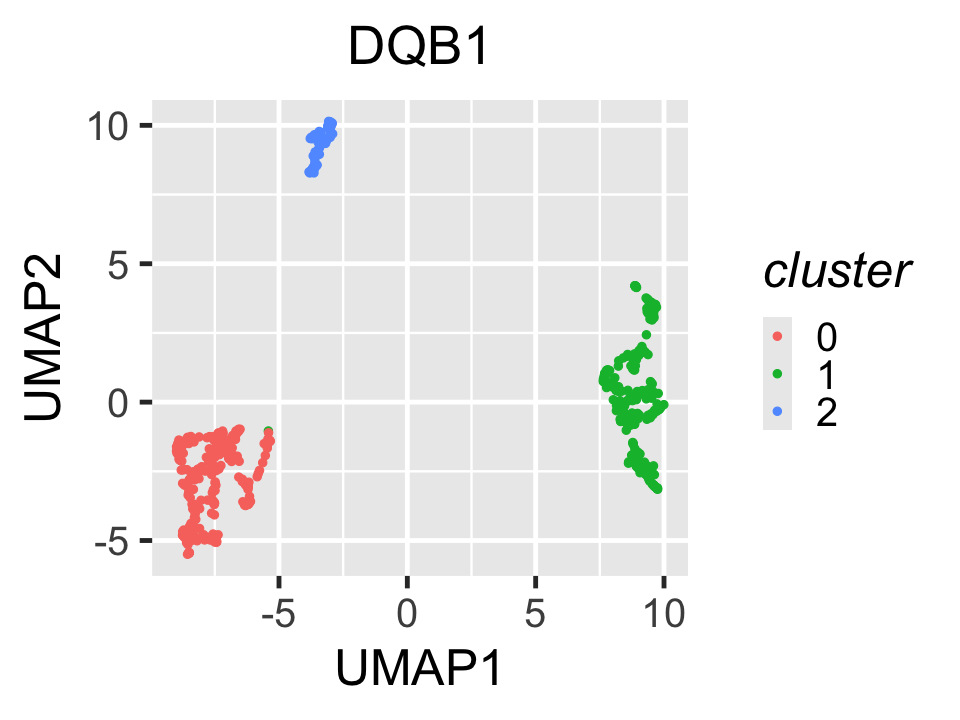

In [58]:
fig.size(6, 8)
ggplot(meta_umap.clust[sample(rownames(meta_umap.clust)), ])+
    geom_point(aes(x= UMAP1, y = UMAP2, col = cluster), size = 2)+
    theme_g(30)+
    ggtitle('DQB1')

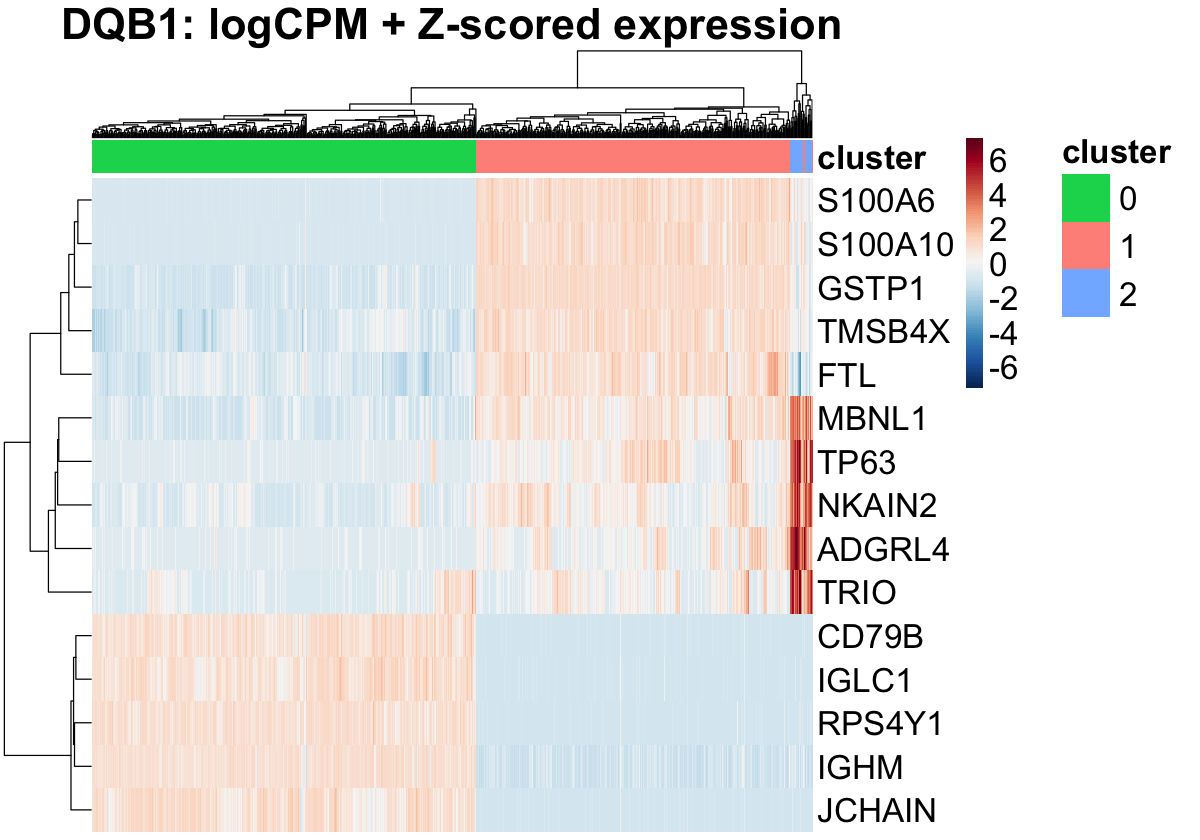

In [142]:
dge_DQB1 = wilcoxauc(scale_exprs_DQB1, meta_umap_DQB1.clust$cluster)

var_genes_DQB1 = top_markers(dge_DQB1, 5) %>% head(5) %>% select(-rank) %>% 
                        unlist %>% unique 
cmax = abs(scale_exprs_DQB1[var_genes_DQB1, ]) %>% unlist %>% max #%>% quantile(.995)

# Data frame with column annotations.
mat_col <- data.frame(cluster = meta_umap_DQB1.clust$cluster)
rownames(mat_col) <- rownames(meta_umap_DQB1.clust)


# Sort dendogram
mat_cluster_cols <- hclust(dist(t(scale_exprs_DQB1[var_genes_DQB1, ])))
mat_cluster_cols <- sort_hclust(mat_cluster_cols)
mat_cluster_rows <- sort_hclust(hclust(dist(scale_exprs_DQB1[var_genes_DQB1, ])))

fig.size(7, 10)
pheatmap(scale_exprs_DQB1[c(var_genes_DQB1,"HLA-DQB1"), ],
         main = 'DQB1: logCPM + Z-scored expression',
         breaks = seq(-cmax, cmax, length.out = 100),
        color = colorRampPalette(brewer.pal(11, "RdBu"))(100) %>% rev,
        show_colnames = FALSE,
         annotation_col = mat_col, fontsize = 20,
       cluster_cols= mat_cluster_cols,
        cluster_rows = mat_cluster_rows,

        )

### ADT

In [143]:
meta_umap_adt_DQB1.clust = do_cluster(meta_umap_adt_DQB1, resolution_list = seq(0.1, 1, 0.1))

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 808
Number of edges: 31989

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9496
Number of communities: 2
Elapsed time: 0 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 808
Number of edges: 31989

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8994
Number of communities: 2
Elapsed time: 0 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 808
Number of edges: 31989

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8580
Number of communities: 3
Elapsed time: 0 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 808
Number of edges: 31989

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8218
Number of communities: 3
Elapsed time: 0 seconds
Modularity Optimizer version

In [144]:
meta_umap_adt_DQB1.clust$cluster = meta_umap_adt_DQB1.clust$`res.0.1`

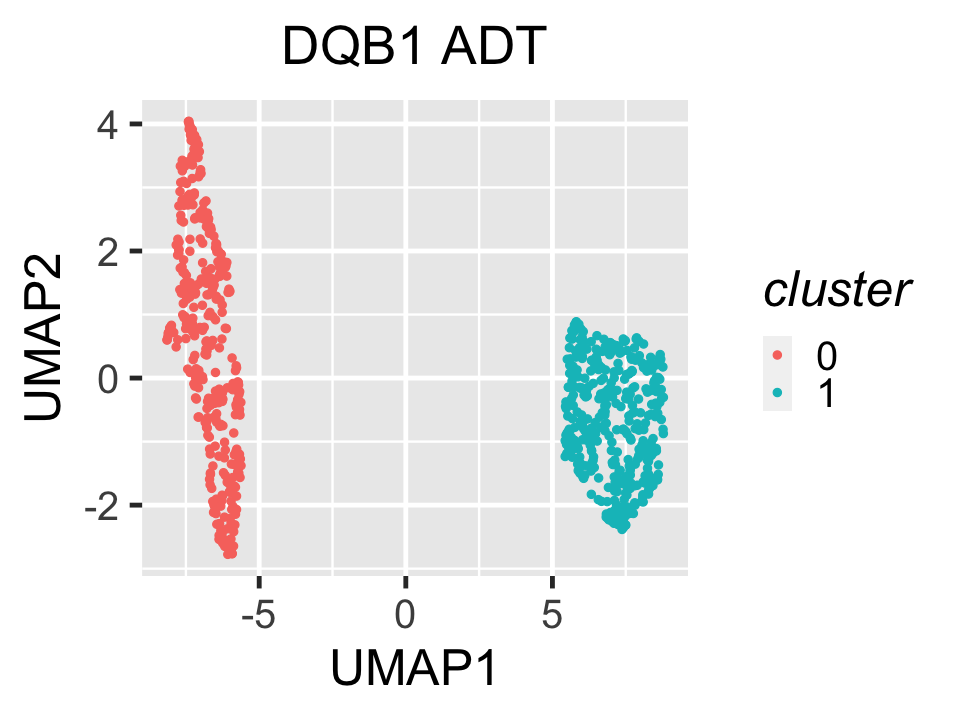

In [145]:
fig.size(6, 8)
ggplot(meta_umap_adt_DQB1.clust[sample(rownames(meta_umap_adt_DQB1.clust)), ])+
    geom_point(aes(x= UMAP1, y = UMAP2, col = cluster), size = 2)+
    theme_g(30)+
    ggtitle('DQB1 ADT')

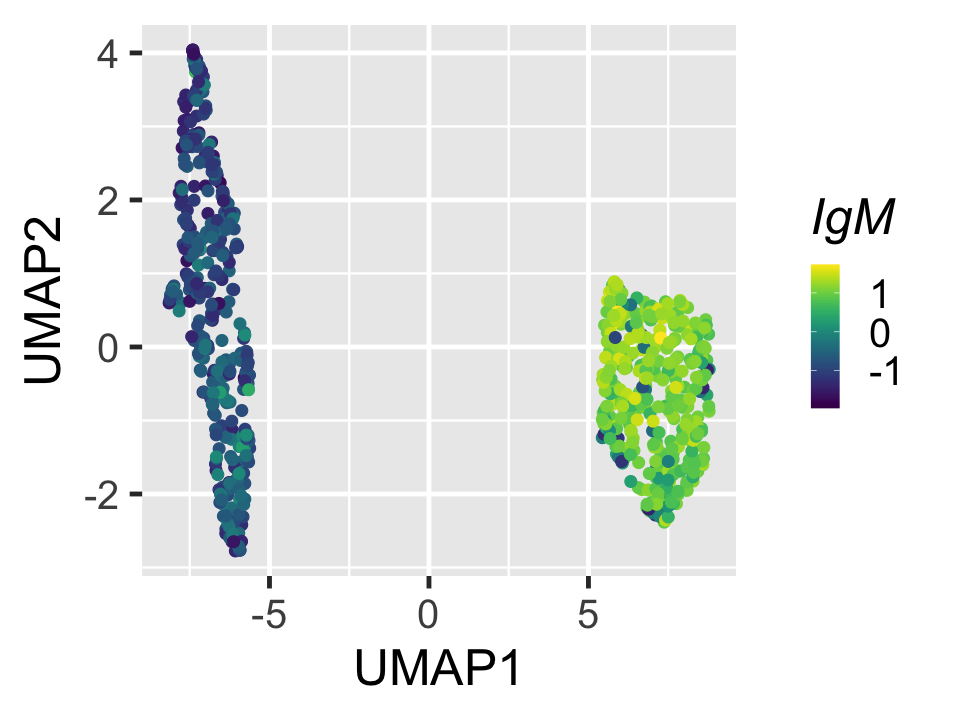

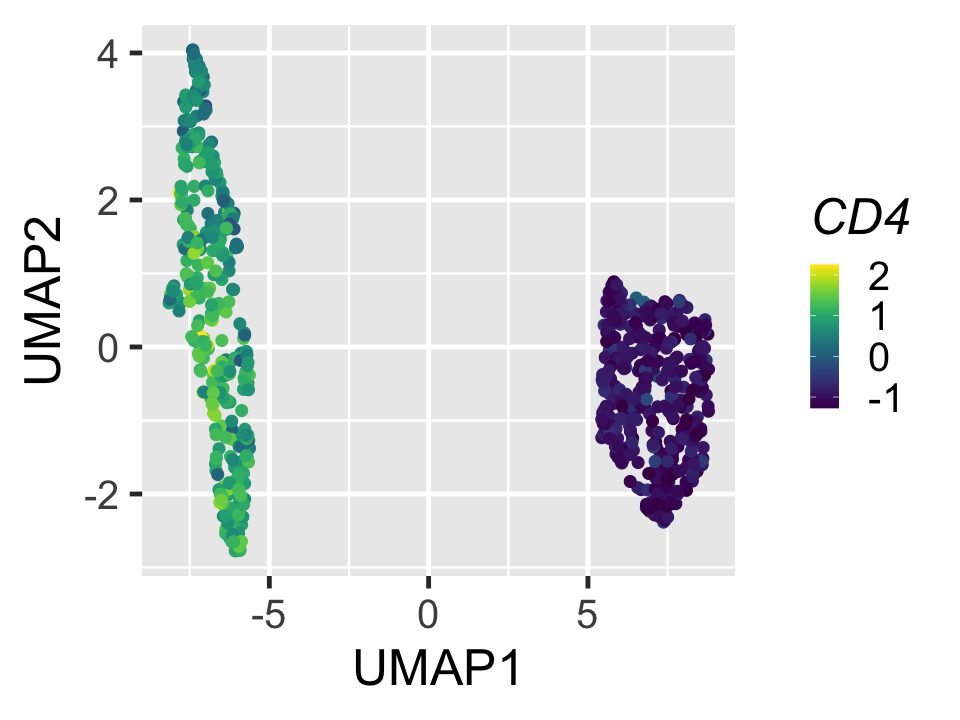

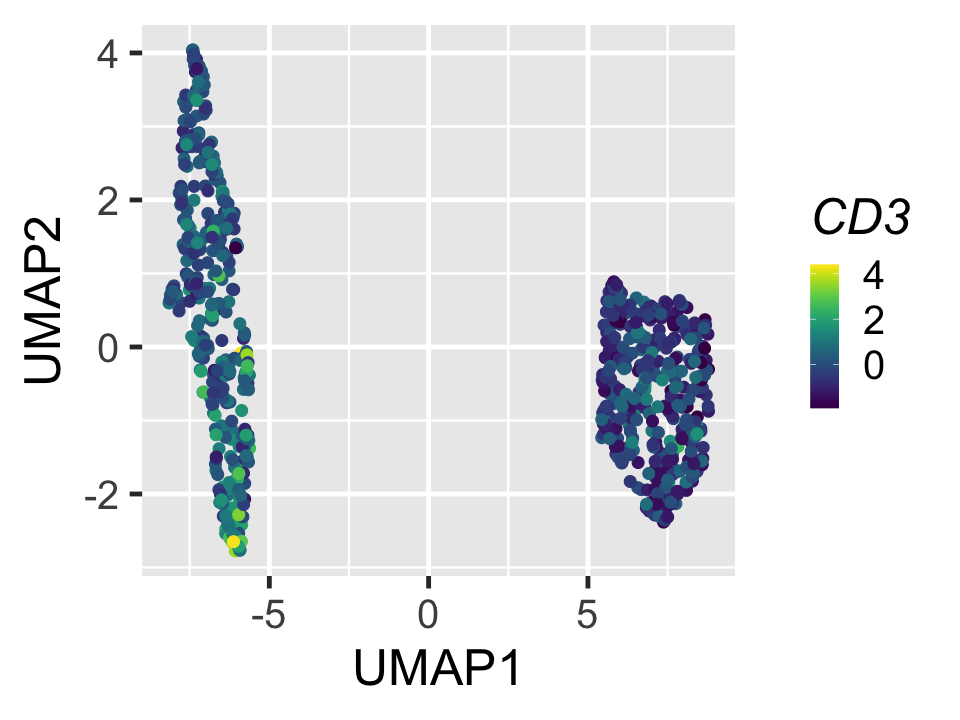

In [146]:
plot_exprs(scale_adt_DQB1, meta_umap_adt_DQB1, c("IgM", "CD4", "CD3"))

In [147]:
intersect(rownames(meta_umap_DQB1),
         rownames(meta_umap_adt_DQB1)) %>% length

[1] 808

In [148]:
# Compare cluster concordance in RNA vs protein
intersect_cells = intersect(rownames(meta_umap_adt_DQB1.clust), rownames(meta_umap_DQB1.clust))
concordance_RNAprot_DQB1 = table(meta_umap_adt_DQB1.clust[intersect_cells, 'cluster'],
                                 meta_umap_DQB1.clust[intersect_cells, 'cluster']) %>% as.data.frame

In [149]:
# # Order clusters in plot
# concordance_RNAprot_DQB1$Var2 = factor(concordance_RNAprot_DQB1$Var2, 
#                                        levels = unique(concordance_RNAprot_DQB1$Var2))
# concordance_RNAprot_DQB1$Var1 = factor(concordance_RNAprot_DQB1$Var1, 
#                                        levels = unique(concordance_RNAprot_DQB1$Var1))

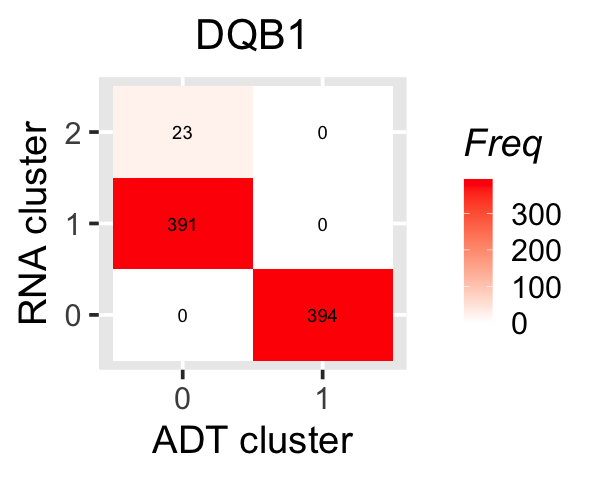

In [150]:
# Compare cluster concordance in RNA vs protein
intersect_cells = intersect(rownames(meta_umap_adt_DQB1.clust), rownames(meta_umap_DQB1.clust))
concordance_RNAprot_DQB1 = table(meta_umap_adt_DQB1.clust[intersect_cells, 'cluster'],
                                 meta_umap_DQB1.clust[intersect_cells, 'cluster']) %>% as.data.frame

fig.size(4, 5)
ggplot(concordance_RNAprot_DQB1)+
    geom_tile(aes(x = Var1, y = Var2, fill = Freq))+
    geom_text(aes(x = Var1, y = Var2, label = Freq)) +
    scale_fill_gradient(low = "white", high = "red")+
    theme_g()+
    xlab('ADT cluster')+
    ylab('RNA cluster')+
    ggtitle('DQB1')

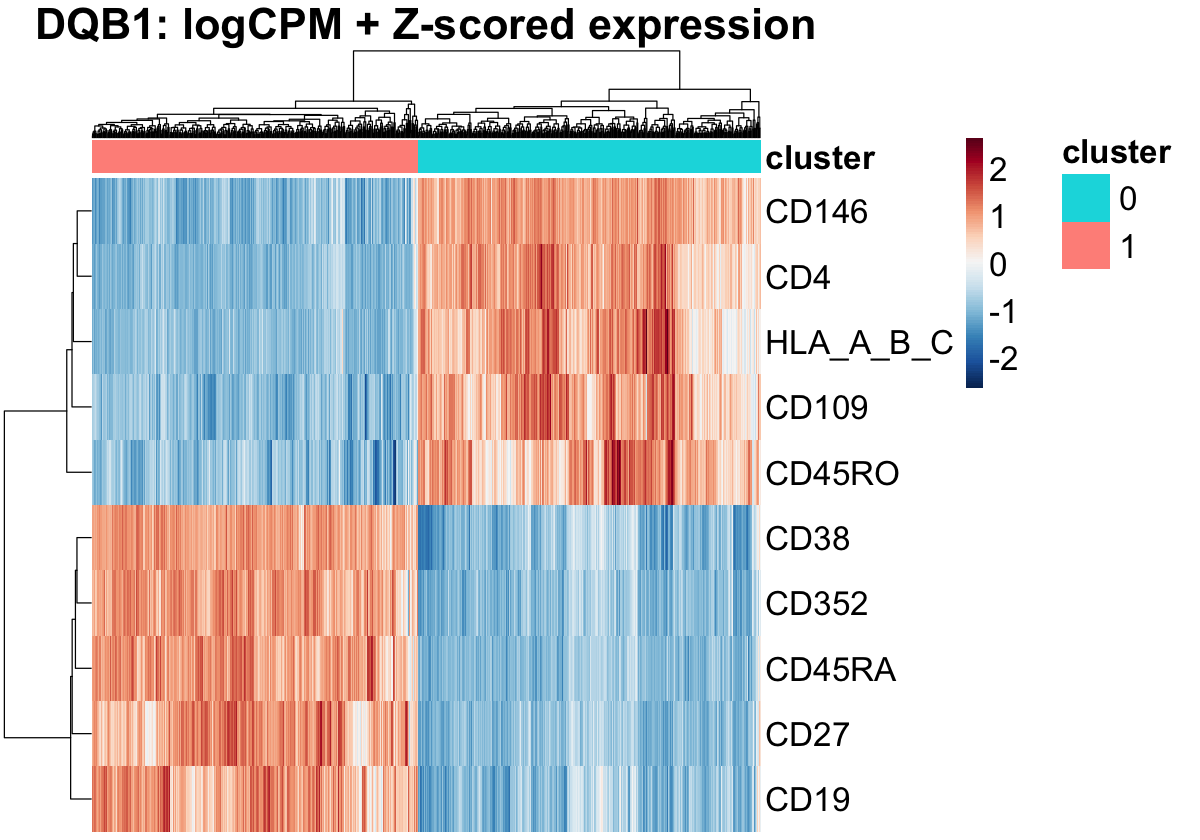

In [151]:
#Heatmap of variable genes
dge_DQB1 = wilcoxauc(scale_adt_DQB1, meta_umap_adt_DQB1.clust$cluster)
var_genes_DQB1 = top_markers(dge_DQB1, 5) %>% head(5) %>% select(-rank) %>% 
                        unlist %>% unique 
cmax = abs(scale_adt_DQB1[var_genes_DQB1, ]) %>% unlist %>% max #%>% quantile(.995)

# Data frame with column annotations.
mat_col <- data.frame(cluster = meta_umap_adt_DQB1.clust$cluster)
rownames(mat_col) <- rownames(meta_umap_adt_DQB1.clust)


# Sort dendogram
mat_cluster_cols <- hclust(dist(t(scale_adt_DQB1[var_genes_DQB1, ])))
mat_cluster_cols <- sort_hclust(mat_cluster_cols)
mat_cluster_rows <- sort_hclust(hclust(dist(scale_adt_DQB1[var_genes_DQB1, ])))
fig.size(7, 10)
pheatmap(scale_adt_DQB1[c(var_genes_DQB1), ],
         main = 'DQB1: logCPM + Z-scored expression',
         breaks = seq(-cmax, cmax, length.out = 100),
        color = colorRampPalette(brewer.pal(11, "RdBu"))(100) %>% rev,
        show_colnames = FALSE,
         annotation_col = mat_col, fontsize = 20,
       cluster_cols= mat_cluster_cols,
        cluster_rows = mat_cluster_rows,

        )

In [152]:
meta_umap_FBXO11.clust = do_cluster(meta_umap_FBXO11, resolution_list = seq(0.1, 1, 0.1))

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 1270
Number of edges: 40809

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9497
Number of communities: 2
Elapsed time: 0 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 1270
Number of edges: 40809

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9073
Number of communities: 4
Elapsed time: 0 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 1270
Number of edges: 40809

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8777
Number of communities: 5
Elapsed time: 0 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 1270
Number of edges: 40809

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8535
Number of communities: 6
Elapsed time: 0 seconds
Modularity Optimizer ver

In [153]:
table(meta_umap_FBXO11.clust$'res.0.1')


  0   1 
704 566 

In [154]:
meta_umap_FBXO11.clust$cluster = meta_umap_FBXO11.clust$`res.0.1`

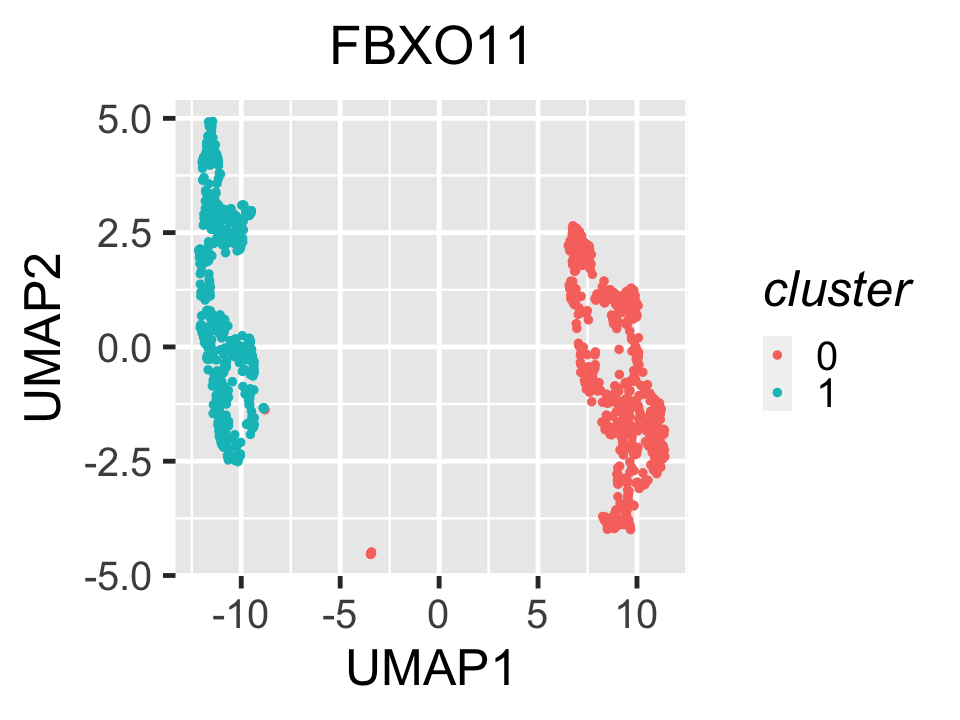

In [155]:
fig.size(6, 8)
ggplot(meta_umap_FBXO11.clust[sample(rownames(meta_umap_FBXO11.clust)), ])+
    geom_point(aes(x= UMAP1, y = UMAP2, col = cluster), size = 2)+
    theme_g(30)+
    ggtitle('FBXO11')

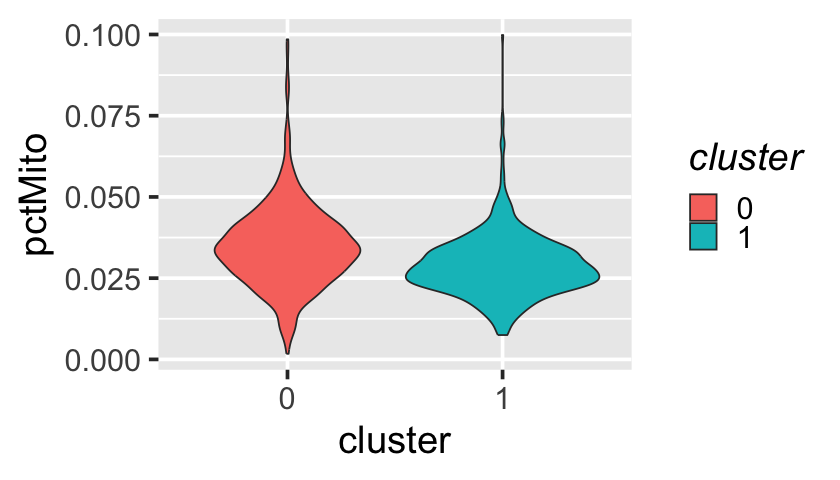

In [156]:
fig.size(4, 7)
ggplot(meta_umap_FBXO11.clust )+
    geom_violin(aes(x = cluster, y = pctMito, fill = cluster))+
    theme_g()

In [157]:
dge_FBXO11 = wilcoxauc(scale_exprs_FBXO11, meta_umap_FBXO11.clust$cluster)

In [158]:
var_genes_FBXO11 = top_markers(dge_FBXO11, 5) %>% head(5) %>% select(-rank) %>% 
                        unlist %>% unique 

cmax = abs(scale_exprs_FBXO11[var_genes_FBXO11, ]) %>% unlist %>% max #%>% quantile(.995)

# Data frame with column annotations.
mat_col <- data.frame(cluster = meta_umap_FBXO11.clust$cluster)
rownames(mat_col) <- rownames(meta_umap_FBXO11.clust)

# Sort dendogram
mat_cluster_cols <- hclust(dist(t(scale_exprs_FBXO11[var_genes_FBXO11, ])))
mat_cluster_cols <- sort_hclust(mat_cluster_cols)
mat_cluster_rows <- sort_hclust(hclust(dist(scale_exprs_FBXO11[var_genes_FBXO11, ])))

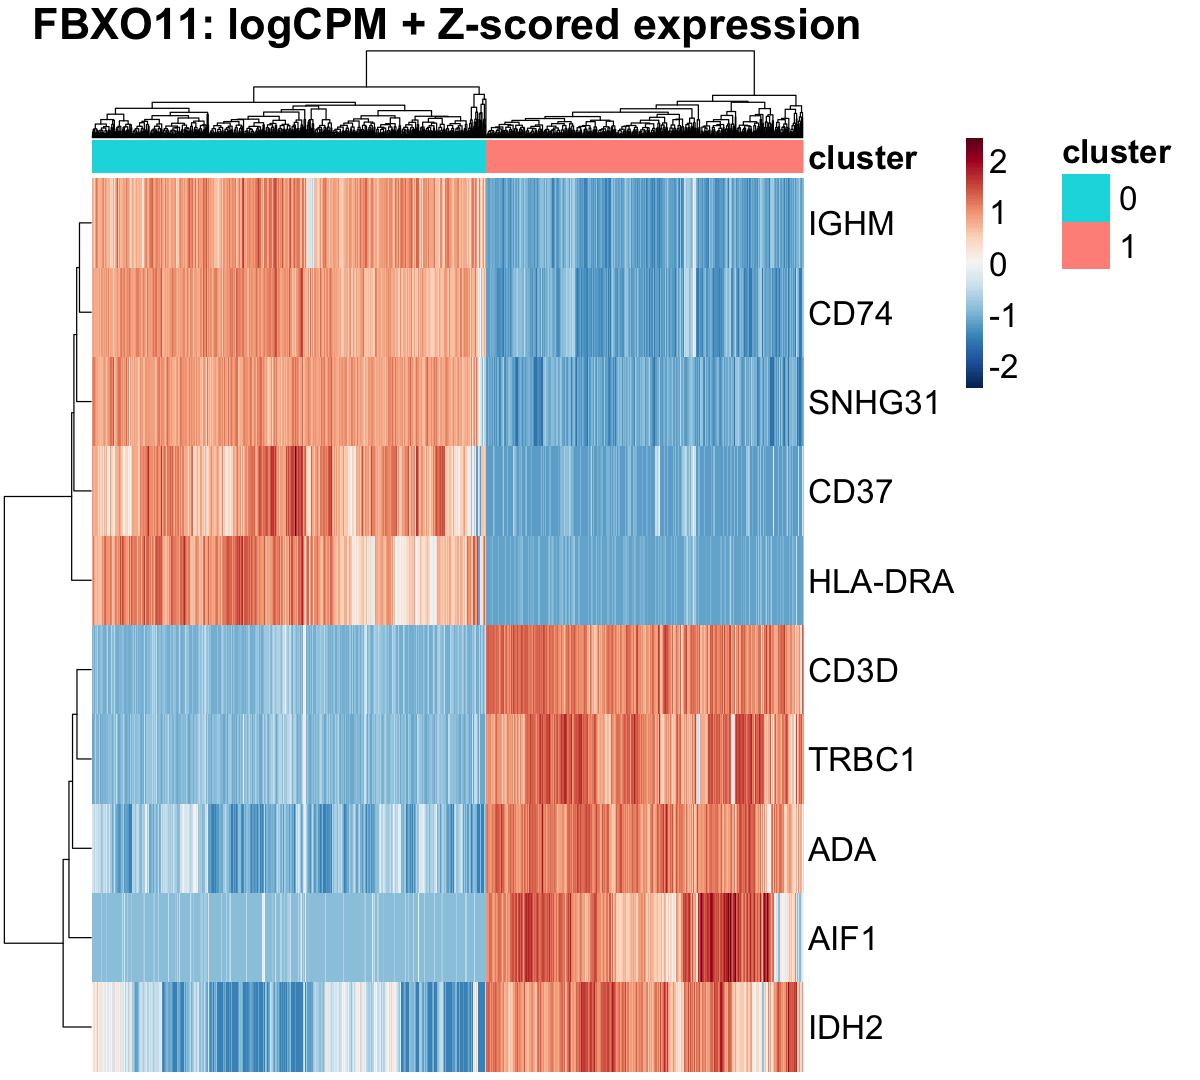

In [159]:
fig.size(9, 10)
pheatmap(scale_exprs_FBXO11[var_genes_FBXO11, ],
         main = 'FBXO11: logCPM + Z-scored expression',
         breaks = seq(-cmax, cmax, length.out = 100),
        color = colorRampPalette(brewer.pal(11, "RdBu"))(100) %>% rev,
        show_colnames = FALSE,
         annotation_col = mat_col, fontsize = 20,
       cluster_cols= mat_cluster_cols,
        cluster_rows = mat_cluster_rows,

        )

In [160]:
### Quick Heatmap / Volcano Plot Comparing the Genotypes


### ADT

In [161]:
meta_umap_adt_FBXO11.clust = do_cluster(meta_umap_adt_FBXO11, resolution_list = seq(0.1, 1, 0.1))

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 1224
Number of edges: 48093

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9495
Number of communities: 2
Elapsed time: 0 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 1224
Number of edges: 48093

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8990
Number of communities: 2
Elapsed time: 0 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 1224
Number of edges: 48093

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8485
Number of communities: 2
Elapsed time: 0 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 1224
Number of edges: 48093

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.7980
Number of communities: 2
Elapsed time: 0 seconds
Modularity Optimizer ver

In [162]:
table(meta_umap_adt_FBXO11.clust$'res.0.1')


  0   1 
687 537 

In [163]:
meta_umap_adt_FBXO11.clust$cluster = meta_umap_adt_FBXO11.clust$`res.0.1`

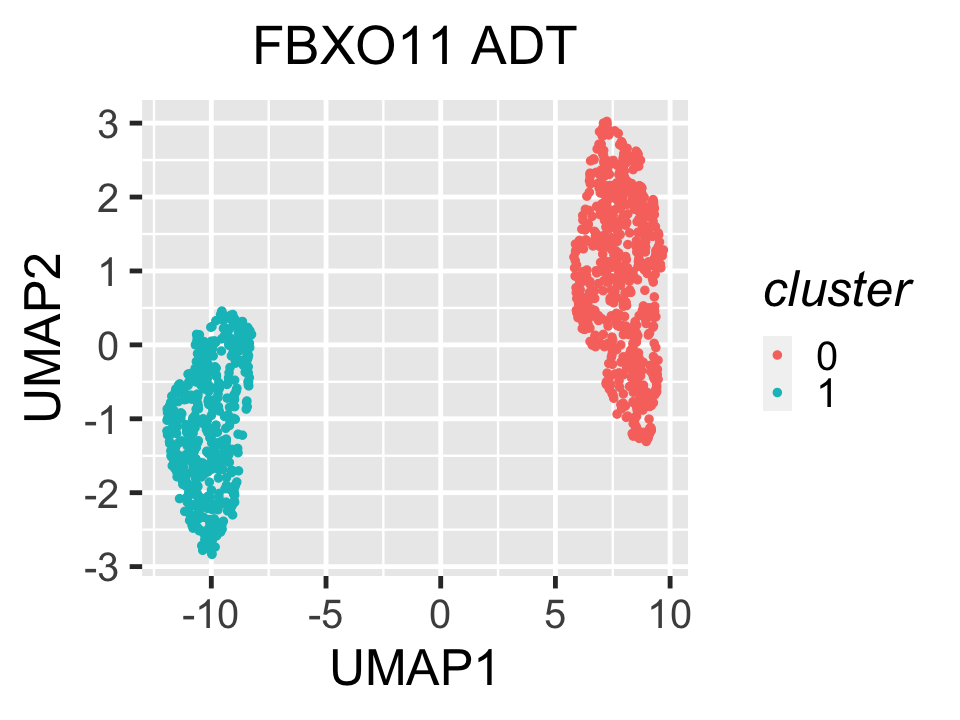

In [164]:
fig.size(6, 8)
ggplot(meta_umap_adt_FBXO11.clust[sample(rownames(meta_umap_adt_FBXO11.clust)), ])+
    geom_point(aes(x= UMAP1, y = UMAP2, col = cluster), size = 2)+
    theme_g(30)+
    ggtitle('FBXO11 ADT')

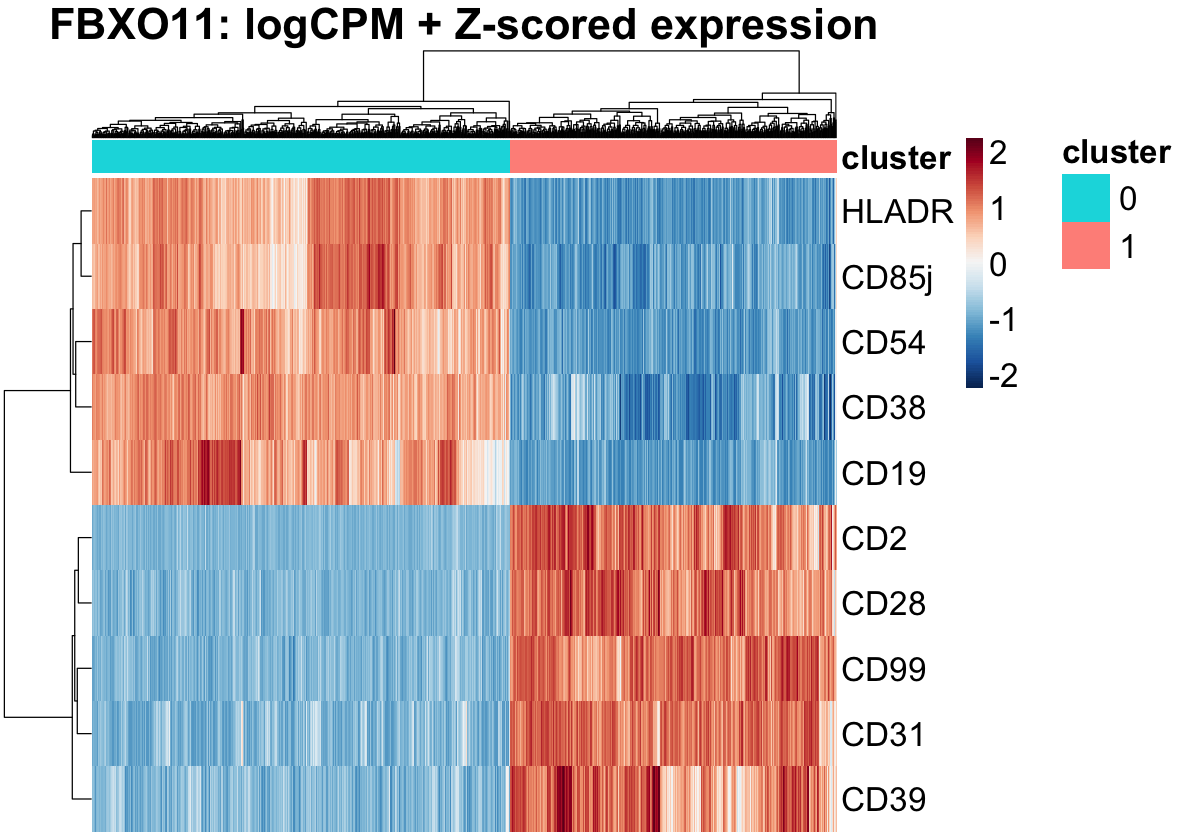

In [165]:
dge_DQB1 = wilcoxauc(scale_adt_FBXO11, meta_umap_adt_FBXO11.clust$cluster)
var_genes_DQB1 = top_markers(dge_DQB1, 5) %>% head(5) %>% select(-rank) %>% 
                        unlist %>% unique 
cmax = abs(scale_adt_FBXO11[var_genes_DQB1, ]) %>% unlist %>% max #%>% quantile(.995)

# Data frame with column annotations.
mat_col <- data.frame(cluster = meta_umap_adt_FBXO11.clust$cluster)
rownames(mat_col) <- rownames(meta_umap_adt_FBXO11.clust)


# Sort dendogram
mat_cluster_cols <- hclust(dist(t(scale_adt_FBXO11[var_genes_DQB1, ])))
mat_cluster_cols <- sort_hclust(mat_cluster_cols)
mat_cluster_rows <- sort_hclust(hclust(dist(scale_adt_FBXO11[var_genes_DQB1, ])))
fig.size(7, 10)
pheatmap(scale_adt_FBXO11[c(var_genes_DQB1), ],
         main = 'FBXO11: logCPM + Z-scored expression',
         breaks = seq(-cmax, cmax, length.out = 100),
        color = colorRampPalette(brewer.pal(11, "RdBu"))(100) %>% rev,
        show_colnames = FALSE,
         annotation_col = mat_col, fontsize = 20,
       cluster_cols= mat_cluster_cols,
        cluster_rows = mat_cluster_rows,

        )

In [166]:
intersect(rownames(meta_umap_FBXO11),
         rownames(meta_umap_adt_FBXO11)) %>% length

[1] 1224

In [167]:
# Compare cluster concordance in RNA vs protein
intersect_cells = intersect(rownames(meta_umap_adt_FBXO11.clust), rownames(meta_umap_FBXO11.clust))
concordance_RNAprot_FBXO11 = table(meta_umap_adt_FBXO11.clust[intersect_cells, 'cluster'],
                                 meta_umap_FBXO11.clust[intersect_cells, 'cluster']) %>% as.data.frame

In [168]:
concordance_RNAprot_FBXO11$Var2

[1] 0 0 1 1
Levels: 0 1

In [169]:
# Order clusters in plot
concordance_RNAprot_FBXO11$Var2 = factor(concordance_RNAprot_FBXO11$Var2, 
                                       levels = c(2, 1, 0))
concordance_RNAprot_FBXO11$Var1 = factor(concordance_RNAprot_FBXO11$Var1, 
                                       levels = c(0, 1))

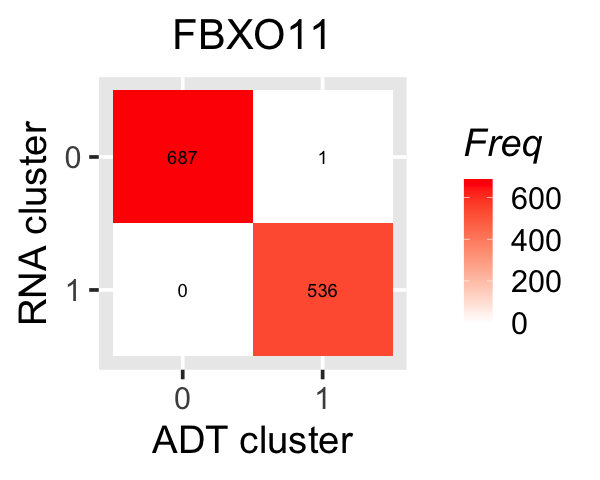

In [170]:
fig.size(4, 5)
ggplot(concordance_RNAprot_FBXO11)+
    geom_tile(aes(x = Var1, y = Var2, fill = Freq))+
    geom_text(aes(x = Var1, y = Var2, label = Freq)) +
    scale_fill_gradient(low = "white", high = "red")+
    theme_g()+
    xlab('ADT cluster')+
    ylab('RNA cluster')+
    ggtitle('FBXO11')

## RNA

In [59]:
meta_umap.clust = do_cluster(meta_umap, resolution_list = seq(0.1, 1, 0.1))

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 557
Number of edges: 15671

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9611
Number of communities: 3
Elapsed time: 0 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 557
Number of edges: 15671

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9228
Number of communities: 4
Elapsed time: 0 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 557
Number of edges: 15671

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8902
Number of communities: 5
Elapsed time: 0 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 557
Number of edges: 15671

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8622
Number of communities: 5
Elapsed time: 0 seconds
Modularity Optimizer version

In [61]:
table(meta_umap.clust$'res.0.1')


  0   1   2 
249 239  69 

In [80]:
#Assign Cluster
meta_umap.clust$cluster = meta_umap.clust$`res.0.1`

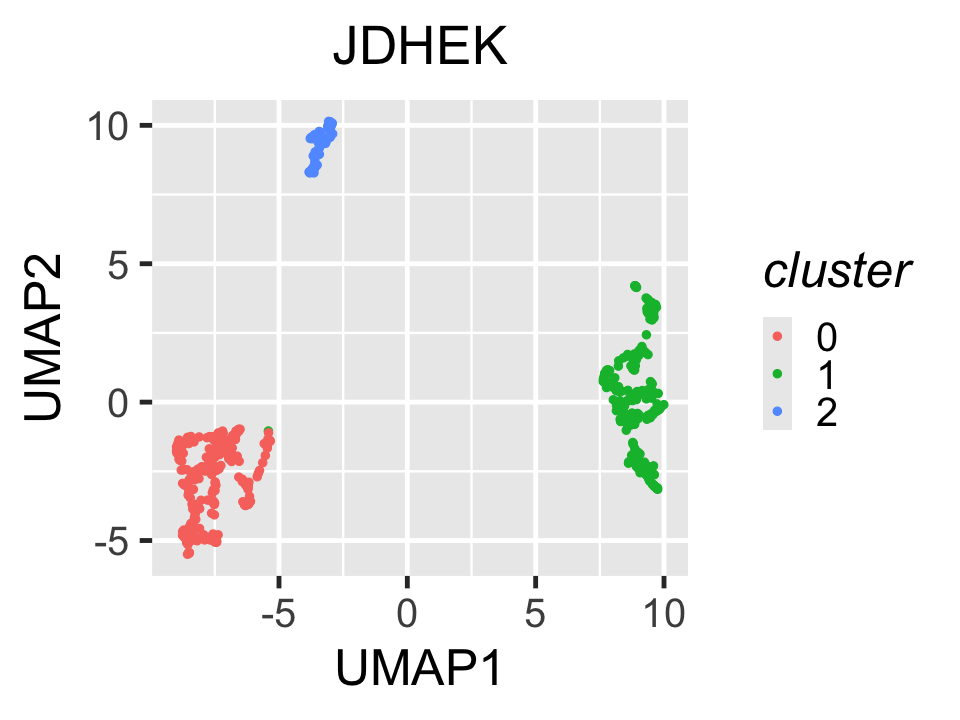

In [64]:
fig.size(6, 8)
ggplot(meta_umap.clust[sample(rownames(meta_umap.clust)), ])+
    geom_point(aes(x= UMAP1, y = UMAP2, col = cluster), size = 2)+
    theme_g(30)+
    ggtitle('JDHEK')

In [65]:
#test DGE
DGE = wilcoxauc(scale_exprs, meta_umap.clust$cluster)

In [66]:
top_markers(DGE, 50) %>% head(10)


rank 0       1        2     
1   1   TRBC1   CD37     CKB   
2   2   ADA     SNHG31   TSPO  
3   3   CD3D    CD74     UCHL1 
4   4   LCK     IGKC     CALD1 
5   5   AIF1    HLA-DRA  CSRP2 
6   6   IDH2    IGLC1    PLS3  
7   7   GYPC    TCL1A    RASAL2
8   8   CD3E    HLA-DPA1 GAL   
9   9   ARHGDIB IGHM     PERP  
10 10   PGK1    CD79B    TCEAL4

### ADT

In [67]:
meta_umap_adt.clust = do_cluster(meta_umap_adt, resolution_list = seq(0.1, 1, 0.1))

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 526
Number of edges: 20853

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9618
Number of communities: 3
Elapsed time: 0 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 526
Number of edges: 20853

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9237
Number of communities: 3
Elapsed time: 0 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 526
Number of edges: 20853

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8856
Number of communities: 3
Elapsed time: 0 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 526
Number of edges: 20853

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8475
Number of communities: 3
Elapsed time: 0 seconds
Modularity Optimizer version

In [68]:
table(meta_umap_adt.clust$'res.0.1')


  0   1   2 
232 225  69 

In [69]:
meta_umap_adt.clust$cluster = meta_umap_adt.clust$`res.0.1`

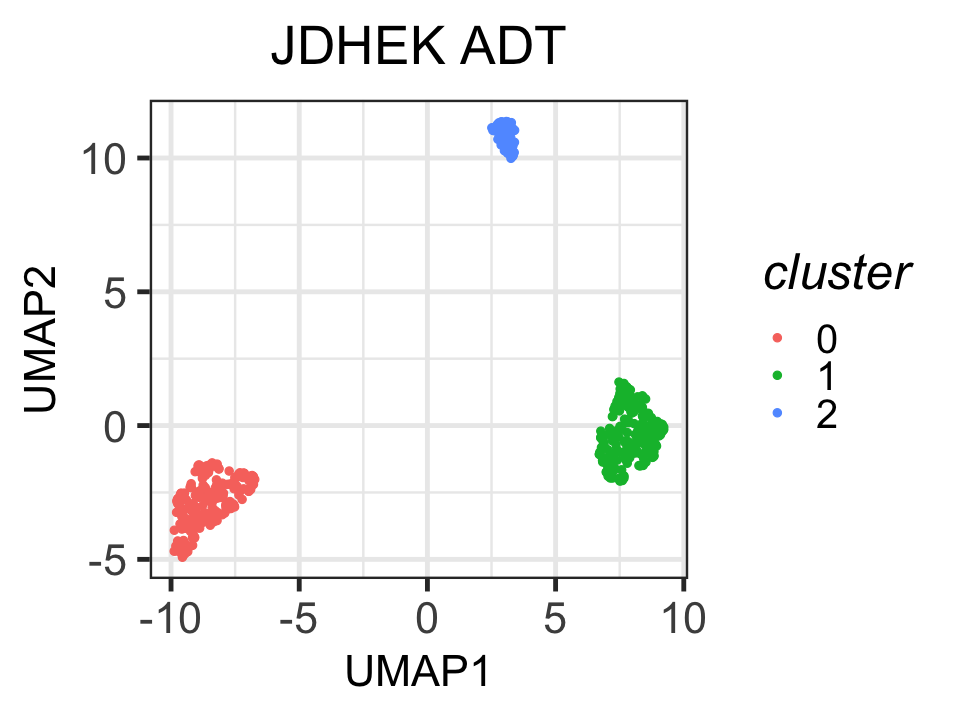

In [70]:
fig.size(6, 8)
ggplot(meta_umap_adt.clust[sample(rownames(meta_umap_adt.clust)), ])+
    geom_point(aes(x= UMAP1, y = UMAP2, col = cluster), size = 2)+
    theme_gy(30)+
    ggtitle('JDHEK ADT')

In [72]:
#Overlapping cells
intersect(rownames(meta_umap),
         rownames(meta_umap_adt)) %>% length

[1] 526

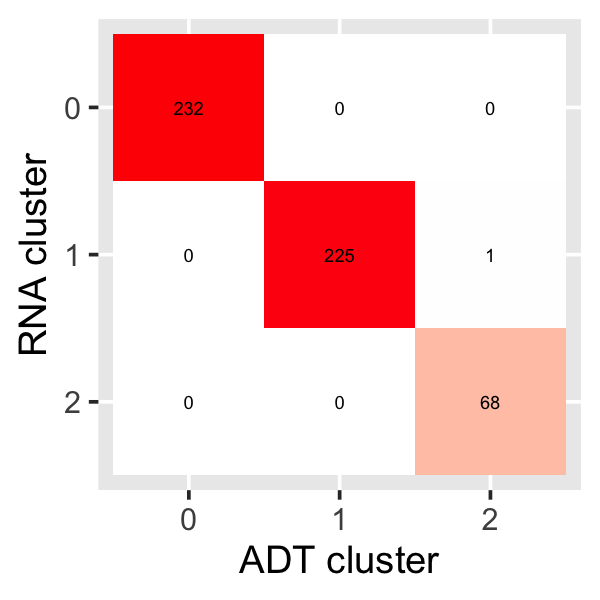

In [73]:
# Compare cluster concordance in RNA vs protein
intersect_cells = intersect(rownames(meta_umap_adt.clust), rownames(meta_umap.clust))
concordance_RNAprot = table(meta_umap_adt.clust[intersect_cells, 'cluster'],
                                 meta_umap.clust[intersect_cells, 'cluster']) %>% as.data.frame

# Order clusters in plot
concordance_RNAprot$Var2 = factor(concordance_RNAprot$Var2, 
                                       levels = c(2, 1, 0))
concordance_RNAprot$Var1 = factor(concordance_RNAprot$Var1, 
                                       levels = c(0, 1, 2))

fig.size(5, 5)
ggplot(concordance_RNAprot)+
    geom_tile(aes(x = Var1, y = Var2, fill = Freq))+
    geom_text(aes(x = Var1, y = Var2, label = Freq)) +
    scale_fill_gradient(low = "white", high = "red")+
    theme_g()+
    xlab('ADT cluster')+
    ylab('RNA cluster') + theme(legend.position = "none")

In [74]:
#Check key markers and genes
plot_exprs <- function (scale_exprs, meta_umap, markers, fig_size = c(6, 8)) 
{
    exprs_umap = cbind(meta_umap, scale_exprs[, rownames(meta_umap)] %>% 
        t)
    fig.size(fig_size[1], fig_size[2])
    for (marker in markers) {
        print(ggplot(exprs_umap) + geom_point(aes(x = UMAP1, 
            y = UMAP2, col = eval(parse(text = marker))), size = 3) + 
            labs(col = marker) + theme_g(30) + scale_color_viridis() + theme_gy())
    }
}

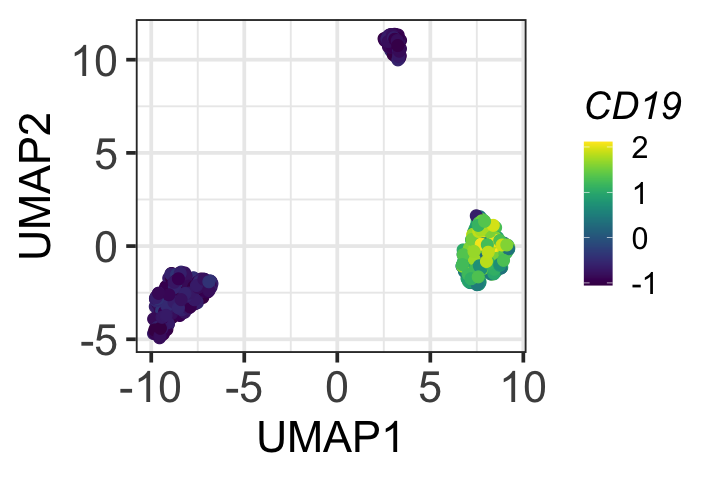

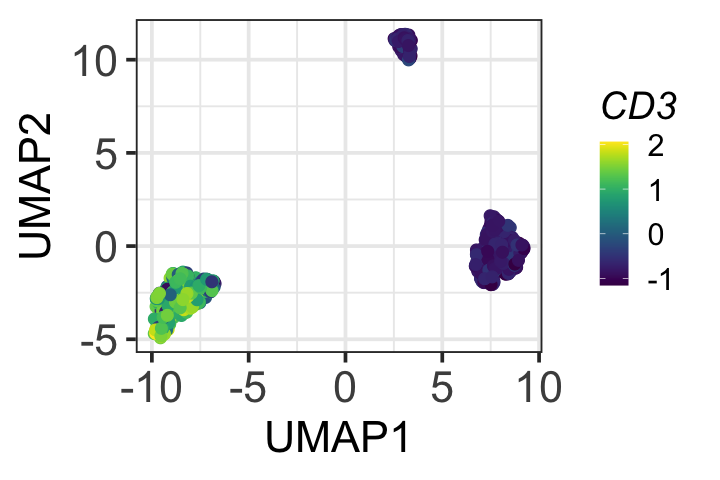

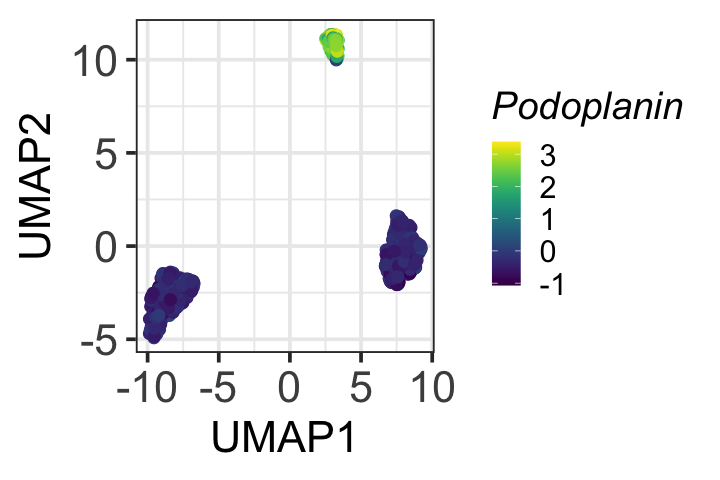

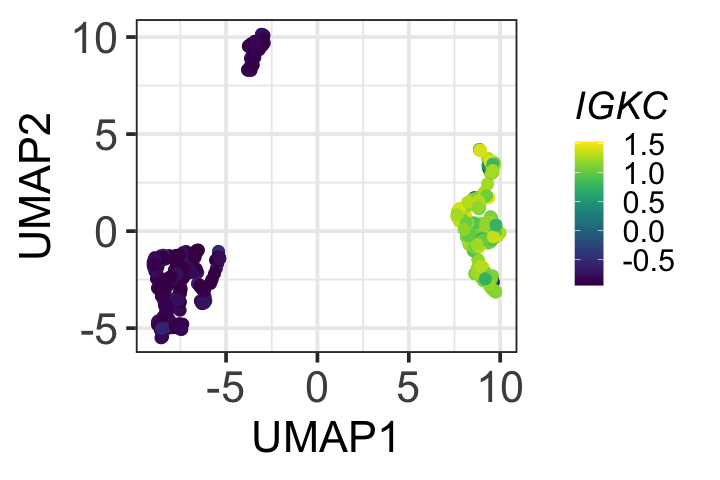

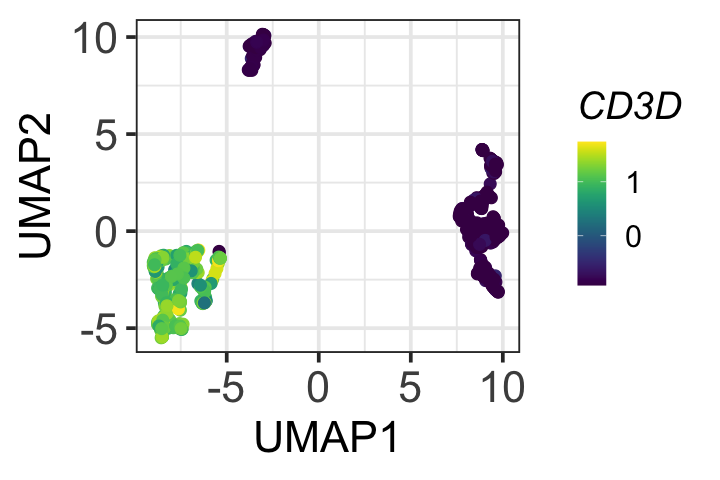

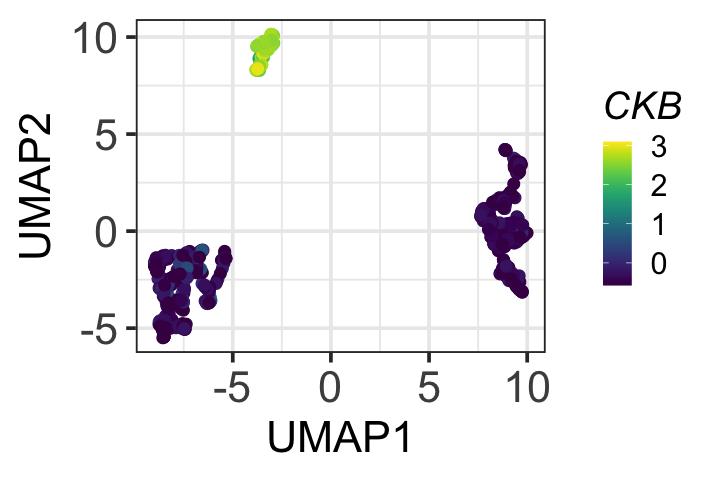

In [77]:
plot_exprs(scale_adt, meta_umap_adt.clust, markers = c("CD19", "CD3", "Podoplanin"), fig_size = c(4,6))
plot_exprs(scale_exprs, meta_umap.clust, markers = c("IGKC", "CD3D", "CKB"),fig_size = c(4,6))

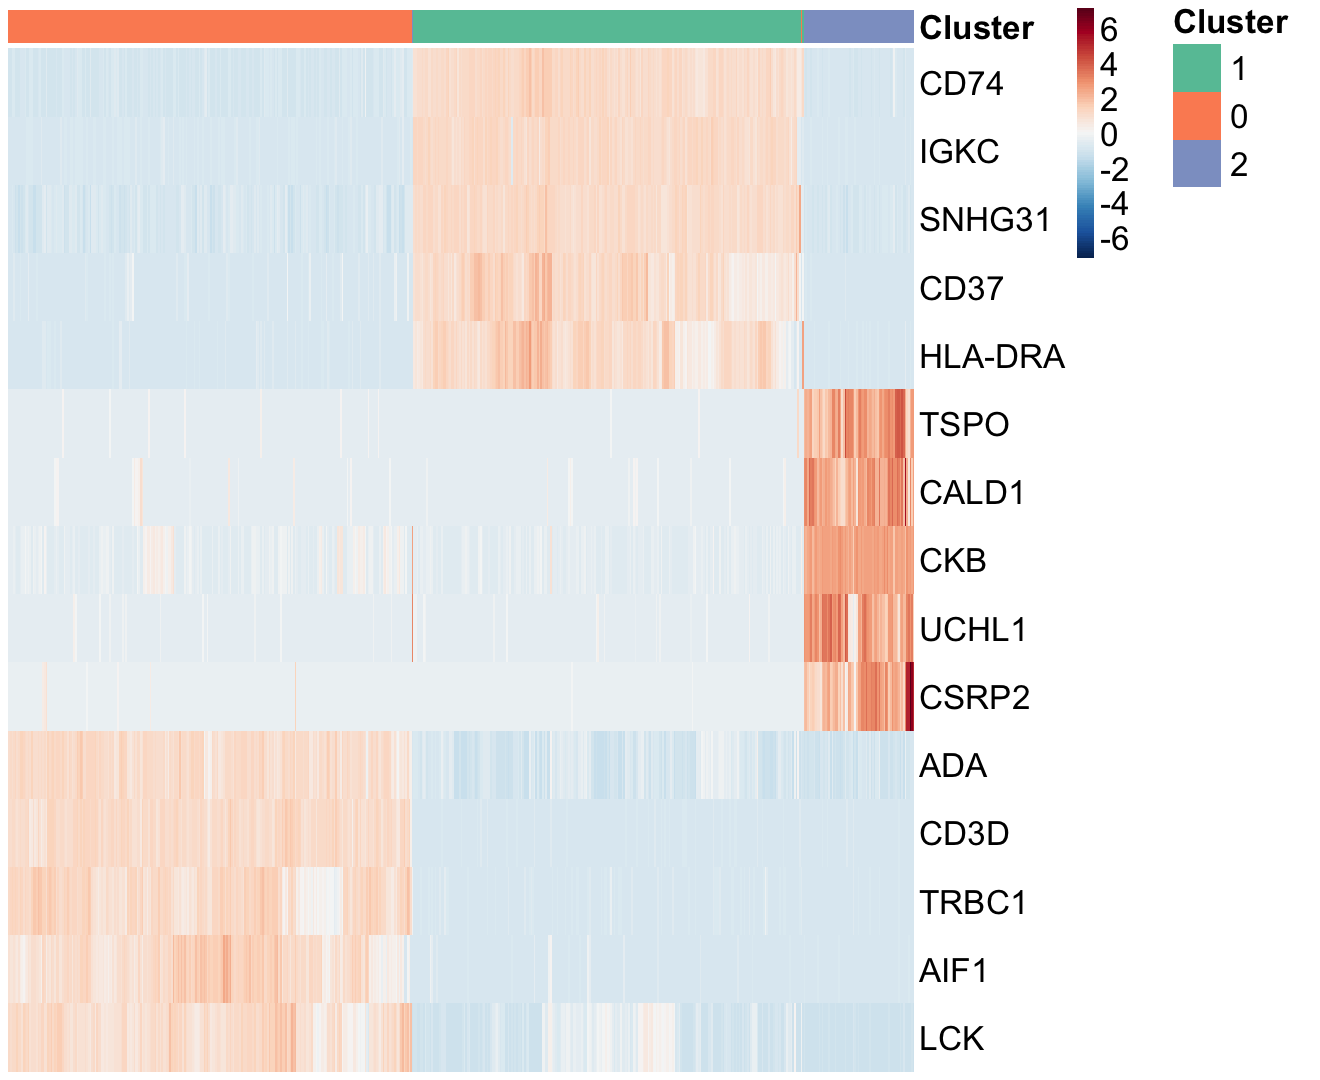

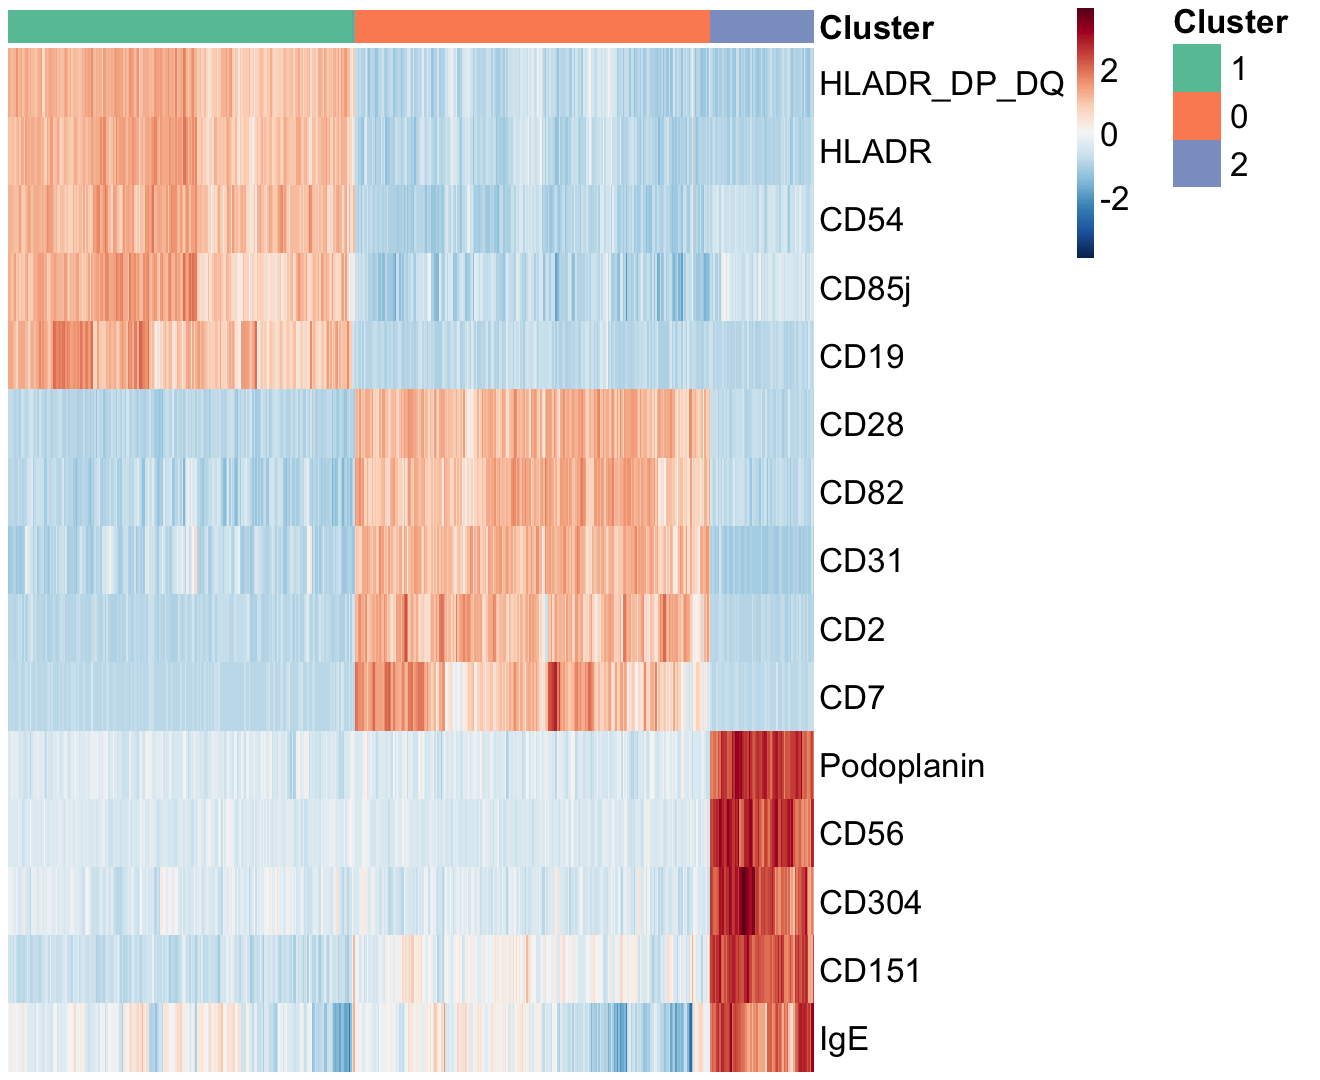

In [81]:
#Heatmap plots
meta <- meta_umap.clust
df <- scale_exprs[,meta$cell]

    
    dge = wilcoxauc(df, meta$cluster)
    var_genes = top_markers(dge, 5) %>% head(5) %>% select(-rank) %>% unlist %>% unique
    cmax = abs(df[var_genes, ]) %>% unlist %>% max
    
    mat_col <- data.frame(Cluster = meta$cluster)
    rownames(mat_col) <- rownames(meta)
    
    mat_colors <- list(Cluster = c(
        "1" = "#66C2A5", 
        "0" = "#FC8D62", 
        "2" = "#8DA0CB"))
    
    mat_cluster_cols <- hclust(dist(t(df[var_genes, ])))
    mat_cluster_cols <- sort_hclust(mat_cluster_cols)
    mat_cluster_rows <- sort_hclust(hclust(dist(df[var_genes, 
        ])))
   
fig.size(9, 11)
    pheatmap(df[var_genes, ],
            # main = "Scaled TPM PTEN", 
             breaks = seq(-cmax, cmax, length.out = 100), 
             color = colorRampPalette(brewer.pal(11, "RdBu"))(100) %>% rev, 
             show_colnames = FALSE, 
             annotation_col = mat_col, 
             annotation_colors = mat_colors,
            fontsize = 20, 
             cluster_cols = mat_cluster_cols, 
             cluster_rows = mat_cluster_rows, 
             treeheight_row = 0, 
            treeheight_col = 0)

#Heatmap plots
meta <- meta_umap_adt.clust
df <- scale_adt[,meta$cell]

    
    dge = wilcoxauc(df, meta$cluster)
    var_genes = top_markers(dge, 5) %>% head(5) %>% select(-rank) %>% unlist %>% unique
    cmax = abs(df[var_genes, ]) %>% unlist %>% max
    
    mat_col <- data.frame(Cluster = meta$cluster)
    rownames(mat_col) <- rownames(meta)
    
    mat_colors <- list(Cluster = c(
        "1" = "#66C2A5", 
        "0" = "#FC8D62", 
        "2" = "#8DA0CB"))
    
    mat_cluster_cols <- hclust(dist(t(df[var_genes, ])))
    mat_cluster_cols <- sort_hclust(mat_cluster_cols)
    mat_cluster_rows <- sort_hclust(hclust(dist(df[var_genes, 
        ])))
   
fig.size(9, 11)
    pheatmap(df[var_genes, ],
            # main = "Scaled TPM PTEN", 
             breaks = seq(-cmax, cmax, length.out = 100), 
             color = colorRampPalette(brewer.pal(11, "RdBu"))(100) %>% rev, 
             show_colnames = FALSE, 
             annotation_col = mat_col, 
             annotation_colors = mat_colors,
            fontsize = 20, 
             cluster_cols = mat_cluster_cols, 
             cluster_rows = mat_cluster_rows, 
             treeheight_row = 0, 
            treeheight_col = 0)

# Additional Processing for figures

In [82]:
##full normalized and scaled expression
filt_norm_scale_exprs <- filt_exprs %>% singlecellmethods::normalizeData(method = "log") %>% 
    singlecellmethods::scaleData()

In [83]:
#normalized expression
norm_exprs <- filt_exprs %>% singlecellmethods::normalizeData(method = "log")

In [84]:
norm_filt_exprs <- norm_exprs %>% t %>% as_tibble(rownames = "cell") 

In [85]:
CLR_adt_filt <- counts_ADT_filt%>% singlecellmethods::normalizeData(method = "cellCLR")%>% t %>% 
    as_tibble(rownames = "cell") 

# Merging Modalities

In [116]:
#Use FlowMatrix to add cell ids to DNA matrix. 
alleles_DNA_align_filt_gen<- 
alleles_DNA_align_filt_gen %>% inner_join(
FlowMatrix %>% dplyr::rename(Well = Well_ID) %>% select(Barcode_DNA, Well, cell))

Joining with `by = join_by(Barcode_DNA, Well, cell)`


In [117]:
##Merge all three data sets
Plots <- alleles_DNA_align_filt_gen %>% 
    inner_join(select(meta_umap_adt.clust, cell, cluster, UMAP1, UMAP2)) %>% 
    inner_join(select(meta_umap.clust, cell, cluster, UMAP1, UMAP2), by = "cell") %>% 
    mutate("Genotype" = paste0("G",genotype)) %>% 
    inner_join(FlowMatrix) %>% na.omit

Joining with `by = join_by(cell)`
Joining with `by = join_by(Barcode_DNA, cell)`


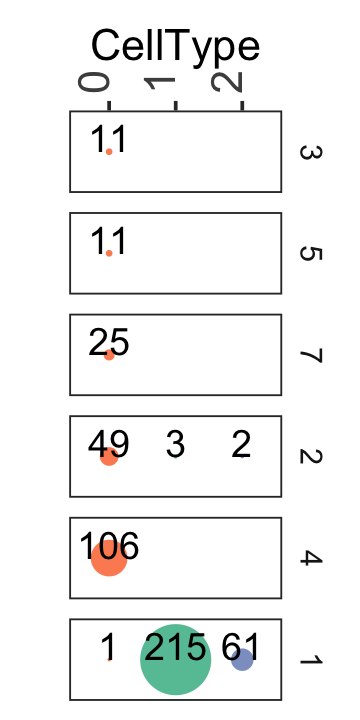

In [118]:
## Plot of PTEN genotypes distributions across RNA clusters
## Define df for plotting 
df <- Plots %>% add_count(genotype,name = "genotype_count") %>% 
    filter(genotype_count  > 2)

#Defineplotting Order
order <- df$genotype %>% table %>% as_data_frame %>% arrange(`n`)
order <- as.character(order$`.`)


#Make figure
fig.size(6,3)
g <- 

table(df$genotype,df$cluster.x) %>% 
as.data.frame() %>% dplyr::rename(CellType = Var2, genotype = Var1) %>% 
na.omit %>% filter(Freq != 0) %>% {
    
    ggplot(., aes(CellType,fill=CellType,
                   size = Freq)) +
      geom_point(aes(y = 0),shape = 21, stroke = 0) +
      #geom_hline(yintercept = seq(.5, 4.5, 1), size = .2) +
  scale_x_discrete(position = "top") +
  scale_radius(range = c(1,20)) +
    geom_text(aes(y = 0, label = Freq), size =8, vjust = -0)+
  theme_gy() +
  theme(legend.position = "none", 
        panel.grid.major = element_blank(),
        legend.text = element_text(size = 8),
        legend.title = element_text(size = 8), 
       axis.text.x = element_text(angle = 90)) + 
    ylab("") + 
    scale_y_discrete(expand = c(0.1,0.5)) + 
    facet_grid(factor((genotype), levels = order)~ .) + 
    theme(
  strip.background = element_blank(),
  #strip.text.x = element_blank(), 
    #panel.border=element_blank(), 
   # strip.text.y = element_blank()  
        ) +scale_fill_manual(values = c("2"='#8DA0CB',
                                  "1" = '#66C2A5',
                                  "0"='#FC8D62'))
    
} 
plot(g)


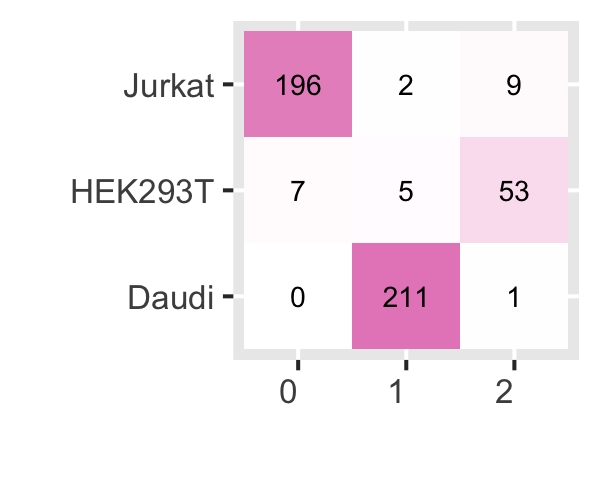

In [119]:
# Compare cluster concordance in ADT vs Flow
concordance_RNAflow = table(Plots$cluster.x,
                                 Plots$CellType_Index) %>% as.data.frame


fig.size(4,5)
ggplot(concordance_RNAflow)+
    geom_tile(aes(x = Var1, y = Var2, fill = Freq))+
    geom_text(aes(x = Var1, y = Var2, label = Freq), size = 6) +
    scale_fill_gradient(low = "white", high = "#E78AC3")+
    theme_g(25) + theme(axis.text.x = element_text(angle = 0, vjust = 1, hjust=1, size = 20)) + 
    xlab("") + ylab("") + theme(legend.position = "none") 

Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Picking joint bandwidth of 0.0778



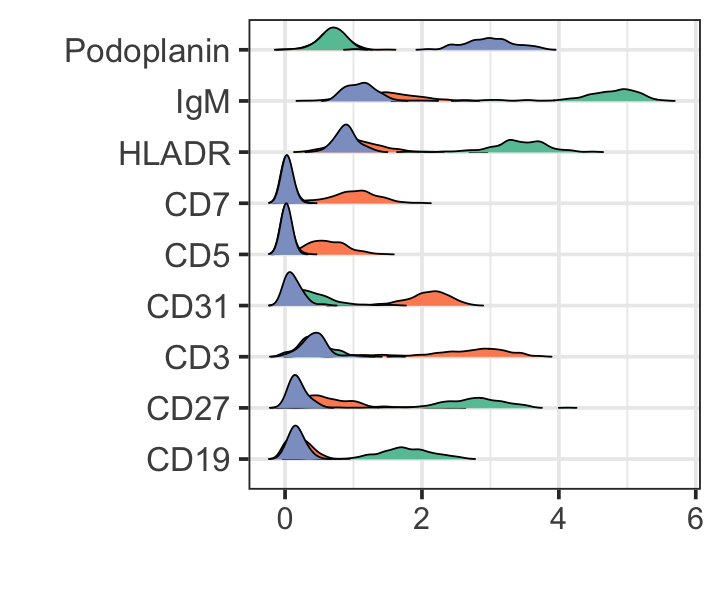

In [1388]:
##ADT data normalized but not scaled. 
fig.size(5,6)
norm_adt %>% t %>% as_tibble(rownames = "cell") %>% inner_join(meta_umap_adt_JDHEK.clust, by = "cell") %>% 
    select(DGEADT.JDHEK, cluster) %>% 
    pivot_longer(1:length(DGEADT.JDHEK), names_to = "ADT") %>% 
    ggplot(aes(value, ADT, fill = cluster)) + 
    geom_density_ridges_gradient(scale = 1, rel_min_height = 0.001)   +
    theme_gy() + #scale_x_continuous(limits = c(-3,3))  + 
    scale_fill_brewer(palette = "Set2")+
  xlab("") + theme_gy() + 
    theme(axis.text.y = element_text(size = 20)) + 
    labs(fill = "Cluster") +   theme(legend.position = "none") + 
ylab("")+scale_fill_manual(values = c("2"='#8DA0CB',
                                  "1" = '#66C2A5',
                                  "0"='#FC8D62'))

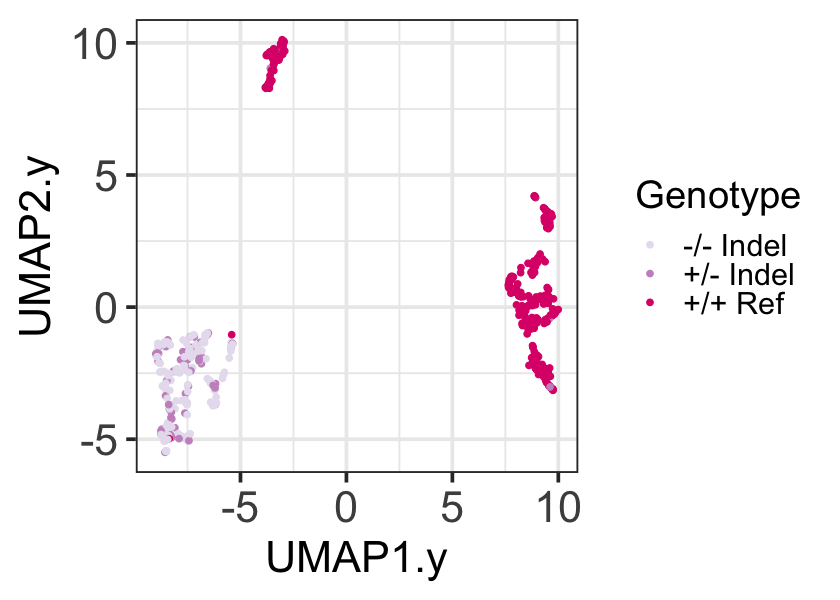

In [120]:
#DNA alleles in ADT UMAP
fig.size(5,7)
Plots %>% 
mutate(Genotype = ifelse(genotype %in% c(2,5), "+/- Indel", 
                         ifelse(genotype %in% c(3,4,7), "-/- Indel", 
                                ifelse(genotype == 1,"+/+ Ref", NA)))) %>%
na.omit %>%
ggplot(aes(UMAP1.y, UMAP2.y, color = Genotype)) + 
geom_point() + theme_gy() + 
scale_color_brewer(palette = "PuRd") + 
theme(legend.position = "right", 
     legend.title = element_text(face = "plain" )) + 
labs(color = "Genotype")

Joining with `by = join_by(cell)`
Joining with `by = join_by(cell)`
`geom_smooth()` using formula = 'y ~ x'


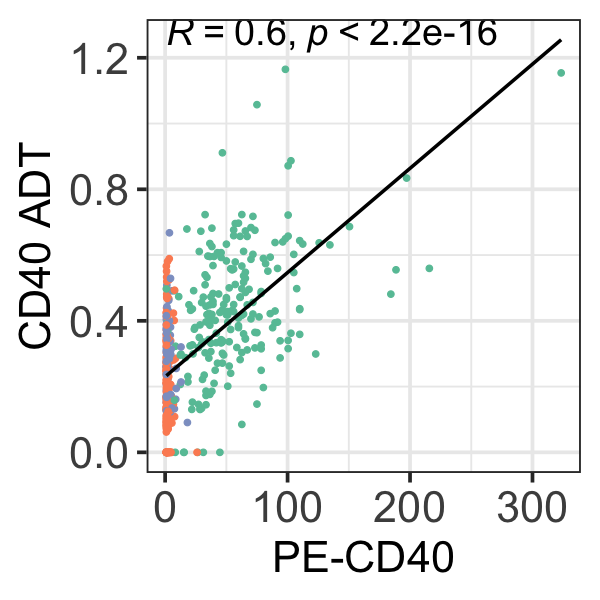

In [123]:
#Plot correlations
options(scipen = 0)
fig.size(5,5)
scale_exprs["CD40",] %>% as_tibble(rownames = "cell") %>% 
inner_join(Plots) %>% inner_join(
t(counts_ADT_filt %>% singlecellmethods::normalizeData(method = "cellCLR")) %>% as_tibble(rownames = "cell")) %>%

ggplot(aes(PE_CD40, CD40)) + 
geom_point(aes(color = as.factor(cluster.x))) + #scale_x_log10()+
stat_cor(size =8, vjust = -0.5) + 
theme_gy() + 
geom_smooth(method = lm, se = F, linetype =1, color = "black") + 
xlab("PE-CD40") + 
ylab("CD40 ADT") + labs(color = "ADT Cluster") + 
theme(legend.position = "none")+
scale_color_manual(values = c("2"='#8DA0CB',
                                  "1" = '#66C2A5',
                                  "0"='#FC8D62'))

Joining with `by = join_by(cell)`
Joining with `by = join_by(cell)`
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
`geom_smooth()` using formula = 'y ~ x'


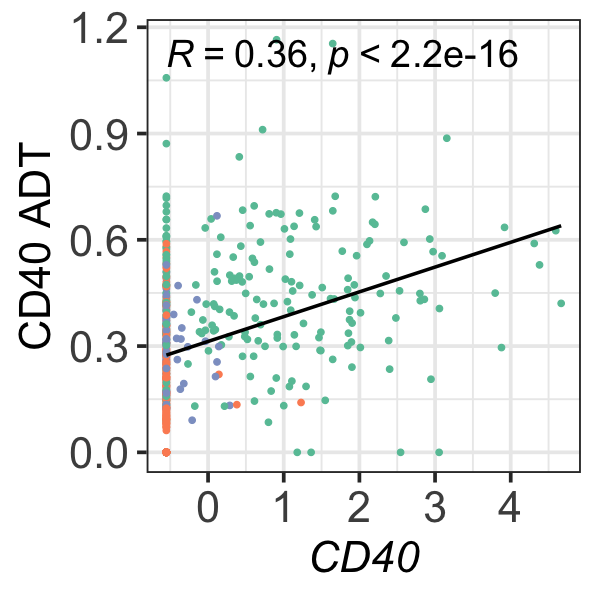

In [126]:
options(scipen = 0)
fig.size(5,5)
scale_exprs["CD40",] %>% as_tibble(rownames = "cell") %>% dplyr::rename("CD40gene" = value) %>% 
inner_join(Plots) %>% inner_join(
t(counts_ADT_filt %>% singlecellmethods::normalizeData(method = "cellCLR")) %>% as_tibble(rownames = "cell")) %>%


ggplot(aes(CD40gene, CD40)) + geom_point(aes(color = as.factor(cluster.x))) + #scale_x_log10()+
stat_cor(size =8,vjust = 1) + 
theme_gy() + 
scale_color_brewer(palette = "Set2") + 
geom_smooth(method = lm, se = F, linetype =1, color = "black") + 
xlab("CD40") + 
ylab("CD40 ADT") + labs(color = "ADT Cluster") + 
    theme(axis.title.x = element_text(face = "italic")) +
theme(legend.position = "none")+
scale_color_manual(values = c("2"='#8DA0CB',
                                  "1" = '#66C2A5',
                                  "0"='#FC8D62'))

Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.


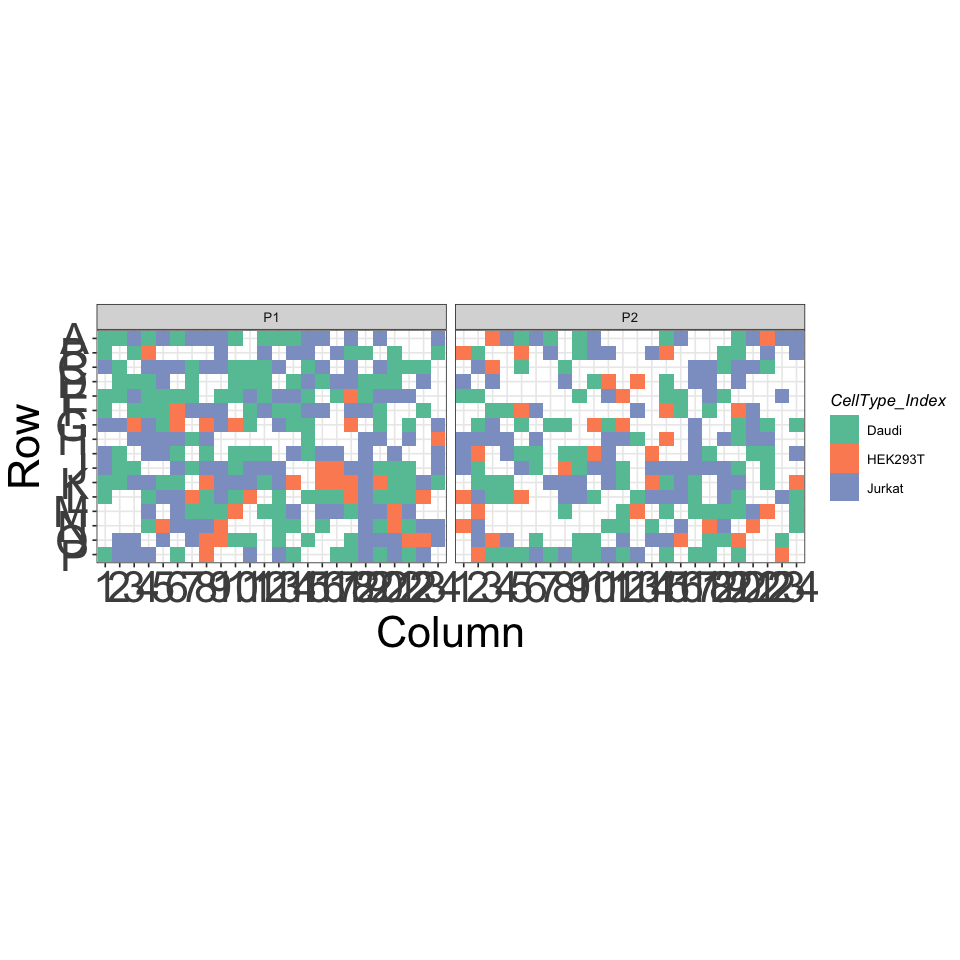

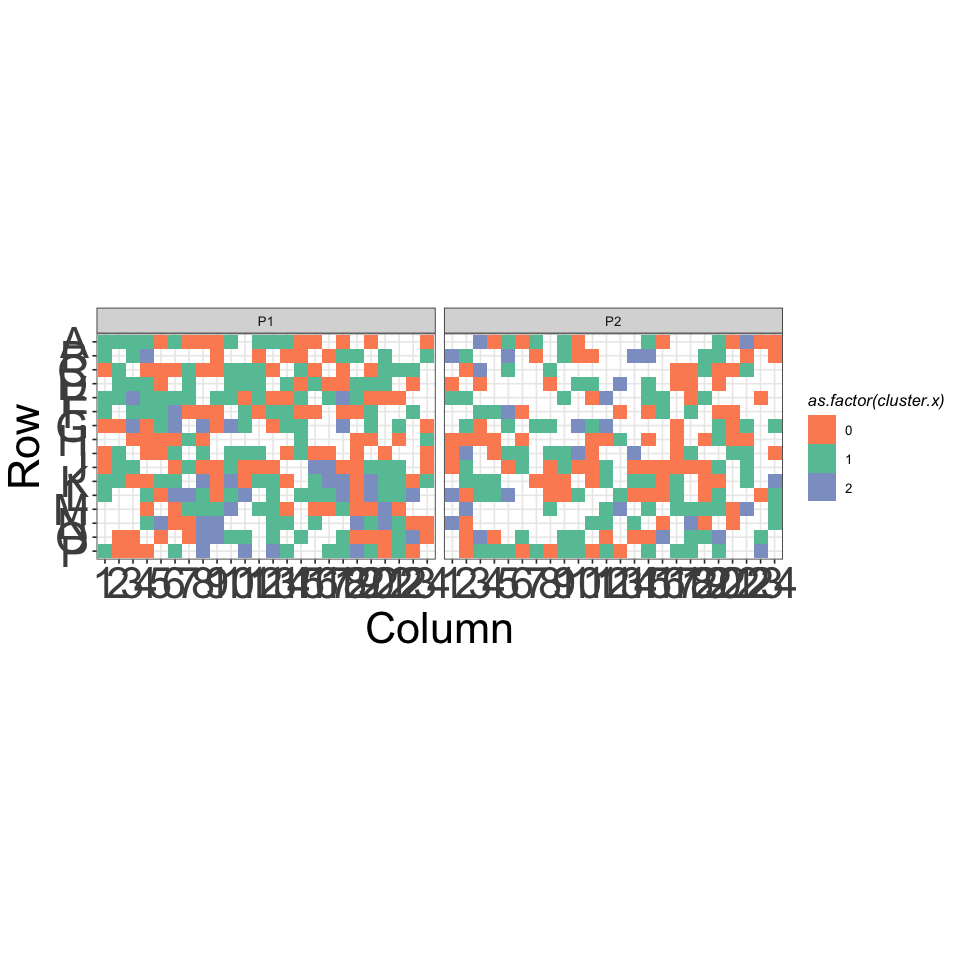

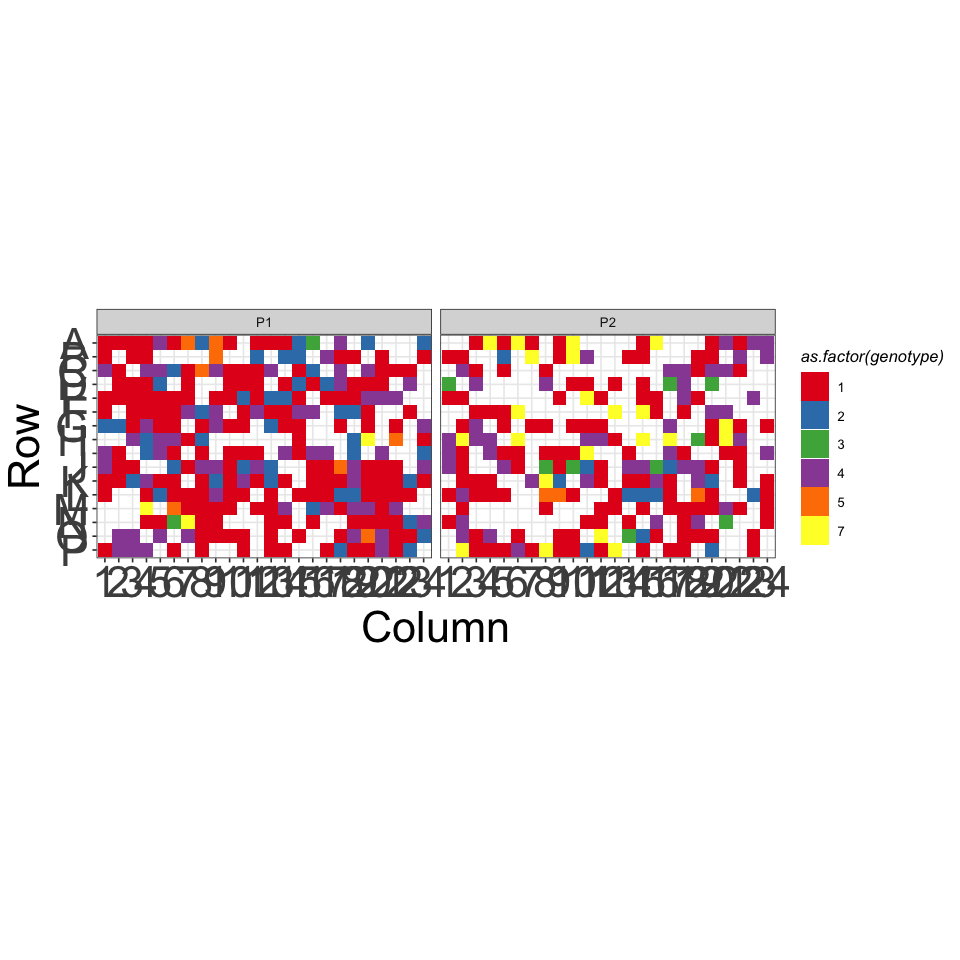

In [128]:
#Plot plate distributions
fig.size(8,8)
Plots %>% separate(Well_ID, 
                        into = c("Row", "Column"), 
                        sep = "(?<=[A-Za-z])(?=[0-9])") %>% 
    mutate("Column" = factor(Column, levels = c(1:24))) %>%
    mutate("Row"= factor(Row, levels = c(LETTERS[26:1]))) %>% 
    na.omit %>% 
    
ggplot(aes(x = Column, y = Row)) + geom_tile(aes(fill = CellType_Index)) + facet_wrap(~Plate) + 
    scale_fill_brewer(palette = "Set2") + theme_gy(10) + 
    theme(aspect.ratio = 16/24)

fig.size(8,8)
g <- Plots %>% separate(Well_ID, 
                        into = c("Row", "Column"), 
                        sep = "(?<=[A-Za-z])(?=[0-9])") %>% 
    mutate("Column" = factor(Column, levels = c(1:24))) %>%
    mutate("Row"= factor(Row, levels = c(LETTERS[26:1]))) %>% 
    na.omit %>% 
    
ggplot(aes(x = Column, y = Row)) + geom_tile(aes(fill = as.factor(cluster.x))) + facet_wrap(~Plate) + 
    scale_fill_brewer(palette = "Set2") + theme_gy(10) + 
    theme(aspect.ratio = 16/24)+
scale_fill_manual(values = c("2"='#8DA0CB',
                                  "1" = '#66C2A5',
                                  "0"='#FC8D62'))
plot(g)


fig.size(8,8)
g <- Plots %>% separate(Well_ID, 
                        into = c("Row", "Column"), 
                        sep = "(?<=[A-Za-z])(?=[0-9])") %>% 
    mutate("Column" = factor(Column, levels = c(1:24))) %>%
    mutate("Row"= factor(Row, levels = c(LETTERS[26:1]))) %>% 
    na.omit %>% add_count(genotype) %>% filter(n >2) %>%
    
ggplot(aes(x = Column, y = Row)) + geom_tile(aes(fill = as.factor(genotype))) + facet_wrap(~Plate) + 
    scale_fill_brewer(palette = "Set1") + theme_gy(10) + 
    theme(aspect.ratio = 16/24)
plot(g)



In [311]:
##Merge all three data sets
## read in matrix from other work sheet defining cluster

DQB1Plots <- read_csv("DQB1matrix.csv") %>% select(cell, DQB1deletion_Mean, KClust, Edited_Index2) %>% 
    inner_join(select(meta_umap_adt_DQB1.clust, cell, cluster, UMAP1, UMAP2, nUMI, nGenes)) %>% # Add meta adt data
    inner_join(select(meta_umap_DQB1.clust, cell, cluster, UMAP1, UMAP2, nUMI, nGenes), by = "cell")  #add meta RNA data

##Add FlowData to this. 
DQB1Plots <- FlowMatrix %>%
    mutate("Experiment_Index" = ifelse(Experiment_Index == "PTEN", "JDHEK", Experiment_Index)) %>% 
    mutate(Condition = paste0(Experiment_Index, "_", Plate))  %>%
    inner_join(read_csv("PlateMeta2Full.csv")) %>% 
    mutate("cell" = paste0(RNA_Barcode, "_", Barcode_RNA)) %>% 
    inner_join(DQB1Plots) %>% na.omit
DQB1Plots%>% head
#Save meta data files
DQB1Plots %>% write_csv("DQB1Plots.csv")
DQB1Plots<- read_csv("DQB1Plots.csv")

Rows: 721 Columns: 389
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (26): Barcode_DNA, Well_ID.x, Condition, Barcode_RNA, Barcode_ADT, RNA_...
dbl (363): DQB1deletion_Mean, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14,...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Joining with `by = join_by(cell)`
Rows: 10 Columns: 4
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): Condition, Barcode_RNA, Barcode_ADT, Barcode_DNA

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Joining with `by = join_by(Condition)`
Joining with `by = join_by(cell)`


Well_ID DNA_Barcode RNA_Barcode    Experiment_Index Plate PB_CD45  
1 A1      AACACGAGGA  AACATCTCTGTGAC DQB1             P1     21.28752
2 A2      AACCAATGAC  AACCAACCAGACTC DQB1             P1    105.07137
3 A3      AACGACTCCA  AACCGTATGCGGTG DQB1             P1     78.43886
4 A3      AACGACTCCA  AACCGTATGCGGTG DQB1             P2     74.98942
5 A3      AACGACTCCA  AACCGTATGCGGTG DQB1             P4    117.57433
6 A4      AACGTATACC  AACCGTGCCACATA DQB1             P1    831.61416
  BV605_CD45 SSC       FSC      FITC_DQB1 ⋯ cluster.x UMAP1.x   UMAP2.x   
1  295.5991   6731.704 29032.91  107.4608 ⋯ 1          6.672213 -1.9406789
2  995.5129  40679.443 38025.78 2236.7084 ⋯ 0         -7.732679  2.0181108
3  634.9425  26535.552 43518.30 1333.5214 ⋯ 0         -7.364677  1.9961778
4 1018.1517  20260.055 31765.31  378.5515 ⋯ 1          5.562515 -1.1025983
5  236.0733  37180.267 34754.87 3064.2777 ⋯ 0         -6.148256 -2.5498857
6  433.2302  12921.952 25368.62  161.0762 ⋯ 1          8.432272 -0.9523577
  nUMI.x nGenes.x cluster.y UMAP1.y   UMAP2.y    nUMI.y nGenes.y
1  4765  137      0         -7.265769  4.4356597  15848 2744    
2 15187  151      1         10.362779  2.5369396 107965 7505    
3 11900  146      1          7.998463  0.5772439  78917 6195    
4  9612  148      0         -7.456430 -3.0653818  88916 6578    
5 15796  146      1          9.657458 -3.0779700  46599 4981    
6  3052  126      0         -8.762729 -1.3584078  38058 5021

Rows: 646 Columns: 37
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (16): Well_ID, DNA_Barcode, RNA_Barcode, Experiment_Index, Plate, FBXO11...
dbl (21): PB_CD45, BV605_CD45, SSC, FSC, FITC_DQB1, PE_CD40, PECY7_CD45, APC...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [318]:
#Define cells
Daudi_DQB1 <- DQB1Plots %>% filter(cluster.x == 1) %>% with(cell)
HH_DQB1 <- DQB1Plots %>% filter(cluster.x == 0) %>% with(cell)

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


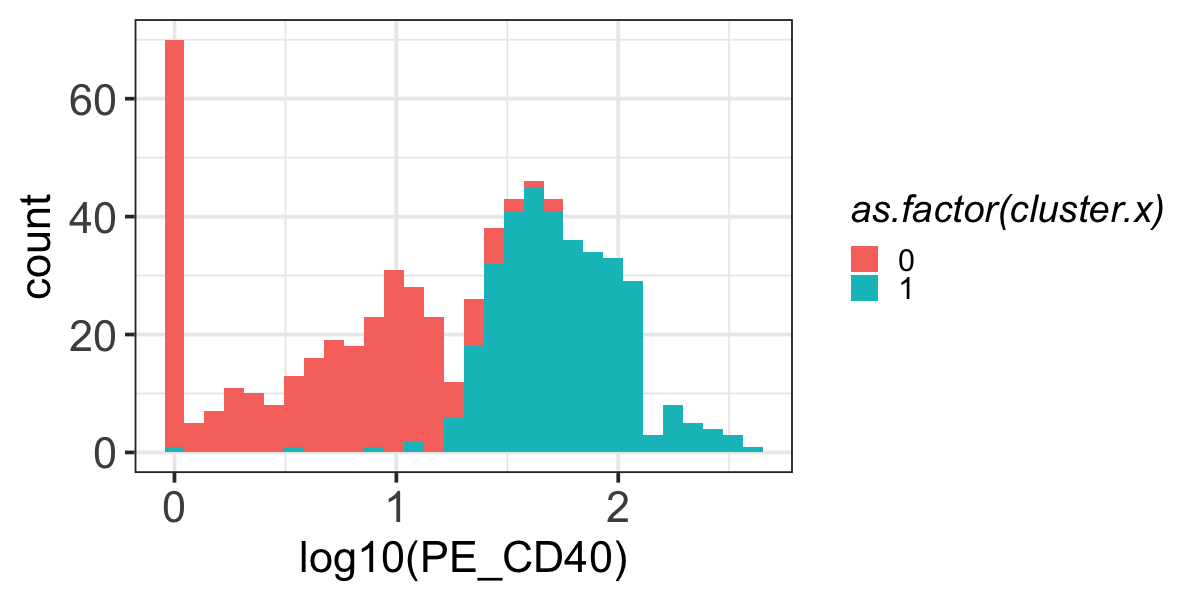

In [319]:
fig.size(5,10)
DQB1Plots %>% ggplot(aes(log10(PE_CD40), fill = as.factor(cluster.x))) + geom_histogram() + theme_gy()


In [315]:
library(lme4)

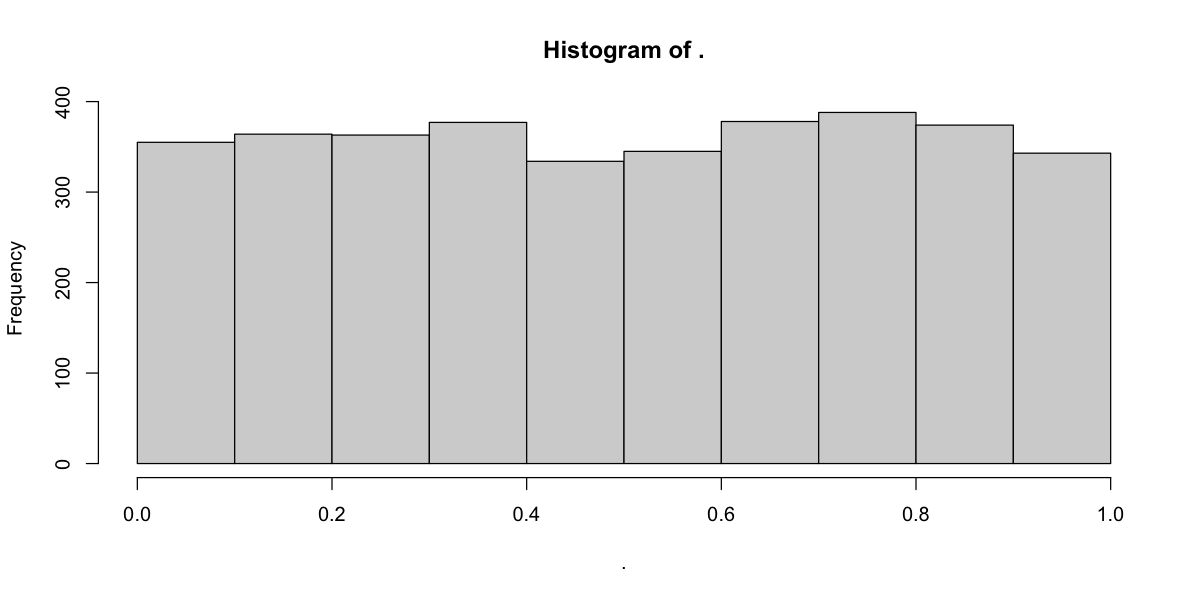

In [352]:
## Linear modeling with negative binomial. 
#filter on gene expression not in the whole data set but only in the selected. 
cells <- Daudi_DQB1
df <- (DQB1Plots %>% filter(cluster.x == 1))

nCells = rowSums(filt_exprs[,cells] > 0)
gene_qc = data.frame(nCells = nCells %>% sort %>% rev, rank = seq(1, length(nCells)))

Exprs <- filt_exprs[gene_qc %>% filter(nCells > length(cells)*0.3) %>% rownames, cells]
genes <- names(which(rowSums(Exprs)/length(cells)> 2))

suppressWarnings({
DQB1_lm_Daudi <- 
    sapply(genes, function(i){ 
        

    lm0<- glm.nb(data = df,  
          formula = (Exprs)[i,] ~ 1 + log10(nUMI.y) + Plate
            )
    
    lm1 <- glm.nb(data = df,  
          formula = (Exprs)[i,] ~ 1  + log10(nUMI.y) + Plate + log2(DQB1deletion_Mean+1)
               )
    
    return(c("pval" = anova(lm0,lm1)[2,8],"beta" = summary(lm1)$coeff[6,1]))
        })
    })
DQB1_lm_Daudi<- DQB1_lm_Daudi %>% t %>% as_tibble(rownames = "Genes")
DQB1_lm_Daudi %>% with(pval) %>% hist
DQB1_lm_Daudi <- DQB1_lm_Daudi %>% arrange(pval) %>% mutate(padj = p.adjust(pval, method = "BH"))

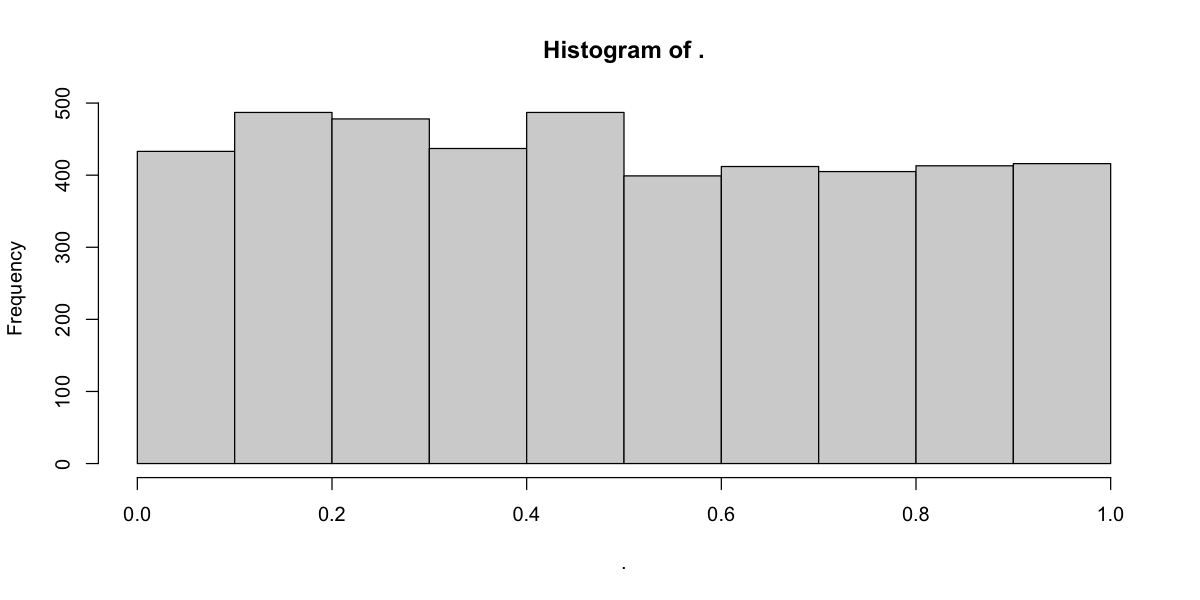

In [353]:
## Linear modeling with negative binomial. 
#filter on gene expression not in the whole data set but only in the selected. 
cells <- HH_DQB1
nCells = rowSums(filt_exprs[,cells] > 0)
gene_qc = data.frame(nCells = nCells %>% sort %>% rev, rank = seq(1, length(nCells)))

DQB1_exprs <- filt_exprs[gene_qc %>% filter(nCells > length(HH_DQB1)*0.3) %>% rownames, HH_DQB1]
genes <- names(which(rowSums(DQB1_exprs)/length(cells)> 2))

suppressMessages({
    suppressWarnings({
DQB1_lm_HH <- 
    sapply(genes, function(i){ 
        

    lm0<- glm.nb(data = (DQB1Plots %>% filter(cluster.x == 0)),  
          formula = (DQB1_exprs)[i,] ~ 1 + log10(nUMI.y) + Plate
            )
    
    lm1 <- glm.nb(data = (DQB1Plots %>% filter(cluster.x == 0)),  
          formula = (DQB1_exprs)[i,] ~ 1  + log10(nUMI.y) + Plate + log2(DQB1deletion_Mean+1)
               )
    
    return(c("pval" = anova(lm0,lm1)[2,8],"beta" = summary(lm1)$coeff[6,1]))
        })
        })
    })
DQB1_lm_HH<- DQB1_lm_HH %>% t %>% as_tibble(rownames = "Genes")
DQB1_lm_HH %>% with(pval) %>% hist
DQB1_lm_HH <- DQB1_lm_HH %>% arrange(pval) %>% mutate(padj = p.adjust(pval, method = "BH"))

In [ ]:
## Linear modeling with negative binomial. 
#filter on gene expression not in the whole data set but only in the selected. 
cells <- Daudi_DQB1
df <- (DQB1Plots %>% filter(cluster.x == 1))

nCells = rowSums(filt_exprs[,cells] > 0)
gene_qc = data.frame(nCells = nCells %>% sort %>% rev, rank = seq(1, length(nCells)))

Exprs <- filt_exprs[gene_qc %>% filter(nCells > length(cells)*0.3) %>% rownames, cells]
genes <- names(rowSums(Exprs)/length(cells)> 1.5)

suppressWarnings({
DQB1_lm_Daudi_Edited <- 
    sapply(genes, function(i){ 
        

    lm0<- glm.nb(data = df,  
          formula = (Exprs)[i,] ~ 1 + log10(nUMI.y) + Plate
            )
    
    lm1 <- glm.nb(data = df,  
          formula = (Exprs)[i,] ~ 1  + log10(nUMI.y) + Plate + Edited_Index2
               )
    
    return(c("pval" = anova(lm0,lm1)[2,8],"beta" = summary(lm1)$coeff[6,1]))
        })
    })
DQB1_lm_Daudi_Edited<- DQB1_lm_Daudi_Edited %>% t %>% as_tibble(rownames = "Genes")
DQB1_lm_Daudi_Edited %>% with(pval) %>% hist
DQB1_lm_Daudi_Edited <- DQB1_lm_Daudi_Edited %>% arrange(pval) %>% mutate(padj = p.adjust(pval, method = "BH"))

In [ ]:
## Linear modeling with negative binomial. 
#filter on gene expression not in the whole data set but only in the selected. 
cells <- HH_DQB1
df <- (DQB1Plots %>% filter(cluster.x == 0))

nCells = rowSums(filt_exprs[,cells] > 0)
gene_qc = data.frame(nCells = nCells %>% sort %>% rev, rank = seq(1, length(nCells)))

Exprs <- filt_exprs[gene_qc %>% filter(nCells > length(cells)*0.3) %>% rownames, cells]
genes <- names(rowSums(Exprs)/length(cells)> 1.5)

suppressWarnings({
DQB1_lm_HH_Edited <- 
    sapply(genes, function(i){ 
        

    lm0<- glm.nb(data = df,  
          formula = (Exprs)[i,] ~ 1 + log10(nUMI.y) + Plate
            )
    
    lm1 <- glm.nb(data = df,  
          formula = (Exprs)[i,] ~ 1  + log10(nUMI.y) + Plate + Edited_Index2
               )
    
    return(c("pval" = anova(lm0,lm1)[2,8],"beta" = summary(lm1)$coeff[6,1]))
        })
    })
DQB1_lm_HH_Edited<- DQB1_lm_HH_Edited %>% t %>% as_tibble(rownames = "Genes")
DQB1_lm_HH_Edited %>% with(pval) %>% hist
DQB1_lm_HH_Edited <- DQB1_lm_HH_Edited %>% arrange(pval) %>% mutate(padj = p.adjust(pval, method = "BH"))

In [355]:
DQB1_lm_Daudi %>% head 

DQB1_lm_HH %>% head 


Genes    pval                beta        padj           
1 HLA-DQB1 0.00000000004655876 -0.29282038 0.0000001685893
2 DDA1     0.00068328850994226  0.12742387 0.7600674480927
3 BCAT2    0.00080474034487499 -0.14457260 0.7600674480927
4 USP10    0.00104278354174669  0.09325347 0.7600674480927
5 MRPS34   0.00131501728937677 -0.07506626 0.7600674480927
6 IQGAP1   0.00138313369551013  0.13393035 0.7600674480927

Genes      pval               beta        padj          
1 HLA-DQB1   0.0000000005790215 -0.18069967 0.000002528587
2 MIR155HG   0.0000831794137792  0.09370005 0.181622249987
3 AC078923.1 0.0003028954732944 -0.04693051 0.440914843959
4 TARS2      0.0010508621281626  0.13171014 0.822922171437
5 CAMK1D     0.0010533319666147  0.17700587 0.822922171437
6 RPIA       0.0013879528159063  0.06925124 0.822922171437

In [1589]:
#creating norm_adt 
norm_adt <- counts_ADT_filt %>% singlecellmethods::normalizeData(method = "cellCLR")

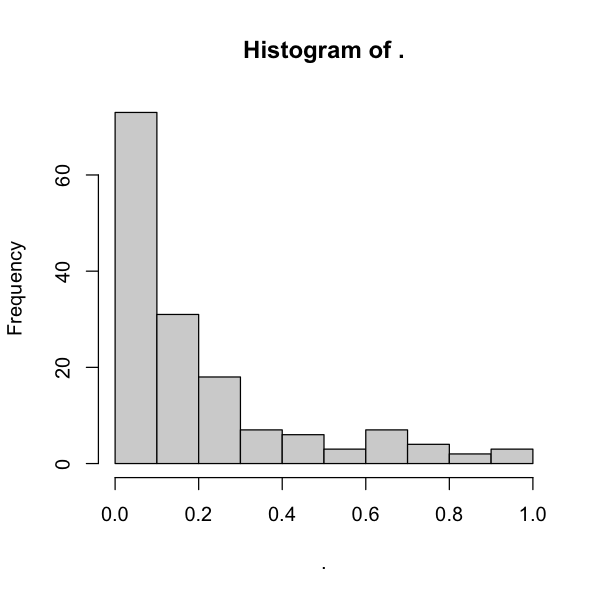

In [2448]:
## Linear modeling with negative binomial. 
#filter on gene expression not in the whole data set but only in the selected. 
cells <- HH_DQB1
df <- (DQB1Plots %>% filter(cluster.x == 0))

Exprs <- counts_ADT_filt[,cells]
genes <- rownames(Exprs)

suppressWarnings({
DQB1_lm_HH_adt <- 
    sapply(genes, function(i){ 
        

    lm0<- glm.nb(data = df,  
          formula = (Exprs)[i,] ~ 1 + log10(nUMI.y) + Plate
            )
    
    lm1 <- glm.nb(data = df,  
          formula = (Exprs)[i,] ~ 1  + log10(nUMI.y) + Plate + log2(DQB1deletion_Mean + 1)
               )
    
    return(c("pval" = anova(lm0,lm1)[2,8],"beta" = summary(lm1)$coeff[6,1]))
        })
    })
DQB1_lm_HH_adt<- DQB1_lm_HH_adt %>% t %>% as_tibble(rownames = "Genes")
DQB1_lm_HH_adt %>% with(pval) %>% hist
DQB1_lm_HH_adt <- DQB1_lm_HH_adt %>% arrange(pval) %>% mutate(padj = p.adjust(pval, method = "BH"))

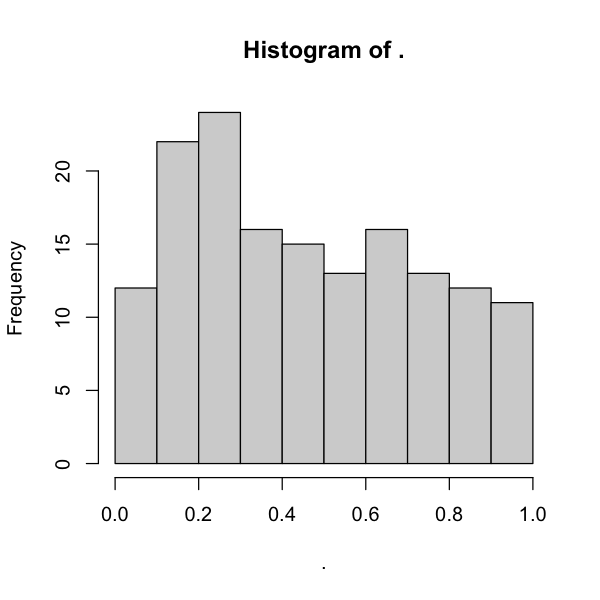

In [2450]:
## Linear modeling with negative binomial. 
#filter on gene expression not in the whole data set but only in the selected. 
cells <- Daudi_DQB1
df <- (DQB1Plots %>% filter(cluster.x == 1))

Exprs <- counts_ADT_filt[,cells]
genes <- rownames(Exprs)

suppressWarnings({
DQB1_lm_Daudi_adt <- 
    sapply(genes, function(i){ 
        

    lm0<- glm.nb(data = df,  
          formula = (Exprs)[i,] ~ 1 + log10(nUMI.y) + Plate
            )
    
    lm1 <- glm.nb(data = df,  
          formula = (Exprs)[i,] ~ 1  + log10(nUMI.y) + Plate + log2(DQB1deletion_Mean + 1)
               )
    
    return(c("pval" = anova(lm0,lm1)[2,8],"beta" = summary(lm1)$coeff[6,1]))
        })
    })
DQB1_lm_Daudi_adt<- DQB1_lm_Daudi_adt %>% t %>% as_tibble(rownames = "Genes")
DQB1_lm_Daudi_adt %>% with(pval) %>% hist
DQB1_lm_Daudi_adt <- DQB1_lm_Daudi_adt %>% arrange(pval) %>% mutate(padj = p.adjust(pval, method = "BH"))

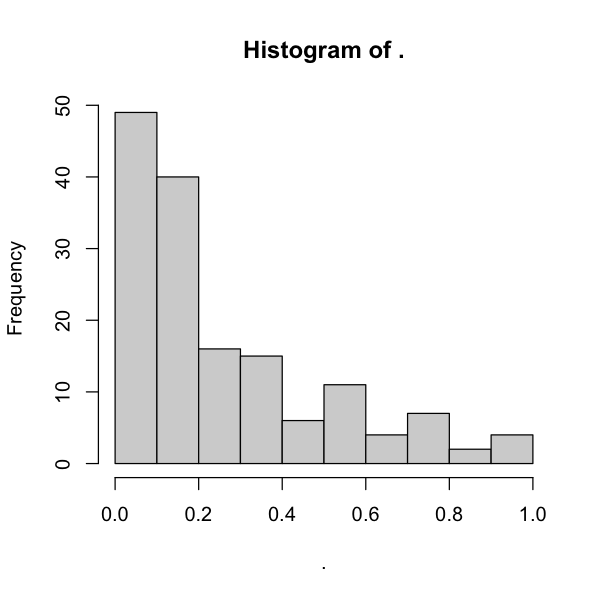

In [2452]:
## Linear modeling with negative binomial. 
#filter on gene expression not in the whole data set but only in the selected. 
cells <- HH_DQB1
df <- (DQB1Plots %>% filter(cluster.x == 0))

Exprs <- counts_ADT_filt[,cells]
genes <- rownames(Exprs)

suppressWarnings({
DQB1_lm_HH_adt_Edited <- 
    sapply(genes, function(i){ 
        

    lm0<- glm.nb(data = df,  
          formula = (Exprs)[i,] ~ 1 + log10(nUMI.y) + Plate
            )
    
    lm1 <- glm.nb(data = df,  
          formula = (Exprs)[i,] ~ 1  + log10(nUMI.y) + Plate + Edited_Index2
               )
    
    return(c("pval" = anova(lm0,lm1)[2,8],"beta" = summary(lm1)$coeff[6,1]))
        })
    })
DQB1_lm_HH_adt_Edited<- DQB1_lm_HH_adt_Edited %>% t %>% as_tibble(rownames = "Genes")
DQB1_lm_HH_adt_Edited %>% with(pval) %>% hist
DQB1_lm_HH_adt_Edited <- DQB1_lm_HH_adt_Edited %>% arrange(pval) %>% mutate(padj = p.adjust(pval, method = "BH"))

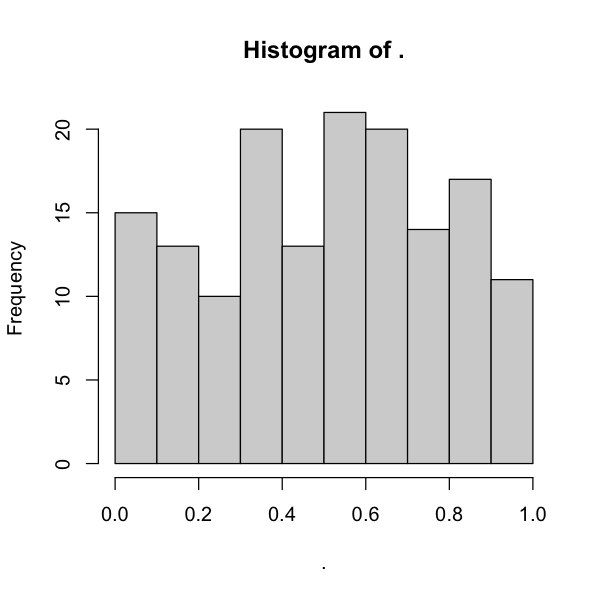

In [2453]:
## Linear modeling with negative binomial. 
#filter on gene expression not in the whole data set but only in the selected. 
cells <- Daudi_DQB1
df <- (DQB1Plots %>% filter(cluster.x == 1))

Exprs <- counts_ADT_filt[,cells]
genes <- rownames(Exprs)

suppressWarnings({
DQB1_lm_Daudi_adt_Edited <- 
    sapply(genes, function(i){ 
        

    lm0<- glm.nb(data = df,  
          formula = (Exprs)[i,] ~ 1 + log10(nUMI.y) + Plate
            )
    
    lm1 <- glm.nb(data = df,  
          formula = (Exprs)[i,] ~ 1  + log10(nUMI.y) + Plate + Edited_Index2
               )
    
    return(c("pval" = anova(lm0,lm1)[2,8],"beta" = summary(lm1)$coeff[6,1]))
        })
    })
DQB1_lm_Daudi_adt_Edited<- DQB1_lm_Daudi_adt_Edited %>% t %>% as_tibble(rownames = "Genes")
DQB1_lm_Daudi_adt_Edited %>% with(pval) %>% hist
DQB1_lm_Daudi_adt_Edited <- DQB1_lm_Daudi_adt_Edited %>% arrange(pval) %>% mutate(padj = p.adjust(pval, method = "BH"))

In [2455]:
DQB1_lm_Daudi_adt_Edited %>% head
DQB1_lm_HH_adt_Edited %>% head

Genes pval         beta       padj      
1 CD45  0.0005356091  0.2783255 0.08248379
2 CD151 0.0065257682 -0.2469730 0.47325328
3 CD62L 0.0092192198 -0.2812650 0.47325328
4 CD63  0.0186368793 -0.2047818 0.68777290
5 Ig_L  0.0223302890  0.2660922 0.68777290
6 CD21  0.0369702940 -0.2076064 0.86443685

Genes         pval        beta      padj     
1 TCR_Valpha7.2 0.001464300 0.4189374 0.2255021
2 CD45          0.007646605 0.3253113 0.3015580
3 CD305         0.012531069 0.4921059 0.3015580
4 CD86          0.018832008 0.3077932 0.3015580
5 CD116         0.018869699 0.2660997 0.3015580
6 CD127         0.022560128 0.2798562 0.3015580

In [2676]:
# Generalized Function. 

In [2707]:
## Linear modeling with negative binomial. 
#filter on gene expression not in the whole data set but only in the selected. 
lm_nb_rna <- function(cells, exprs, meta, cutoff,formula1, formula2 ){

Exprs <- exprs[,cells]
genes <- rownames(exprs)
    
nCells = rowSums(exprs[,cells] > 0)
gene_qc = data.frame(nCells = nCells %>% sort %>% rev, rank = seq(1, length(nCells)))

Exprs <- exprs[gene_qc %>% filter(nCells > length(cells)*0.3) %>% rownames, cells]
genes <- rownames(Exprs)

suppressWarnings({
Model <- 
    sapply(genes, function(i){ 
        

    lm0<- glm.nb(data = df,  
          formula = (Exprs)[i,] ~ as.formula(formula1)
            )
    
    lm1 <- glm.nb(data = df,  
          formula = (Exprs)[i,] ~ as.formula(formula2)
               )
    
    return(c("pval" = anova(lm0,lm1)[2,dim(anova(lm0,lm1))[2]],"beta" = summary(lm1)$coeff[dim(summary(lm1)$coeff)[2],1]))
        })
    })
Model<- Model %>% t %>% as_tibble(rownames = "Genes")
Model %>% with(pval) %>% hist
Model <- Model %>% arrange(pval) %>% mutate(padj = p.adjust(pval, method = "BH"))
    return(Model)
    }

In [399]:
gtf <- read_tsv("mart_export.tsv")

Rows: 276950 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (6): Gene stable ID, Transcript stable ID, Transcript name, Protein stab...
dbl (3): Gene start (bp), Gene end (bp), Strand

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [400]:
colnames(gtf) <- c("geneID", "transcriptID", "Start", "End", "TranscriptName", "ProteinID", "Strand", "Chr", "Gene")

In [401]:
gtf_filt <- gtf %>% dplyr::select(Gene, Start, Chr) %>% unique

In [402]:
#Combine HH and Daudi results
Mix <- rbind(DQB1_lm_Daudi %>% mutate("CellType" = "Daudi"),
DQB1_lm_HH %>% mutate("CellType" = "HH"))

In [403]:
Mix<- Mix %>% rename(Genes = "Gene")

In [404]:
manh <- Mix %>% inner_join(gtf_filt)
manh<- manh %>% filter(Chr %in% 1:24) %>% mutate(Chr = as.numeric(Chr)) 
### do it with ggplot damnit
## filter out non numeric Chr
don <- manh %>% 
  
  # Compute chromosome size
  group_by(Chr) %>% 
  summarise(chr_len=max(Start)) %>% 
  
  # Calculate cumulative position of each chromosome
  mutate(tot=cumsum(chr_len)-chr_len) %>%
  dplyr::select(-chr_len) %>%
  
  # Add this info to the initial dataset
  left_join(manh, ., by=c("Chr"="Chr")) %>%
  
  # Add a cumulative position of each SNP
  arrange(Chr, Start) %>%
  mutate( BPcum=Start+tot)

Joining with `by = join_by(Gene)`
Warning message in inner_join(., gtf_filt):
“Detected an unexpected many-to-many relationship between `x` and `y`.
ℹ Row 1 of `x` matches multiple rows in `y`.
ℹ Row 20714 of `y` matches multiple rows in `x`.
ℹ If a many-to-many relationship is expected, set `relationship =
  "many-to-many"` to silence this warning.”


In [405]:
#prepare the xaxis 
axisdf = don %>% group_by(Chr) %>% summarize(center=( max(BPcum) + min(BPcum) ) / 2 )


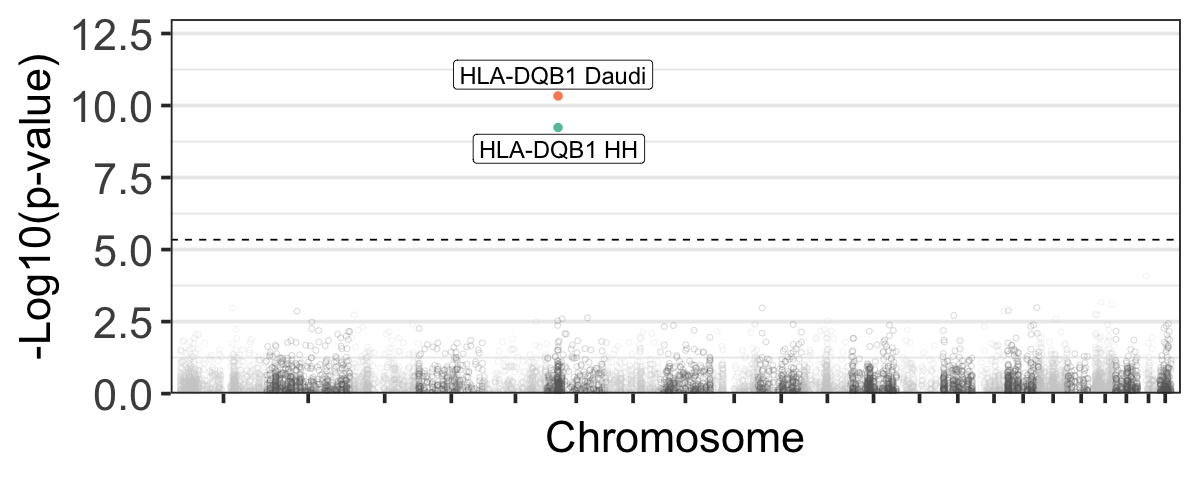

In [408]:
#define colors
colors = rep(c("grey80", "grey40"), 11 )
names(colors) = as.character(1:22)

fig.size(4,10)
g <- don %>% mutate(Gene = paste(Gene, CellType)) %>% 
{
ggplot(., aes(x=BPcum, y=-log10(pval))) +
    
    # Show all points
    geom_point( aes(color=as.factor(Chr)), alpha=0.2, size=1.3, shape = 1) +
    scale_color_manual(values = c(colors, 
                                    "HH" = "#66C2A5", 
                                    "Daudi" = "#FC8D62"))+
    
    # custom X axis:
    scale_x_continuous(expand = c(0.01,0.01),label = axisdf$Chr, breaks= axisdf$center ) +
    scale_y_continuous(expand = c(0, 0), limits = c(NA, -log10(10^-13))) +     # remove space between plot area and x axis
  
    # Custom the theme:
    theme_gy() +
    theme(axis.text.x =element_text(size =0, vjust = 0.5, angle = -90),
      legend.position="none",
      panel.grid.major.x = element_blank(),
      panel.grid.minor.x = element_blank()
    ) + 
    geom_label_repel(data = filter(., pval < 0.05/6136), 
                     aes(label = Gene), size=5) + 

    geom_point(data = filter(., pval < 0.05/6136), 
                     aes(color = CellType), size=2, ) +
geom_hline(yintercept = -log10(0.05/11000), linetype = 2)+
xlab("Chromosome") + 
ylab("-Log10(p-value)")
    }
plot(g)
suppressWarnings({ggsave(g, filename = "Man.png", device="png", width = 10, height = 4) })

`geom_smooth()` using formula = 'y ~ x'


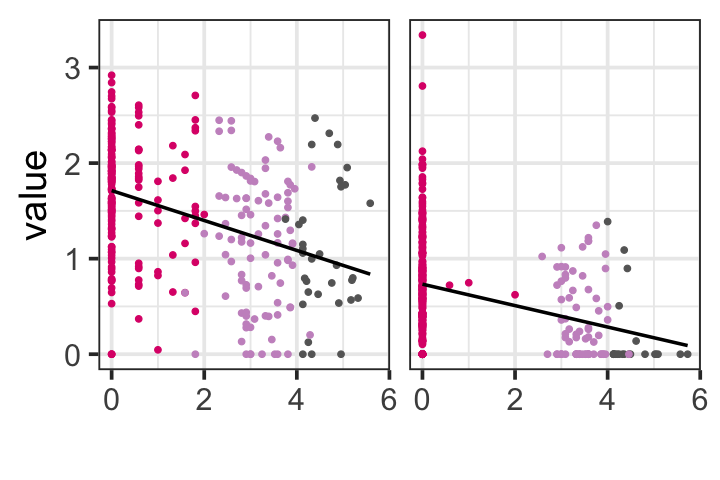

In [2548]:
fig.size(4, 6)

norm_exprs["HLA-DQB1",DQB1Plots$cell] %>% 
as_tibble(rownames = "cell") %>% inner_join(DQB1Plots, by ="cell") %>%  {

ggplot(., aes(x = log2(DQB1deletion_Mean + 1), y = value)) +  
    
geom_point(data = ., aes(color = as.factor(KClust)))  +

theme_gy()+
scale_color_manual(values = c(
          "Control" = "#8698C7",
          "CRISPR" = "#FDBF6E",
          "1" = "#DD1C77", 
          "3" = "#C994C7",
          "2" = "grey40"))+ 
xlab("") + 
#ylab("CD45 ADT")+ 
theme(
     # axis.title.y = element_text(face = "italic"),
    legend.position = "none") + 
      facet_wrap(~cluster.x)  + 
    theme(strip.text = element_blank()) + 
    geom_smooth(method = "lm", color = "black", se =F)
             }
    

In [2557]:
FBXO11_alleles_DNA_filt_gen_Viz_Daudi %>% head

ERROR: Error in h(simpleError(msg, call)): error in evaluating the argument 'x' in selecting a method for function 'head': object 'FBXO11_alleles_DNA_filt_gen_Viz_Daudi' not found


In [179]:
#Read in FBXO11 plots meta data
FBXO11plots <- read_csv("FBXO11plots.csv")

Rows: 1077 Columns: 35
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (19): Well_ID, DNA_Barcode, RNA_Barcode, Experiment_Index, Plate, FBXO11...
dbl (16): PB_CD45, BV605_CD45, SSC, FSC, FITC_DQB1, PE_CD40, PECY7_CD45, APC...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [180]:
#Define Dosage
FBXO11plots2 <- FBXO11plots %>% mutate(Dosage = ifelse(genotype == 1, 2, 
                                      ifelse(genotype == 2, 0, 
                                            ifelse(genotype == 4,1, NA))))
FBXO11plots2 <- na.omit(FBXO11plots2) # Remove other cells

In [181]:
## adtUMI data
FBXO11plots2<- FBXO11plots2 %>% inner_join(dplyr::select(meta_umap_adt_FBXO11.clust, nUMI, cell)) %>% 
inner_join(dplyr::select(meta_umap_FBXO11.clust, nUMI, cell), by = "cell")

Joining with `by = join_by(cell)`


## Genotype Dependent DGE FBXO11 Daudis

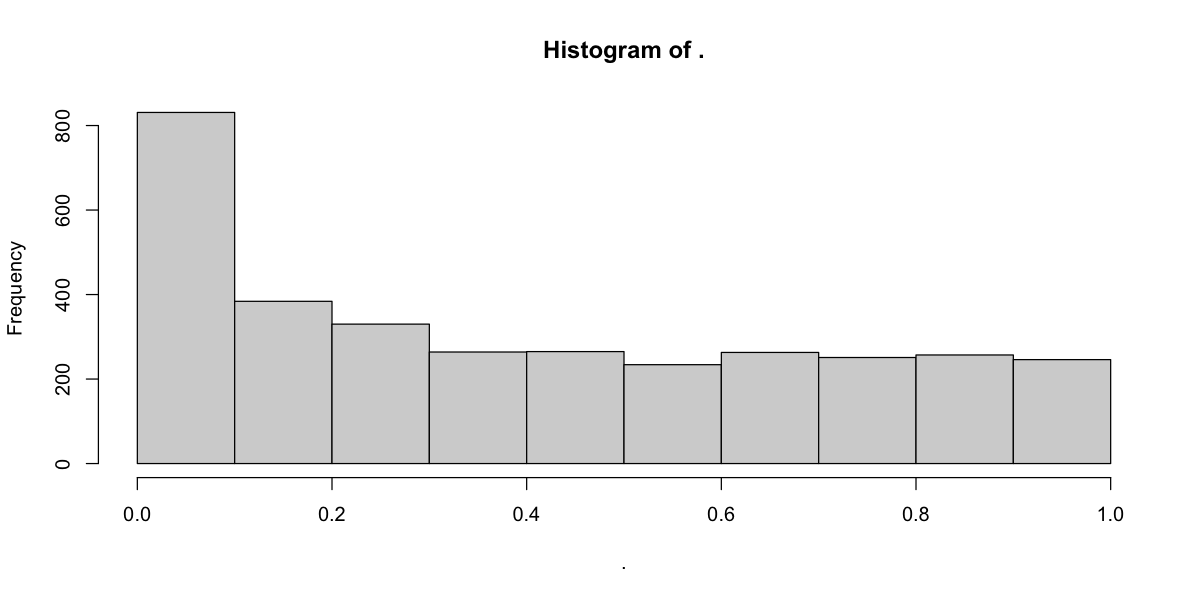

In [337]:
## Linear modeling with negative binomial. 
## Looking at Daudis - Remove Control cells? They are too different. 

cells <- filter(FBXO11plots2, cluster.x == 0 & Edited_Index == "Edited") %>% with(cell) #Daudis
df <- (FBXO11plots2 %>% filter(cluster.x == 0& Edited_Index == "Edited"))

nCells = rowSums(filt_exprs[,cells] > 0)
gene_qc = data.frame(nCells = nCells %>% sort %>% rev, rank = seq(1, length(nCells)))

#Filter on expression in at least 30% of cells
Exprs <- filt_exprs[gene_qc %>% filter(nCells > length(cells)*0.3) %>% rownames, cells]
#Extra filtering step. Mean raw counts of the gene > 1.5 reads per cell - remove noisy low quality counts
genes <- names(which(rowSums(Exprs)/length(cells)> 2))


suppressWarnings({
FBXO11_lm_Daudi <- 
    sapply(genes, function(i){ 
        

    lm0<- glm.nb(data = df,  
          formula = (Exprs)[i,] ~ 1 + log10(nUMI.y) + Plate
            )
    
    lm1 <- glm.nb(data = df,  
          formula = (Exprs)[i,] ~ 1  + log10(nUMI.y) + Plate + Dosage
               )
    
    return(c("pval" = anova(lm0,lm1)[2,dim(anova(lm0,lm1))[2]],
             "beta" = summary(lm1)$coeff[dim(summary(lm1)$coeff)[1],1]))
        })
    })
FBXO11_lm_Daudi<- FBXO11_lm_Daudi %>% t %>% as_tibble(rownames = "Genes")
FBXO11_lm_Daudi %>% with(pval) %>% hist
FBXO11_lm_Daudi <- FBXO11_lm_Daudi %>% arrange(pval) %>% mutate(padj = p.adjust(pval, method = "BH"))

In [428]:
FBXO11_lm_Daudi %>% dim

[1] 3325    4

In [429]:
FBXO11_lm_Daudi_Edited %>% dim

[1] 3427    4

In [342]:
#Save output
write_csv(FBXO11_lm_Daudi, "Intrinsic_FBXO11_Daudi.csv")

## Condition Dependent Linear Modeling

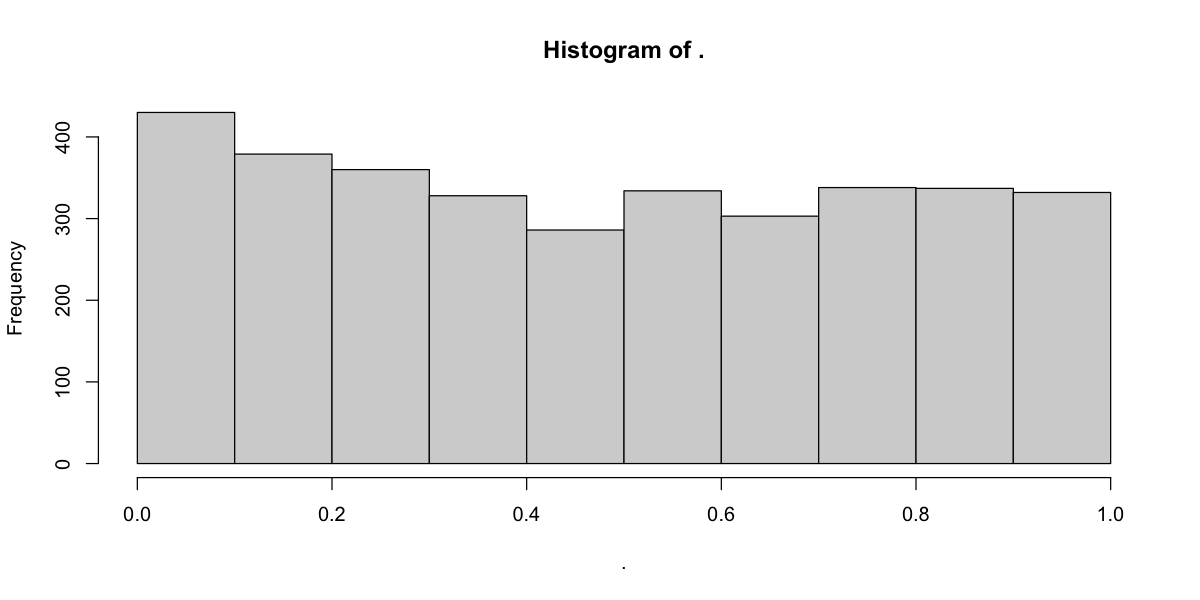

In [338]:
## Linear modeling with negative binomial. 
#filter on gene expression not in the whole data set but only in the selected. 
cells <- filter(FBXO11plots2, cluster.x == 0 & Dosage == 0) %>% with(cell)  #Daudis & Unedited
df <- (FBXO11plots2 %>% filter(cell %in% cells))

nCells = rowSums(filt_exprs[,cells] > 0)
gene_qc = data.frame(nCells = nCells %>% sort %>% rev, rank = seq(1, length(nCells)))

Exprs <- filt_exprs[gene_qc %>% filter(nCells > length(cells)*0.3) %>% rownames, cells]
genes <- names(which(rowSums(Exprs)/length(cells)> 2))

suppressWarnings({
FBXO11_lm_Daudi_Edited <- 
    sapply(genes, function(i){ 
        

    lm0<- glm.nb(data = df,  
          formula = (Exprs)[i,] ~ 1 + log10(nUMI.y) + Plate
            )
    
    lm1 <- glm.nb(data = df,  
          formula = (Exprs)[i,] ~ 1  + log10(nUMI.y) + Plate + Edited_Index
               )
    
    return(c("pval" = anova(lm0,lm1)[2,dim(anova(lm0,lm1))[2]],
             "beta" = summary(lm1)$coeff[dim(summary(lm1)$coeff)[1],1]))
        })
    })
FBXO11_lm_Daudi_Edited<- FBXO11_lm_Daudi_Edited %>% t %>% as_tibble(rownames = "Genes")
FBXO11_lm_Daudi_Edited %>% with(pval) %>% hist
FBXO11_lm_Daudi_Edited <- FBXO11_lm_Daudi_Edited %>% arrange(pval) %>% mutate(padj = p.adjust(pval, method = "BH"))

In [242]:
#Save output
write_csv(FBXO11_lm_Daudi_Edited, "Extrinsic_FBXO11_Daudi.csv")

In [243]:
FBXO11_lm_Daudi_Edited %>% filter(Genes == "HLA-A")

Genes pval        beta       padj     
1 HLA-A 0.003530143 -0.3087686 0.4657666

In [244]:
FBXO11_lm_Daudi_Edited %>% filter(Genes == "HLA-A")

Genes pval        beta       padj     
1 HLA-A 0.003530143 -0.3087686 0.4657666

## Bulk Control vs CRISPR

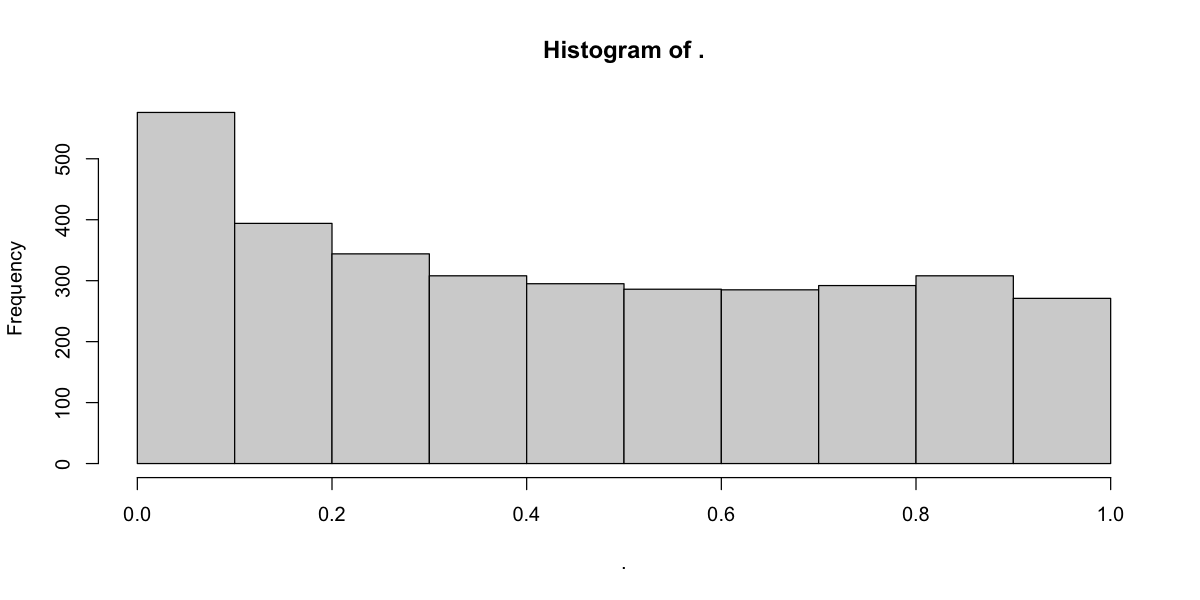

In [340]:
## Linear modeling with negative binomial. 
#filter on gene expression not in the whole data set but only in the selected. 
cells <- filter(FBXO11plots2, cluster.x == 0) %>% with(cell)  #Daudis & Unedited
df <- (FBXO11plots2 %>% filter(cell %in% cells))

nCells = rowSums(filt_exprs[,cells] > 0)
gene_qc = data.frame(nCells = nCells %>% sort %>% rev, rank = seq(1, length(nCells)))

Exprs <- filt_exprs[gene_qc %>% filter(nCells > length(cells)*0.3) %>% rownames, cells]
genes <- names(which(rowSums(Exprs)/length(cells)> 2))

suppressWarnings({
FBXO11_lm_Daudi_Bulk <- 
    sapply(genes, function(i){ 
        

    lm0<- glm.nb(data = df,  
          formula = (Exprs)[i,] ~ 1 + log10(nUMI.y) + Plate
            )
    
    lm1 <- glm.nb(data = df,  
          formula = (Exprs)[i,] ~ 1  + log10(nUMI.y) + Plate + Edited_Index
               )
    
    return(c("pval" = anova(lm0,lm1)[2,dim(anova(lm0,lm1))[2]],
             "beta" = summary(lm1)$coeff[dim(summary(lm1)$coeff)[1],1]))
        })
    })
FBXO11_lm_Daudi_Bulk<- FBXO11_lm_Daudi_Bulk %>% t %>% as_tibble(rownames = "Genes")
FBXO11_lm_Daudi_Bulk %>% with(pval) %>% hist
FBXO11_lm_Daudi_Bulk <- FBXO11_lm_Daudi_Bulk %>% arrange(pval) %>% mutate(padj = p.adjust(pval, method = "BH"))

In [341]:
write_csv(FBXO11_lm_Daudi_Bulk, "ControlvCRISPR_FBXO11_Daudi.csv")

## Genoytpe ADT

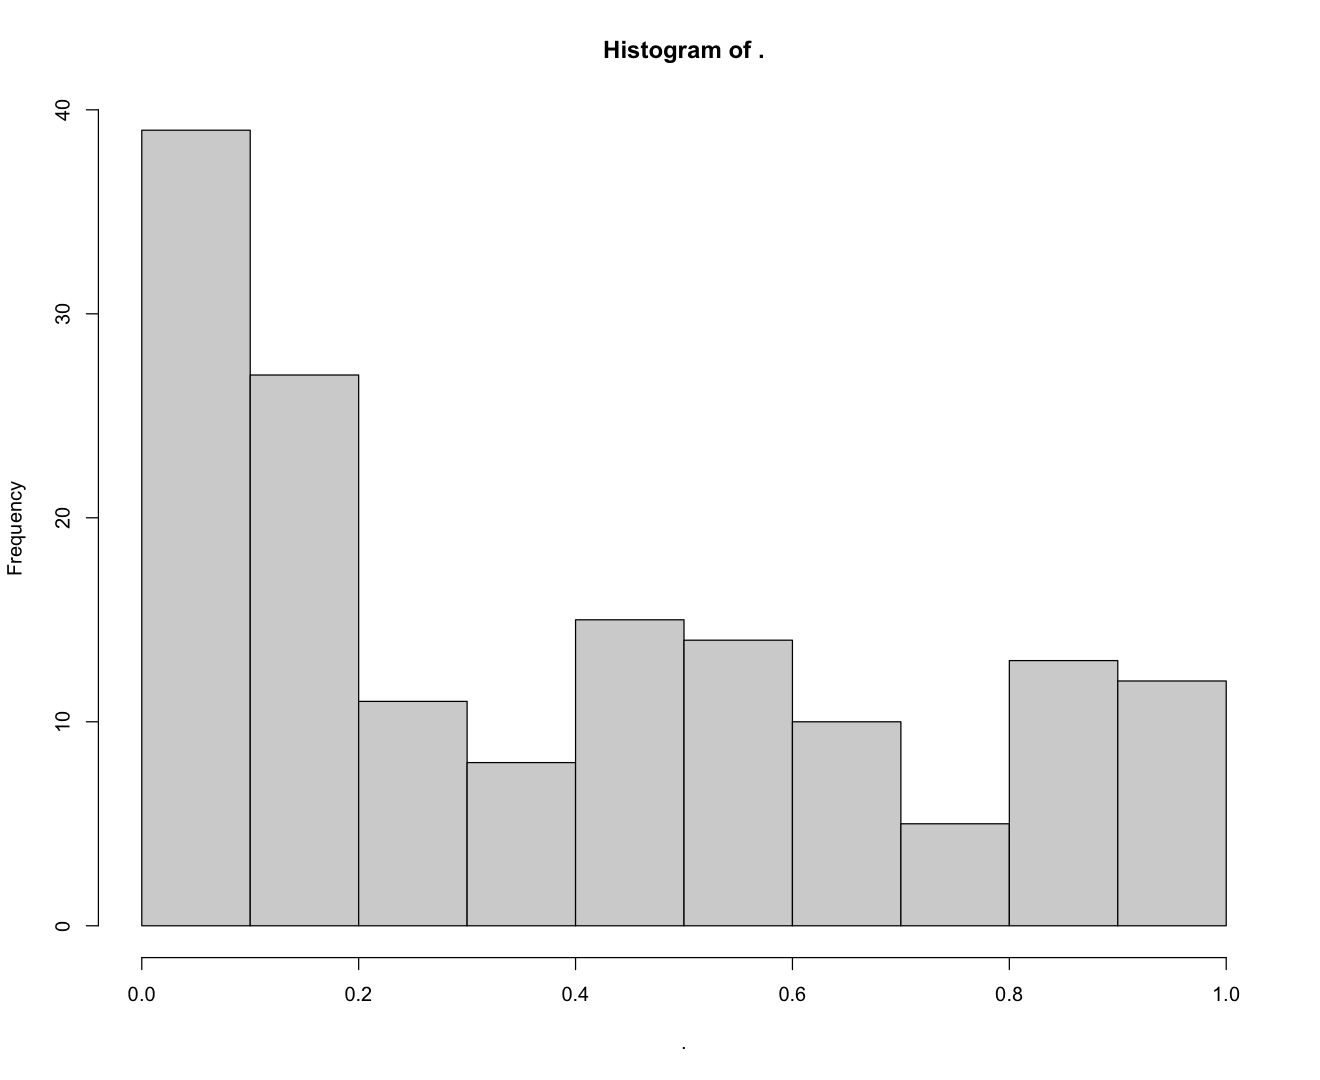

In [251]:
## Linear modeling with negative binomial. 
#filter on gene expression not in the whole data set but only in the selected. 
cells <- filter(FBXO11plots2, cluster.x == 0 & Edited_Index == "Edited") %>% with(cell) #Daudis
df <- (FBXO11plots2 %>% filter(cluster.x == 0 & Edited_Index == "Edited"))

Exprs <- counts_ADT_filt[,cells]
genes <- rownames(Exprs)

suppressWarnings({
FBXO11_lm_Daudi_adt <- 
    sapply(genes, function(i){ 
        

    lm0<- glm.nb(data = df,  
          formula = (Exprs)[i,] ~ 1 + log10(nUMI.x) + Plate
            )
    
    lm1 <- glm.nb(data = df,  
          formula = (Exprs)[i,] ~ 1  + log10(nUMI.x) + Plate + Dosage
               )
    
    return(c("pval" = anova(lm0,lm1)[2,dim(anova(lm0,lm1))[2]],
             "beta" = summary(lm1)$coeff[dim(summary(lm1)$coeff)[1],1]))
        })
    })
FBXO11_lm_Daudi_adt<- FBXO11_lm_Daudi_adt %>% t %>% as_tibble(rownames = "Genes")
FBXO11_lm_Daudi_adt %>% with(pval) %>% hist
FBXO11_lm_Daudi_adt <- FBXO11_lm_Daudi_adt %>% arrange(pval) %>% mutate(padj = p.adjust(pval, method = "BH"))

In [252]:
write_csv(FBXO11_lm_Daudi_adt, "Intrinsic_FBXO11_Daudi_ADT.csv")

## Condition ADT

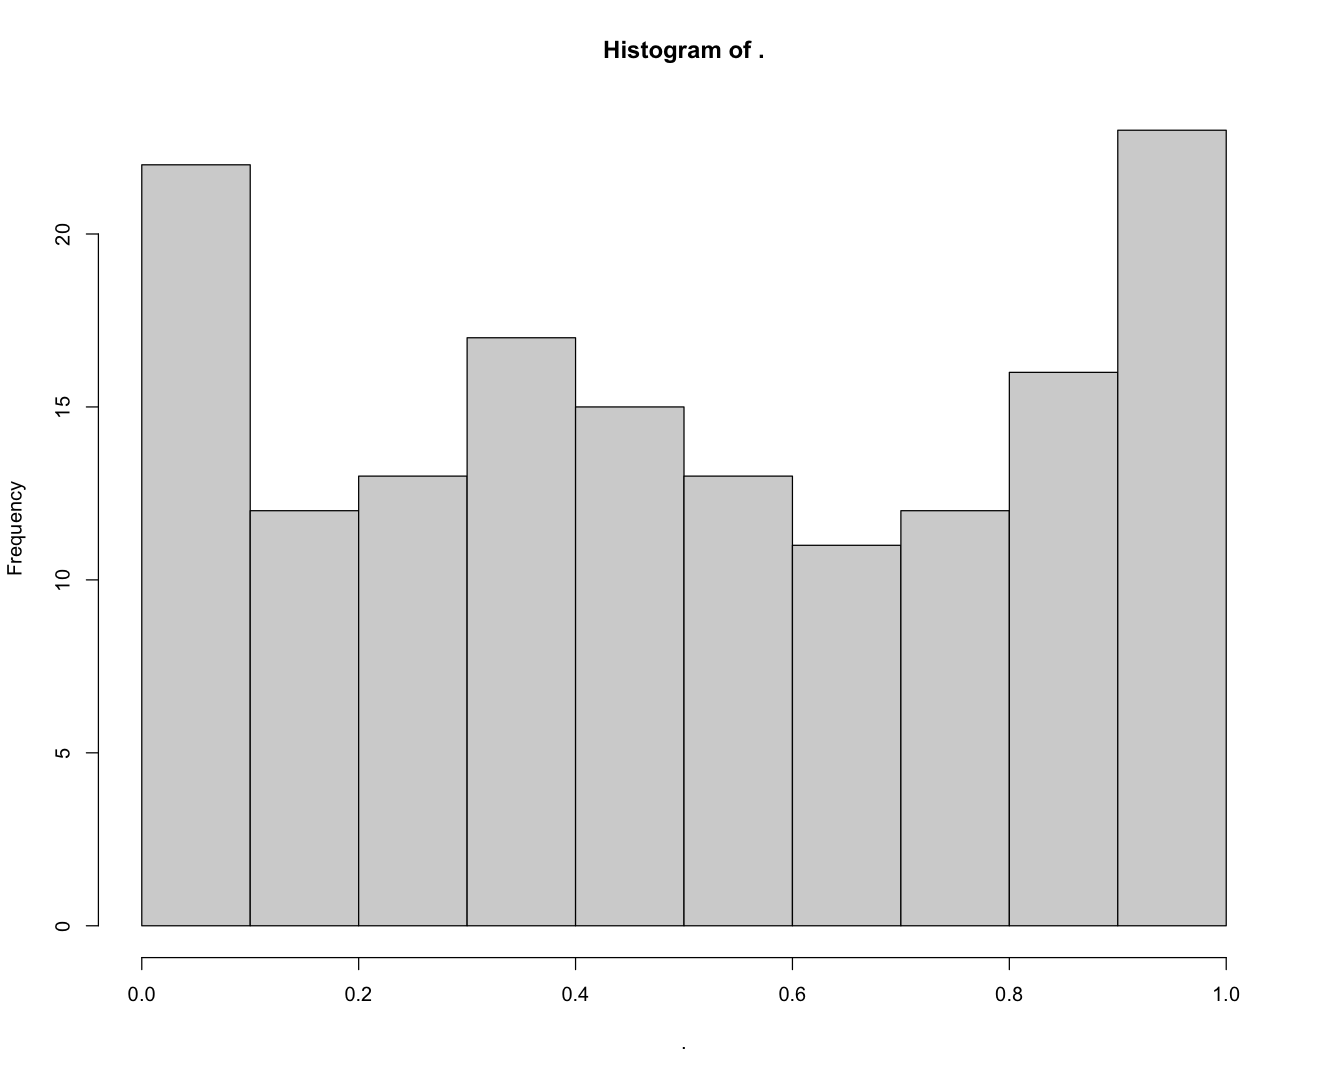

In [253]:
## Linear modeling with negative binomial. 
#filter on gene expression not in the whole data set but only in the selected. 
cells <- filter(FBXO11plots2, cluster.x == 0 & Dosage == 0) %>% with(cell) #Daudis
df <- (FBXO11plots2 %>% filter(cell %in% cells))

Exprs <- counts_ADT_filt[,cells]
genes <- rownames(Exprs)

suppressWarnings({
FBXO11_lm_Daudi_adt_Edited <- 
    sapply(genes, function(i){ 
        

    lm0<- glm.nb(data = df,  
          formula = (Exprs)[i,] ~ 1 + log10(nUMI.x) + Plate
            )
    
    lm1 <- glm.nb(data = df,  
          formula = (Exprs)[i,] ~ 1  + log10(nUMI.x) + Plate + Edited_Index
               )
    
    return(c("pval" = anova(lm0,lm1)[2,dim(anova(lm0,lm1))[2]],
             "beta" = summary(lm1)$coeff[dim(summary(lm1)$coeff)[1],1]))
        })
    })
FBXO11_lm_Daudi_adt_Edited<- FBXO11_lm_Daudi_adt_Edited %>% t %>% as_tibble(rownames = "Genes")
FBXO11_lm_Daudi_adt_Edited %>% with(pval) %>% hist
FBXO11_lm_Daudi_adt_Edited <- FBXO11_lm_Daudi_adt_Edited %>% arrange(pval) %>% mutate(padj = p.adjust(pval, method = "BH"))

In [254]:
FBXO11_lm_Daudi_adt_Edited %>% head

Genes pval         beta       padj      
1 CD45  0.0000000000  0.5517526 0.00000000
2 CD54  0.0003269682 -0.2739499 0.02517655
3 CD27  0.0010480123  0.3417498 0.04424565
4 CD95  0.0011492377 -0.1746598 0.04424565
5 CD154 0.0020333044 -0.1024743 0.06262577
6 CD103 0.0035826005 -0.2571108 0.09195341

In [255]:
write_csv(FBXO11_lm_Daudi_adt_Edited, "Extrinsic_FBXO11_Daudi_ADT.csv")

## Bulk Control vs CRISPR

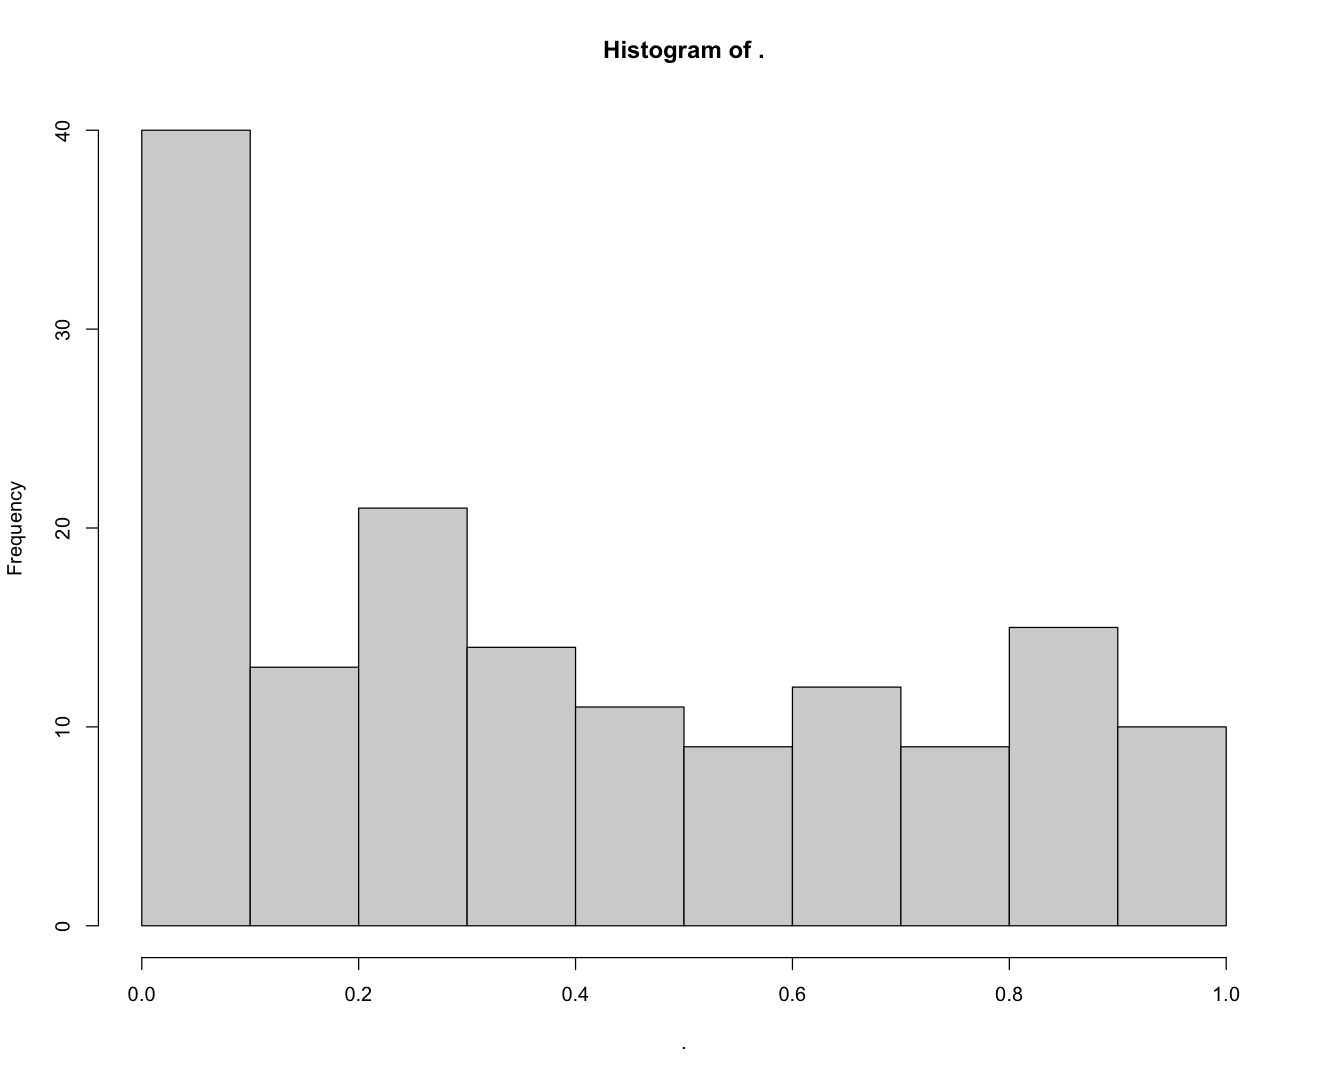

In [258]:
## Linear modeling with negative binomial. 
#filter on gene expression not in the whole data set but only in the selected. 
cells <- filter(FBXO11plots2, cluster.x == 0) %>% with(cell) #Daudis
df <- (FBXO11plots2 %>% filter(cluster.x == 0))

Exprs <- counts_ADT_filt[,cells]
genes <- rownames(Exprs)

suppressWarnings({
FBXO11_lm_Daudi_adt_Bulk <- 
    sapply(genes, function(i){ 
        

    lm0<- glm.nb(data = df,  
          formula = (Exprs)[i,] ~ 1 + log10(nUMI.x) + Plate
            )
    
    lm1 <- glm.nb(data = df,  
          formula = (Exprs)[i,] ~ 1  + log10(nUMI.x) + Plate + Edited_Index
               )
    
    return(c("pval" = anova(lm0,lm1)[2,dim(anova(lm0,lm1))[2]],
             "beta" = summary(lm1)$coeff[dim(summary(lm1)$coeff)[1],1]))
        })
    })
FBXO11_lm_Daudi_adt_Bulk<- FBXO11_lm_Daudi_adt_Bulk %>% t %>% as_tibble(rownames = "Genes")
FBXO11_lm_Daudi_adt_Bulk %>% with(pval) %>% hist
FBXO11_lm_Daudi_adt_Bulk <- FBXO11_lm_Daudi_adt_Bulk %>% arrange(pval) %>% mutate(padj = p.adjust(pval, method = "BH"))

In [259]:
write_csv(FBXO11_lm_Daudi_adt_Bulk, "ControlvCRISPR_FBXO11_Daudi_ADT.csv")

In [256]:
FlowMatrix_Genes <- FlowMatrix %>% 
    mutate("Experiment_Index" = ifelse(Experiment_Index == "PTEN", "JDHEK", Experiment_Index)) %>%
    mutate("Condition" = paste0(Experiment_Index, "_", Plate)) %>% 
    inner_join(read_csv("PlateMeta.csv")) %>% 
    mutate("cell" = paste0(RNA_Barcode, "_",Barcode )) %>% 
    inner_join(
        select(norm_filt_exprs, c(cell, "FAS","CD40", "HLA-DQB1", "HLA-DRB1", "FBXO11", "PTEN", "GAPDH", "ACTB", "CD19", "UBB")))

Rows: 24 Columns: 3
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): Condition, Barcode, Type

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Joining with `by = join_by(Condition)`


ERROR: Error: object 'norm_filt_exprs' not found


In [ ]:
##Add in ADT data
FlowMatrix_Genes_ADT <-  CLR_adt_filt %>%
inner_join(meta_ADT_filt) %>%    
    inner_join(FlowMatrix_Genes, by = "cell")

In [ ]:
## export this data for later use. Never have to redo this again. 
write_csv(FlowMatrix_Genes_ADT, "FlowMatrix_Genes_ADT.csv")

## Venn Diagram Comparing Wilcox

In [247]:
library("ggvenn")

Loading required package: grid


Attaching package: ‘grid’


The following object is masked from ‘package:Biostrings’:

    pattern




In [343]:
#Intesections and differences
featurex <- FBXO11_lm_Daudi %>% filter(padj < 0.05) %>% with(Genes)
featurey <- FBXO11_lm_Daudi_Bulk %>% filter(padj < 0.05) %>% with(Genes)
featurexadt <- FBXO11_lm_Daudi_adt %>% filter(padj < 0.05) %>% with(Genes)
featureyadt <- FBXO11_lm_Daudi_adt_Bulk   %>% filter(padj < 0.05) %>% with(Genes)

In [344]:
intersect(featurex, featurey)
intersect(featurexadt, featureyadt)
setdiff(featurey, featurex)

[1] "MPST"     "HLA-DRB1" "WARS"     "FBXO11"   "AK2"      "RNF187"   "CSTB"

[1] "CD40"        "CD58"        "HLADR"       "CD131"       "HLADR_DP_DQ"
 [6] "CD72"        "CD37"        "CD275"       "CD49d"       "CD85j"      
[11] "CD27"        "CD29"        "CD21"        "CD63"

[1] "HLA-A"     "HSP90B1"   "HLA-B"     "NCF1"      "PDIA6"     "TRIB3"    
 [7] "HLA-C"     "IER3IP1"   "MT-ND1"    "DDX5"      "IGLV10-54" "PITX1"    
[13] "DNAJB1"

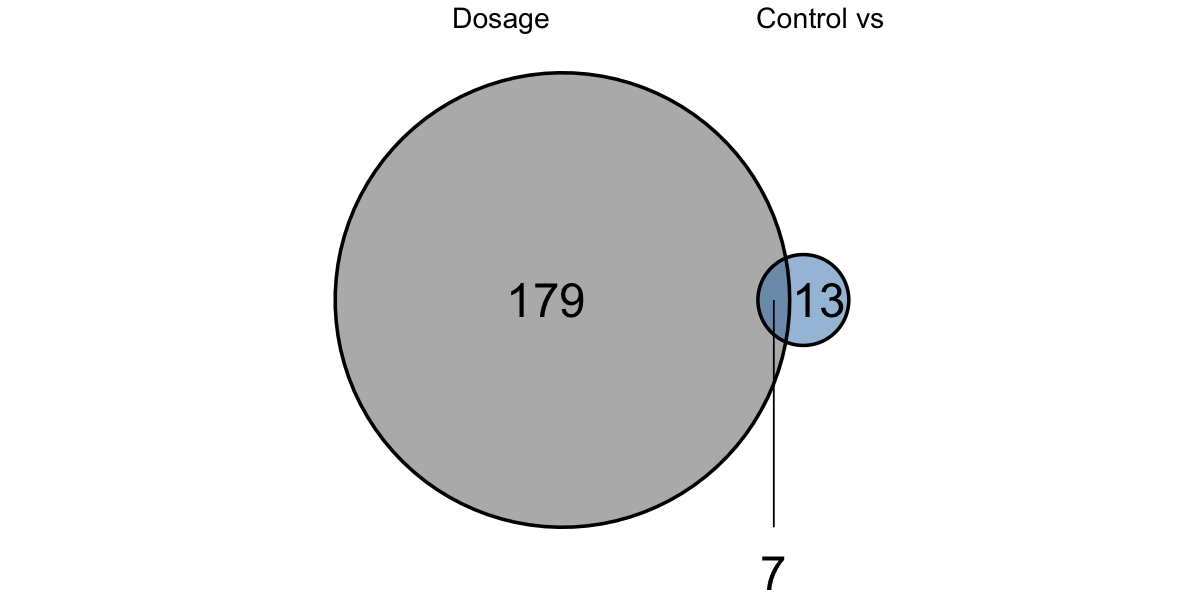

In [345]:
# fig.size(5,5)
g2 <- ggvenn(list("Dosage" = featurex, 
             "Control vs Edited" = featurey), 
      auto_scale = T, 
      fill_color = c("grey40","#377EB8"), 
      text_size = 10, 
      show_percentage = F)

plot(g2)
ggsave(filename = "ADT_FBXO11.png", device = png, plot = g2,width = 1, height = 1)

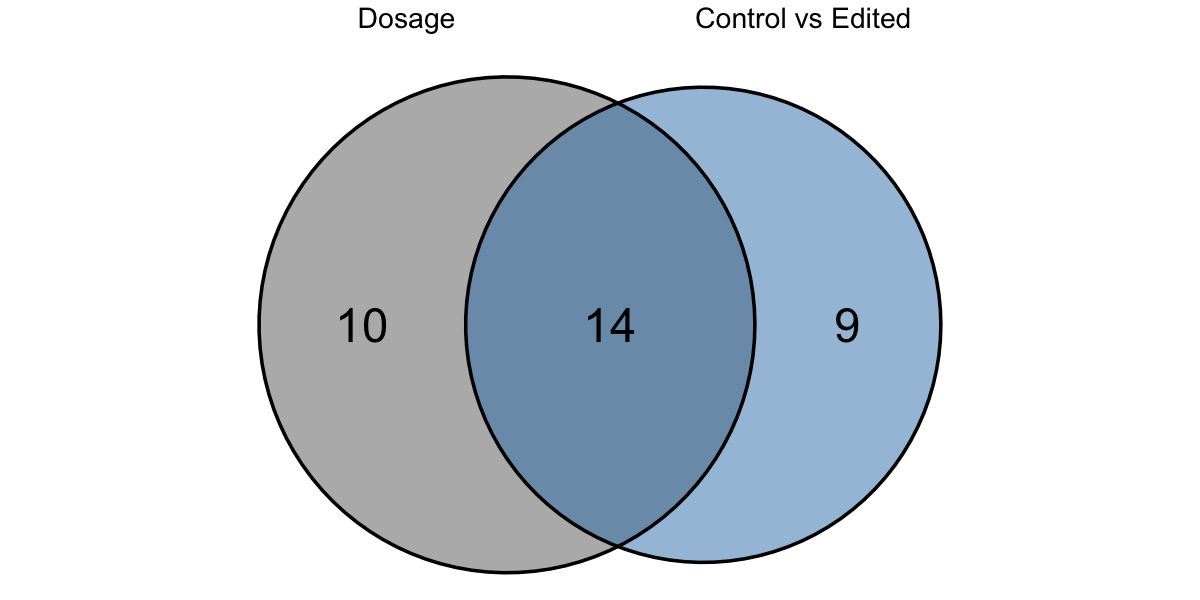

In [346]:
g2 <- ggvenn(list("Dosage" = featurexadt, 
             "Control vs Edited" = featureyadt), 
      auto_scale = T, 
      fill_color =c("grey40","#377EB8"), 
      text_size = 10, 
      show_percentage = F)


plot(g2)
ggsave(filename = "ADT_FBXO11.png", device = png, plot = g2,width = 2, height = 2)

In [347]:
jointviolindata <- rbind(mutate(FBXO11_lm_Daudi, group = "Dosage"), 
                         mutate(FBXO11_lm_Daudi_Bulk, group = "Edited"))

jointviolindata_adt <-rbind(mutate(FBXO11_lm_Daudi_adt, group = "Dosage"), 
                         mutate(FBXO11_lm_Daudi_adt_Bulk, group = "Edited"))

In [348]:
jointviolindata %>% filter(padj < 0.05 & group == "Edited") %>% dim
jointviolindata_adt %>% filter(padj < 0.05 & group == "Edited") %>% dim

[1] 20  5

[1] 23  5

In [349]:
jointviolindata %>% filter(Genes == "CD40")

Genes pval         beta       padj       group 
1 CD40  0.0009187758 -0.2352939 0.02443944 Dosage
2 CD40  0.0155463860 -0.4324566 0.30360646 Edited

In [430]:
fig.size(4,6)
adtlabels <- c("CD40", "HLADR", "IgM", "CD27", "CD22")
genelabels <- c("FBXO11", "CD40", "HLA-DRA", "IGLL1", "CD27")

g1 <- jointviolindata_adt %>% {
ggplot(.) + 
geom_point(aes(beta, -log10(pval), color = group)) +
geom_point(aes(beta, -log10(pval), color = group))+
theme_gy() + facet_wrap(~factor(group, levels = c("Edited", "Dosage")))+ 
scale_color_manual(values = c(
          
          "Edited" = "#377EB8",
          "Dosage" = "grey40")) + 
geom_label_repel(data = . %>% filter(Genes %in% adtlabels), 
               aes(beta, -log10(pval), label = Genes), size = 5) + 
    geom_point(data = . %>% filter(Genes %in% adtlabels), 
               aes(beta, -log10(pval), label = Genes), size = 2, color = "red") +
theme(legend.position = "none") + 
theme(legend.position = "none") + 
geom_hline(yintercept = -log10(jointviolindata_adt %>% arrange(pval)%>% filter(padj < 0.05) %>% tail(1) %>% with(pval)), linetype =2)+ 
ylab("-Log10(p-value)")+ 
    theme(axis.text.x = element_text(size = 20),axis.text.y = element_text(size = 20),
          strip.text = element_blank(), 
         panel.spacing = unit(1, "lines"))
    }


fig.size(4,6)
g2 <- jointviolindata %>% {
ggplot(.) + 
geom_point(aes(beta, -log10(pval), color = group)) +
geom_point(aes(beta, -log10(pval), color = group))+
theme_gy() + facet_wrap(~factor(group, levels = c("Edited", "Dosage")))+ 
scale_color_manual(values = c(
          "Edited" = "#377EB8",
          "Dosage" = "grey40")) + 
geom_label_repel(data = . %>% filter(Genes %in% genelabels), 
               aes(beta, -log10(pval), label = Genes), size = 5) + 
    geom_point(data = . %>% filter(Genes %in% genelabels), 
               aes(beta, -log10(pval), label = Genes), size = 2, color = "red") +
theme(legend.position = "none") + 
geom_hline(yintercept = -log10(jointviolindata %>% arrange(pval) %>% filter(padj < 0.05) %>% tail(1) %>% with(pval)), linetype =2)+ 
ylab("-Log10(p-value)") +
    theme(axis.text.x = element_text(size = 20),
          axis.text.y = element_text(size = 20),
          strip.text = element_blank(), 
         panel.spacing = unit(1, "lines"))



}

Warning message in geom_point(data = . %>% filter(Genes %in% adtlabels), aes(beta, :
“Ignoring unknown aesthetics: label”
Warning message in geom_point(data = . %>% filter(Genes %in% genelabels), aes(beta, :
“Ignoring unknown aesthetics: label”


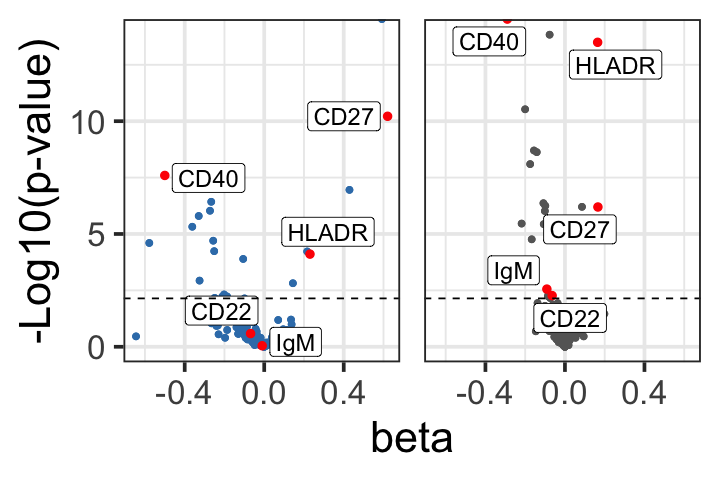

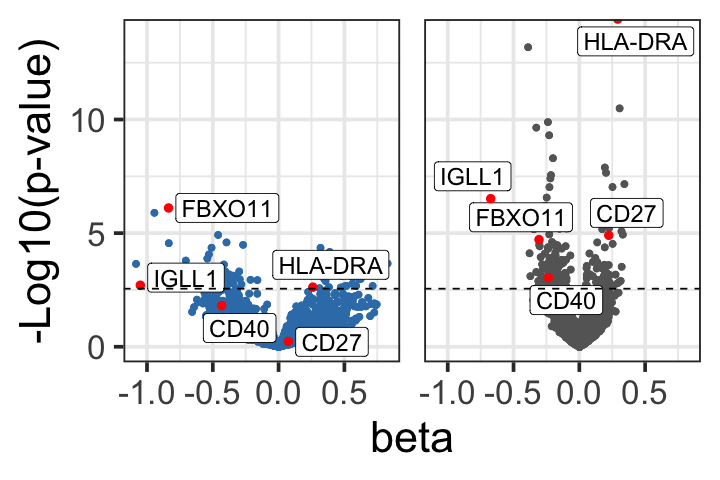

In [431]:
fig.size(4,6)
g1
g2

In [398]:
ggsave(filename = "RNA_FBXO11.png", device = png, plot = g2,width = 6, height = 4)